In [1]:
'''
To run hit Kernel > restart & run all.

Scroll to the bottom to select the gft and fasta files with the drop down.

Resulting graphs and analysis will be output below
'''

'\nTo run hit Kernel > restart & run all.\n\nScroll to the bottom to select the gft and fasta files with the drop down.\n\nResulting graphs and analysis will be output below\n'

In [2]:
''' If you have issues with unfound packages, uncomment the pip install lines below'''
# ! pip install ipywidgets
# ! pip install matplotlib
# ! pip install pandas

! jupyter nbextension enable --py widgetsnbextension
''' If you have issues with unfound packages, uncomment the pip install lines above'''

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


' If you have issues with unfound packages, uncomment the pip install lines above'

In [3]:
from ipywidgets import *
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
from ipywidgets import HBox, Label

# %matplotlib inline

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
class FileType(Enum):
    UNSUPPORTED = 0
    FASTA = 1
    GFT = 2
    
summary = {}
NUMBER_MISMATCHES = 0

In [6]:
def graph_data(series):
    plt.plot(series)
    plt.ylabel('Y label')
    plt.xlabel('X label')
    plt.title('Title')
    plt.show()
    return plt

def read_gft(filename):
    gft = pd.read_csv(filename, sep=r'[;\t]', 
                     header=None, 
                     names=["seqname", "source", "feature", "coordinate1", "coordinate2", "score", "orientation", "frame", 
                            "gene_id", "transcript_id", "parsed"],
                     engine='python')
    
     # If the gene ID has the "-" then it is the same as the transcript ID.
    gft.gene_id = gft.transcript_id.str.split("-").str[0].str.split("\"").str[1]
    gft.parsed = gft.transcript_id.str.split("-").str[1].str.replace("\"", "")

    first_transcripts = gft.groupby("gene_id").transcript_id.first()
    
    #only return first transcription of each gene
    return gft[gft.transcript_id.isin(first_transcripts)]

def get_avg_gene_span(gft):
    spans = []
    for gid in gft.gene_id.unique():
        exon_coordinate_list = (gft[ gft.gene_id == gid].coordinate1).append(gft[ gft.gene_id == gid].coordinate2)
        gene_span = exon_coordinate_list.max() - exon_coordinate_list.min() + 1
        spans.append(gene_span)
    return pd.Series(spans).mean()

def get_avg_intergenic_space(gft):
    # intergenic space is min cordinate 1 of gene 2      max cordinate 2 of gene 1
    spacing = pd.DataFrame()
    spacing["left"] = gft.groupby("gene_id").coordinate1.min()
    spacing["right"] = gft.groupby("gene_id").coordinate1.max()
    diff = []
    for r in range(0, len(spacing) - 1):
        diff.append(spacing.iloc[r + 1].right - spacing.iloc[r].left)
    return pd.Series(diff).mean()

def get_avg_length(gft, condition):
    gft = gft[condition]
    spacing = pd.DataFrame()
    spacing["left"] = gft.coordinate1
    spacing["right"] = gft.coordinate2
    diff = []
    for r in range(0, len(spacing) - 1):
            diff.append(spacing.iloc[r].left - spacing.iloc[r + 1].right + 1)
    return pd.Series(diff).mean()

def find_200_before_gene(gft):
    starts = {}
    mi = gft.groupby("gene_id").min()
    ma = gft.groupby("gene_id").max()

    for n in ma[ma.orientation == '-'].index:
        starts[str(n)] = (ma.loc[n].coordinate2, ma.loc[n].coordinate2 + 200)

    for n in mi[mi.orientation == '+'].index:
        starts[str(n)] = (mi.loc[n].coordinate1 - 200, mi.loc[n].coordinate1)
    return starts
    

def process_gft(gft):
    global summary
    summary["Number of Genes"] = gft.gene_id.nunique()
    summary["Gene Density"] = gft.gene_id.nunique() / gft.gene_id.count()
    summary["Average Gene Span"] = get_avg_gene_span(gft[gft.feature != "stop_codon"])
    summary["Average Intergenic Spaces"] = get_avg_intergenic_space(gft) 
    
    summary["Average Intron Length"] = abs(get_avg_length(gft, gft.feature == "exon"))
    
    summary["Number of Exons"] = gft[gft.feature == "exon"].seqname.count()
    summary["Number of Introns"] = summary["Number of Exons"] - 1
    summary["Average Exon Length"] = (gft[gft.feature != "stop_codon"].coordinate2 - gft[gft.feature != "stop_codon"].coordinate1 + 1).mean()
    
    summary["Average GC Content"] = "Use information from the fasta file!"
    
    summary["Starts"] = find_200_before_gene(gft)
    return summary
    
def read_lab1(filename):
    seq = ""
    with open(filename) as file:
        line1 = file.readline()
        seq = file.read().replace('\n', "").replace('\t', "")
    d = {'A': [], 'C': [], 'G': [], 'T': [], 'N': []}
    for s in seq:
        d[s].append(1)
        for k in d.keys():
            if k is not s:
                d[k].append(0)
    df = pd.DataFrame(d)
    return df
    
def analyze_lab1(df):
    total_gc = df.C.mean() + df.G.mean()
    global summary 
    summary["Average GC Content"] = total_gc
    summary["Total Unknown"] = df.N.mean()
    
    s = int(df.shape[0])
    window_size = int(s / 20)
    plt.plot(total_gc)
    off = int(s/float(66.6))

    # TODO make this better. 
    if off == 0:
        plt.plot(get_averages(df, s, window_size, offset=0)[0])
    else:
        for o in range(0, window_size, off):
            plt.plot(get_averages(df, s, window_size, offset=o)[0])

    plt.ylabel('Percentage')
    plt.xlabel('Window Number')
    
    locs = list(summary["Starts"].values())[0]
    print(locs)
    plt.title('GC Percentage from %s to %s' %(locs[0], locs[1]))
    plt.show()
    return plt

def get_averages(df, s, window_size, offset=0, print_me=False):
    rolling_avg = []
    window = []
    for i in range(offset, s, window_size):
        gc = df.iloc[i : i + window_size].G.mean() + df.iloc[i : i + window_size].C.mean()
        if print_me:
            print("window: ", i, i + window_size, "\t the gc content is: ", gc, "unknown: ", df.iloc[i : i + window_size].N.mean())
        rolling_avg.append(gc)
        window.append((i, i+window_size))
    return rolling_avg, window
    
def reverse_complement(seq):
    for k,v in alt_map.iteritems():
        seq = seq.replace(k,v)
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    for k,v in alt_map.iteritems():
        bases = bases.replace(v,k)
    return bases

def handle_gft(fname):
    filename = "data/" + fname
    file_type = FileType.GFT
    with open(filename) as file:
        line1 = file.readline()
        if line1[0] is '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)
    df = read_gft(filename)
    summary = process_gft(df)
    return summary

def handle_fasta(fname):
    filename = "data/" + fname
    file_type = FileType.FASTA
    with open(filename) as file:
        line1 = file.readline()
        if line1[0] is not '>':
            raise UserWarning("That file type is unsupported. Exiting.")
            sys.exit(-1)

    df = read_lab1(filename)
    # loop on analysis for each gene
    global summary        
    genes_start = summary["Starts"]
    
    for gene, locations in genes_start.items():
        upstream_region = df.loc[locations[0] : locations[1]]
        analyze_lab1(upstream_region)
        x = upstream_region.stack()
        up_list = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1))).tolist()
        print("Motif locations for", gene)
        motif_location = get_mos("".join(up_list))
    print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")

    print("\n".join("{}: {}".format(k, v) for k, v in summary.items()))
    #     return plt_instance

In [7]:
def frequentWords( s, k ):
    counts = {}
    for i in range(0,len(s)-k+1):
        if "N" in s[i:i+k]:
            continue
        if s[i:i+k] not in counts:
            counts[s[i:i+k]] = 0
        counts[s[i:i+k]] += 1
    m = max(counts.values())
    
    top_counts = list(counts.values())
    top_counts.sort()
    top_counts = top_counts[-3:]
    
    out = []
    for kmer in counts:
        if k > 5 and (counts[kmer] in top_counts) and (counts[kmer] >= 2):
            out.append(kmer)
        elif counts[kmer] in top_counts and (counts[kmer] > 2):
            out.append(kmer)
    return out

In [8]:
import regex as re
def get_motifs_and_locations(f, seq):
    
    if NUMBER_MISMATCHES is not 0:
        error_string = "{e<=%d}" %NUMBER_MISMATCHES
    else:
        error_string = ""
    motif_location = {}
    
    for word in f:
        matches = re.finditer('(%s)%s'% (word, error_string) , seq, overlapped=True)
        for m in matches:
            loc = m.span()[0]
            phrase = m.group()
            
            fuzzy = ""
            if phrase not in motif_location:
                motif_location[phrase] = []
            if m.fuzzy_counts != (0,0,0):
                fuzzy = "*"
            motif_location[phrase].append(str(loc) + fuzzy)
    print("\n".join("{}: {}".format(k, v) for k, v in motif_location.items()))

In [9]:
def get_mos(my_sequence):
    for i in range(4, 11):
        f = frequentWords(my_sequence, i)
        if f:
            get_motifs_and_locations(f, my_sequence)
        else:
            break

Dropdown(description='GFT:', options=('gft1.txt', 'biarmipes_3L_KB462792_FASTA.txt', 'DNA.txt', '_biarmipes_3L…

Dropdown(description='FASTA:', options=('gft1.txt', 'biarmipes_3L_KB462792_FASTA.txt', 'DNA.txt', '_biarmipes_…

BoundedIntText(value=0, description='Mismatches : ', max=10)

(1305785, 1305985)


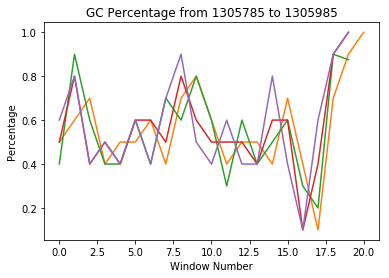

Motif locations for Act79B
GGAT: ['31', '68', '74', '81']
ACAG: ['35', '39', '121', '127']
GACA: ['38', '98', '126', '158']
CGGA: ['67', '73', '80', '88']
CGAC: ['97', '106', '125', '157']
CGGAT: ['67', '73', '80']
CGACA: ['97', '125', '157']
GGATAC: ['31', '68']
TACGGA: ['65', '71']
ACGGAT: ['66', '72']
TGCGGA: ['78', '86']
GCGACA: ['96', '124']
TACGGAT: ['65', '71']
(1305785, 1305985)


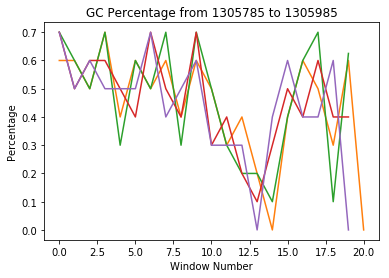

Motif locations for Atox1
CTGC: ['1', '4', '7', '10', '13', '177']
TGCT: ['2', '5', '8', '11', '14', '40']
GCTG: ['3', '6', '9', '12', '15']
ACTT: ['21', '49', '85', '115', '128']
CTTT: ['77', '86', '116', '129', '154']
CTGCT: ['1', '4', '7', '10', '13']
TGCTG: ['2', '5', '8', '11', '14']
GCTGC: ['3', '6', '9', '12']
CTGCTG: ['1', '4', '7', '10', '13']
TGCTGC: ['2', '5', '8', '11']
GCTGCT: ['3', '6', '9', '12']
CTGCTGC: ['1', '4', '7', '10']
TGCTGCT: ['2', '5', '8', '11']
GCTGCTG: ['3', '6', '9', '12']
CTGCTGCT: ['1', '4', '7', '10']
TGCTGCTG: ['2', '5', '8', '11']
GCTGCTGC: ['3', '6', '9']
CTGCTGCTG: ['1', '4', '7', '10']
TGCTGCTGC: ['2', '5', '8']
GCTGCTGCT: ['3', '6', '9']
CTGCTGCTGC: ['1', '4', '7']
TGCTGCTGCT: ['2', '5', '8']
GCTGCTGCTG: ['3', '6', '9']
(1305785, 1305985)


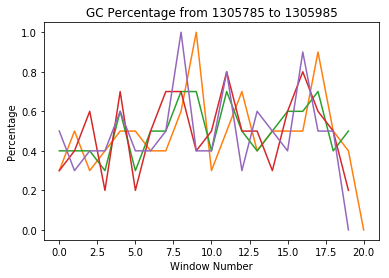

Motif locations for CG11131
TGTG: ['0', '9', '48']
TGAA: ['2', '62', '163']
GTTT: ['6', '12', '135']
TTTG: ['7', '13', '151']
TCGA: ['26', '131', '177']
CGAG: ['27', '132', '178']
GAGC: ['28', '154', '181']
AGCT: ['29', '123', '182']
GCTG: ['30', '46', '116', '124']
GCCA: ['51', '106', '144', '156']
TTGA: ['61', '152', '162']
GAAT: ['68', '110', '128']
TCGAG: ['26', '131', '177']
TTGAAC: ['61', '162']
AGCCAG: ['105', '155']
(1305785, 1305985)


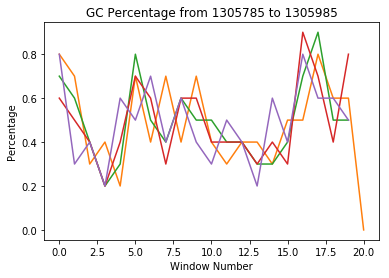

Motif locations for CG11226
TCGA: ['11', '118', '148']
CGAG: ['12', '59', '119']
GTGT: ['18', '25', '74', '76', '122']
TGTT: ['19', '26', '77']
GTTT: ['20', '27', '78']
TTTT: ['21', '79', '80', '161']
TTTG: ['22', '28', '81']
TTGT: ['23', '63', '183']
TTGC: ['29', '94', '106']
CTTG: ['32', '93', '110']
GAAA: ['36', '113', '192']
AAAT: ['38', '115', '145']
GCAC: ['53', '87', '174']
GAGT: ['60', '120', '141']
GTTG: ['62', '105', '182']
GTGTT: ['18', '25', '76']
TGTTT: ['19', '26', '77']
GTGTTT: ['18', '25', '76']
TGTTTT: ['19', '77']
TGTGTT: ['24', '75']
TGCTTG: ['30', '91']
GAAAAT: ['36', '113']
GTTGTC: ['62', '182']
TTGTCA: ['63', '183']
AAATCG: ['115', '145']
AATCGA: ['116', '146']
ACACAA: ['129', '134']
GTGTTTT: ['18', '76']
TGTGTTT: ['24', '75']
GTTGTCA: ['62', '182']
AAATCGA: ['115', '145']
(1305785, 1305985)


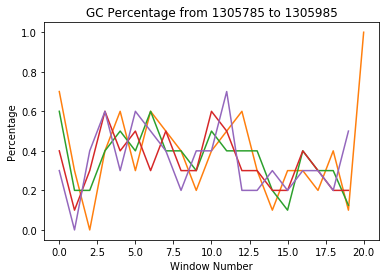

Motif locations for CG11248
AAAC: ['9', '49', '103', '164', '186']
TTTA: ['24', '129', '141', '158', '176', '195']
TTAA: ['114', '130', '159', '177', '196']
ATTTA: ['23', '157', '175']
AAAAC: ['48', '102', '185']
TTTAA: ['129', '158', '176', '195']
ACATT: ['155', '173', '191']
CATTT: ['156', '174', '192']
AAACAG: ['9', '164']
TTATAT: ['19', '142']
TATATT: ['20', '143']
CCAAAA: ['45', '100']
AAAACG: ['48', '102']
AACGAG: ['50', '179']
AGCACT: ['84', '124']
GCACTT: ['85', '125']
TTTAAC: ['129', '176']
TACATT: ['154', '190']
ACATTT: ['155', '173', '191']
CATTTA: ['156', '174']
ATTTAA: ['157', '175']
TTTAAG: ['158', '195']
TTATATT: ['19', '142']
AGCACTT: ['84', '124']
TACATTT: ['154', '190']
ACATTTA: ['155', '173']
CATTTAA: ['156', '174']
ACATTTAA: ['155', '173']
(1305785, 1305985)


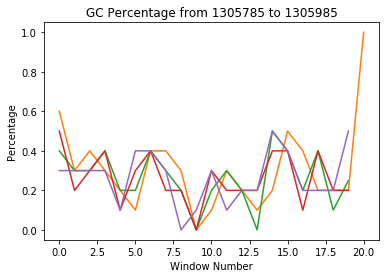

Motif locations for CG11249
AAAT: ['16', '52', '97', '125', '134', '157', '183']
AAAA: ['24', '123', '124', '187', '188', '195', '196']
TTTT: ['93', '100', '101', '102', '140', '168', '169', '170']
AAATT: ['16', '52', '97', '134']
AATTT: ['17', '53', '98']
TCAAA: ['50', '109', '181']
CAAAT: ['51', '156', '182']
TTTAA: ['55', '94', '171']
ATTTT: ['92', '99', '139']
TTTTT: ['100', '101', '168', '169']
AAAAA: ['123', '187', '195']
TGATAG: ['9', '117']
AAATTT: ['16', '52', '97']
TCAAAT: ['50', '181']
TTTAAT: ['55', '171']
AACTGT: ['66', '163']
TTCCTA: ['84', '142']
TATTTT: ['91', '138']
TTTTAA: ['93', '170']
TAAATT: ['96', '133']
TTTTTT: ['100', '168']
TAAAAA: ['186', '194']
(1305785, 1305985)


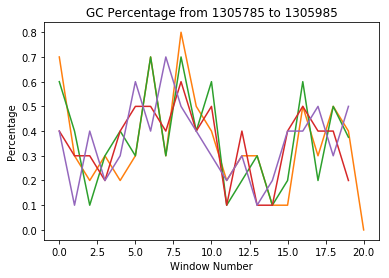

Motif locations for CG11306
TTTT: ['10', '114', '141', '157']
CGAT: ['17', '89', '98', '133']
TAAA: ['37', '41', '117', '144', '151', '176']
TAAAT: ['37', '151', '176']
TTTTA: ['114', '141', '157']
CGATTC: ['17', '98']
GTAAAT: ['36', '175']
TAAATA: ['37', '176']
CTATTT: ['54', '111']
ATTTTA: ['113', '140']
TTTTAA: ['114', '141']
TTTAAA: ['115', '142']
TTAAAA: ['116', '143']
TAAAAG: ['117', '144']
AAGTAA: ['120', '173']
AATAGC: ['124', '178']
GTAAATA: ['36', '175']
ATTTTAA: ['113', '140']
TTTTAAA: ['114', '141']
TTTAAAA: ['115', '142']
TTAAAAG: ['116', '143']
ATTTTAAA: ['113', '140']
TTTTAAAA: ['114', '141']
TTTAAAAG: ['115', '142']
ATTTTAAAA: ['113', '140']
TTTTAAAAG: ['114', '141']
ATTTTAAAAG: ['113', '140']
(1305785, 1305985)


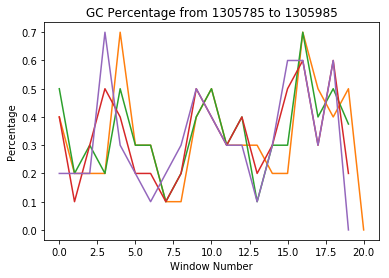

Motif locations for CG11307
CTTA: ['13', '63', '69', '143', '176']
ATAC: ['28', '51', '123', '140', '181']
ATTA: ['33', '58', '72', '82', '134']
TTAT: ['59', '64', '70', '80', '144']
TATT: ['71', '81', '92', '133', '145']
GTATA: ['26', '121', '138']
TATAC: ['27', '50', '122', '139']
CTTAT: ['63', '69', '143']
TTATT: ['70', '80', '144']
TATTA: ['71', '81', '133']
AGTATA: ['25', '137']
GTATAC: ['26', '121', '138']
ATTAAT: ['33', '72']
TTAATT: ['34', '73']
CTTATT: ['69', '143']
TTATTA: ['70', '80']
TATTAG: ['81', '133']
AGTATAC: ['25', '137']
ATTAATT: ['33', '72']
(1305785, 1305985)


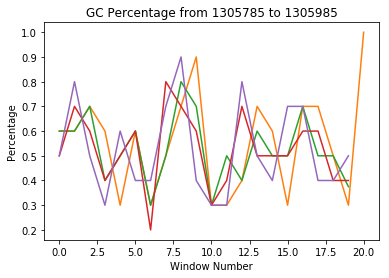

Motif locations for CG11367
TTTC: ['32', '41', '67', '73', '117']
TTGT: ['53', '187', '190', '193', '196']
GTTG: ['110', '186', '189', '192', '195']
TGTTG: ['109', '188', '191', '194']
GTTGT: ['186', '189', '192', '195']
TTGTT: ['187', '190', '193']
GTTGTT: ['186', '189', '192']
TTGTTG: ['187', '190', '193']
TGTTGT: ['188', '191', '194']
GTTGTTG: ['186', '189', '192']
TTGTTGT: ['187', '190', '193']
TGTTGTT: ['188', '191']
GTTGTTGT: ['186', '189', '192']
TTGTTGTT: ['187', '190']
TGTTGTTG: ['188', '191']
GTTGTTGTT: ['186', '189']
TTGTTGTTG: ['187', '190']
TGTTGTTGT: ['188', '191']
GTTGTTGTTG: ['186', '189']
TTGTTGTTGT: ['187', '190']
(1305785, 1305985)


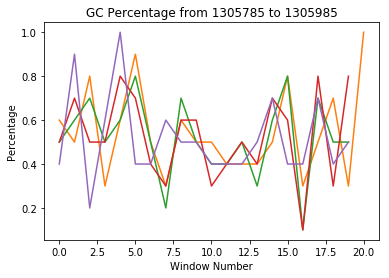

Motif locations for CG11370
ACTG: ['5', '10', '89', '117']
CTGA: ['6', '11', '90', '118']
GGGG: ['24', '25', '50', '55']
GGAG: ['57', '71', '102', '178']
ACTGA: ['5', '10', '89', '117']
CGGGG: ['23', '49', '54']
ACTGAA: ['5', '117']
ATACGC: ['81', '172']
TACGCG: ['82', '173']
CACTGA: ['88', '116']
ATACGCG: ['81', '172']
(1305785, 1305985)


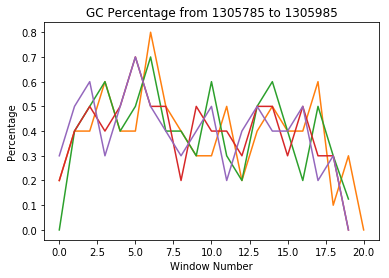

Motif locations for CG11404
AAAA: ['3', '4', '5', '6', '92', '100']
AATA: ['8', '42', '126']
ATAC: ['11', '127', '165']
TACT: ['50', '128', '166']
TCTT: ['72', '120', '153']
CATA: ['89', '112', '162']
GAAT: ['117', '146', '184']
ATTT: ['180', '186', '197']
AAAAA: ['3', '4', '5']
AAAAAA: ['3', '4']
ATATAC: ['9', '163']
ATCTTA: ['71', '119']
TCTTAC: ['72', '120']
TTCCAA: ['131', '188']
ATCTTAC: ['71', '119']
(1305785, 1305985)


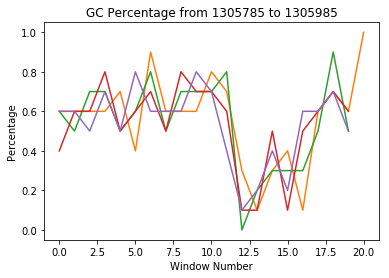

Motif locations for CG11425
CTCG: ['0', '8', '64', '113', '186']
TCGG: ['1', '65', '76', '187']
CGGG: ['2', '66', '99', '188']
TCGA: ['9', '30', '70', '114', '176']
GATT: ['11', '18', '122', '155']
CACT: ['44', '51', '111', '151']
GGCT: ['62', '101', '184', '190']
ATTA: ['123', '126', '161', '164']
TATT: ['125', '142', '160', '163']
CTCGG: ['0', '64', '186']
TCGGG: ['1', '65', '187']
GGCTC: ['62', '101', '184']
GGGCT: ['100', '183', '189']
TTATT: ['124', '141', '162']
TATTA: ['125', '160', '163']
CTCGGG: ['0', '64', '186']
TCGGGT: ['1', '65']
CGGATT: ['16', '120']
GGCCCA: ['40', '107']
GCCCAC: ['41', '108']
CCCACT: ['42', '109']
GTCACT: ['49', '149']
TCACTG: ['50', '150']
CACTGA: ['51', '151']
ACTGAT: ['52', '152']
GGCTCG: ['62', '184']
GCTCGG: ['63', '185']
GTCGAA: ['69', '175']
CGGGCT: ['99', '188']
GGGCTC: ['100', '183']
ATTATT: ['123', '161']
TTATTA: ['124', '162']
CTCGGGT: ['0', '64']
GGCCCAC: ['40', '107']
GCCCACT: ['41', '108']
GTCACTG: ['49', '149']
TCACTGA: ['50', '150']
CACTG

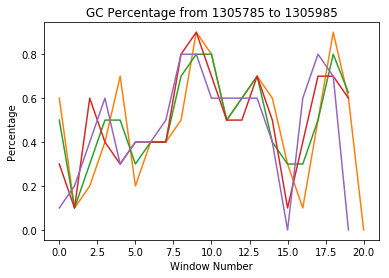

Motif locations for CG11426
TTCG: ['0', '60', '65', '70', '112', '175']
TCGC: ['1', '43', '89', '95']
CGCT: ['2', '44', '92', '169']
TGGC: ['5', '31', '102', '123']
CTTT: ['8', '35', '57', '157']
TTTA: ['9', '36', '159', '164']
TTAA: ['10', '18', '160', '165']
TAAT: ['11', '19', '50', '161']
TCGT: ['61', '71', '113', '141']
CGTT: ['62', '72', '114', '142']
GTTT: ['63', '73', '78', '143']
GTCG: ['88', '106', '134', '140']
TTTAA: ['9', '159', '164']
TTAAT: ['10', '18', '160']
TAATT: ['11', '50', '161']
TTCGT: ['60', '70', '112']
TCGTT: ['61', '71', '113', '141']
CGTTT: ['62', '72', '142']
CGTCG: ['87', '105', '139']
TCGCTG: ['1', '43']
CGCTGG: ['2', '44']
TTTAAT: ['9', '159']
TTAATT: ['10', '160']
TAATTA: ['11', '50']
AATTAG: ['12', '51']
GCTCGC: ['41', '93']
TTCGTT: ['60', '70', '112']
TCGTTT: ['61', '71', '141']
CGTTTG: ['72', '142']
GTTTGG: ['73', '143']
GGCGTC: ['103', '137']
GCGTCG: ['104', '138']
TCGCTGG: ['1', '43']
TTTAATT: ['9', '159']
TAATTAG: ['11', '50']
TTCGTTT: ['60', '70']

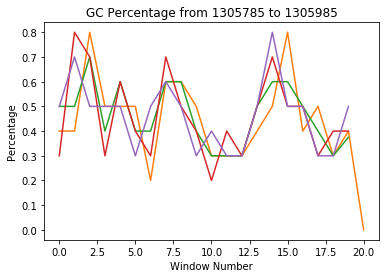

Motif locations for CG11437
TTTC: ['0', '40', '67', '113', '135']
TTGC: ['62', '130', '164', '175']
TGCT: ['98', '131', '165', '176', '186']
TTGCT: ['130', '164', '175']
TTTCAC: ['0', '113']
TTCACA: ['1', '114']
GCCGTG: ['81', '150']
ACAAAC: ['104', '117']
TTGTTT: ['110', '125']
TTGCTT: ['130', '164']
TTTCACA: ['0', '113']
(1305785, 1305985)


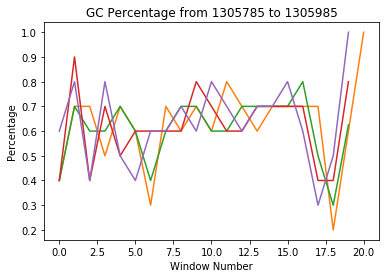

Motif locations for CG11438
CTCG: ['20', '39', '121', '168']
TCGC: ['21', '88', '122', '169']
GCTG: ['47', '79', '82', '176']
CAGC: ['72', '125', '143', '174']
TGTT: ['178', '181', '187', '193']
CTCGC: ['20', '121', '168']
CTCTC: ['115', '117', '119']
TGTTG: ['178', '187', '193']
CCTCGC: ['19', '167']
GCGCTT: ['58', '127']
CTCTCT: ['115', '117']
TCTCTC: ['116', '118']
CTCGCA: ['121', '168']
CTCTCTC: ['115', '117']
(1305785, 1305985)


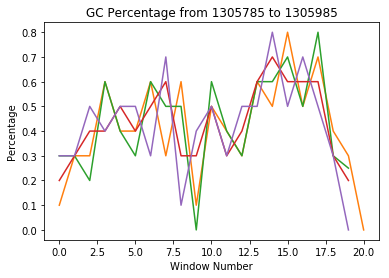

Motif locations for CG11449
AATG: ['8', '14', '24']
AAAT: ['13', '23', '94']
TGAG: ['19', '54', '62', '84', '110']
GAAA: ['22', '88', '186', '196']
ACTA: ['41', '114', '189']
CTAT: ['42', '69', '190']
CAAG: ['49', '76', '131']
ATGA: ['53', '61', '71']
AGCC: ['64', '151', '163']
AACA: ['74', '90', '129']
ACAA: ['75', '91', '130']
AAAC: ['89', '100', '187']
AACAA: ['74', '90', '129']
ATGCAA: ['9', '167']
AAATGT: ['13', '23']
AACTAT: ['40', '188']
TGAGGA: ['54', '84']
AACAAG: ['74', '129']
(1305785, 1305985)


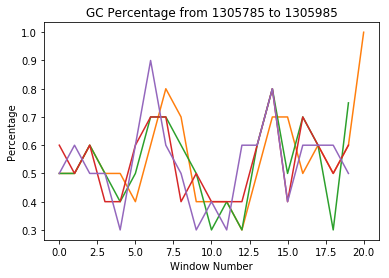

Motif locations for CG12768
CGTT: ['2', '119', '172', '182']
CGCT: ['24', '71', '76', '152']
GCTG: ['25', '72', '77', '84', '153']
CTGC: ['38', '59', '73', '85', '154']
CGCTG: ['24', '71', '76', '152']
CTGCG: ['59', '73', '85']
GCTGC: ['72', '84', '153']
CGTTCT: ['2', '172']
CTGCGC: ['59', '73']
CCCGCT: ['69', '150']
CCGCTG: ['70', '151']
CGCTGC: ['71', '152']
GCTGCG: ['72', '84']
CCCGCTG: ['69', '150']
CCGCTGC: ['70', '151']
CCCGCTGC: ['69', '150']
(1305785, 1305985)


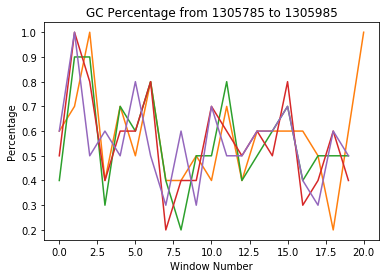

Motif locations for CG13239
GCCG: ['0', '17', '113', '143']
CGCC: ['16', '112', '142', '161']
ACGC: ['31', '111', '141', '189']
CGCCG: ['16', '112', '142']
AACGC: ['110', '140', '188']
CGCTCC: ['67', '190']
AAAACA: ['76', '99']
AACGCC: ['110', '140']
ACGCCG: ['111', '141']
AACGCCG: ['110', '140']
(1305785, 1305985)


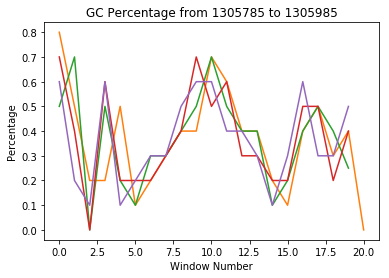

Motif locations for CG14448
GATT: ['9', '70', '83', '191']
CAAA: ['22', '53', '78', '177']
AAAT: ['23', '47', '57', '66', '149']
AATT: ['24', '28', '144', '150']
TTTT: ['30', '31', '157', '185', '186', '193', '194']
AAAA: ['54', '55', '56', '178']
TTGT: ['152', '159', '163', '171']
ATTTT: ['29', '156', '192']
TTTTT: ['30', '185', '193']
CCCTTC: ['0', '104']
ATTTTT: ['29', '192']
AGTAAG: ['124', '132']
(1305785, 1305985)


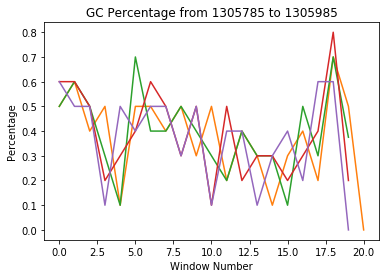

Motif locations for CG14452
TTAT: ['40', '112', '145']
TATA: ['41', '146', '158']
TTAG: ['50', '89', '97']
TAGG: ['51', '81', '90']
AACC: ['64', '149', '178']
GTTA: ['88', '96', '137', '144']
TGAT: ['106', '128', '170']
GATA: ['107', '129', '171']
ATAT: ['108', '157', '159']
ATAA: ['130', '147', '172']
TGATA: ['106', '128', '170']
TTGAAT: ['1', '153']
TTGTTA: ['86', '94']
TGTTAG: ['87', '95']
ATGATA: ['127', '169']
TGATAA: ['128', '170']
TTGTTAG: ['86', '94']
ATGATAA: ['127', '169']
(1305785, 1305985)


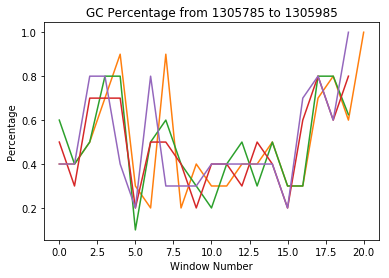

Motif locations for CG14456
TGGG: ['2', '69', '74', '197']
ACTT: ['23', '108', '150', '159']
CTTA: ['94', '109', '151', '160']
ACTTA: ['108', '150', '159']
TTGACT: ['105', '156']
TGACTT: ['106', '157']
GACTTA: ['107', '158']
ACTTAG: ['108', '150']
TTGACTT: ['105', '156']
TGACTTA: ['106', '157']
TTGACTTA: ['105', '156']
(1305785, 1305985)


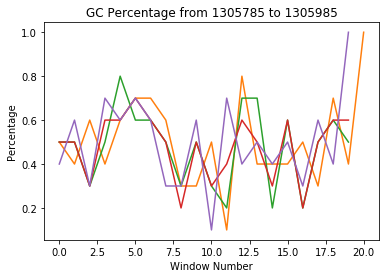

Motif locations for CG14457
TTTG: ['7', '17', '30', '135']
ATTT: ['15', '29', '108', '116', '171']
GGAA: ['35', '84', '95', '141']
ATTTT: ['15', '108', '116']
CGATTT: ['13', '106']
GATTTT: ['14', '107']
AAATGG: ['80', '91']
AATGGA: ['81', '92']
ATGGAA: ['82', '93']
ATTTTC: ['108', '116']
CGGCAT: ['126', '186']
CGATTTT: ['13', '106']
AAATGGA: ['80', '91']
AATGGAA: ['81', '92']
AAATGGAA: ['80', '91']
(1305785, 1305985)


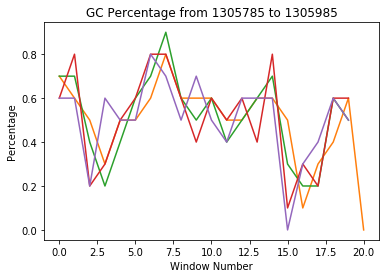

Motif locations for CG14561
TCTG: ['2', '13', '62', '98']
CTGG: ['3', '7', '44', '115']
CTGC: ['14', '54', '63', '67', '71', '99']
CCTG: ['53', '66', '70', '134']
TCTGC: ['13', '62', '98']
CCTGC: ['53', '66', '70']
CCTGCG: ['53', '70']
CTGCGT: ['54', '71']
CTGCCT: ['63', '67']
TGCCTG: ['64', '68']
GCCTGC: ['65', '69']
CTTCGC: ['87', '194']
AAATCT: ['95', '165']
TCAAGC: ['128', '183']
CAAGCC: ['129', '184']
CCTGCGT: ['53', '70']
CTGCCTG: ['63', '67']
TGCCTGC: ['64', '68']
TCAAGCC: ['128', '183']
CTGCCTGC: ['63', '67']
(1305785, 1305985)


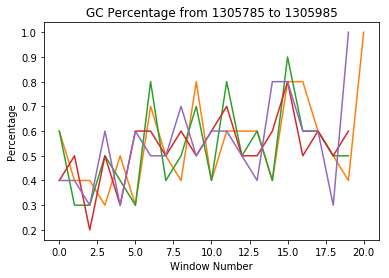

Motif locations for CG14562
AGAA: ['15', '143', '170', '180', '193']
CAGA: ['56', '104', '142', '167', '179']
GAAT: ['74', '124', '144', '194']
ACAGA: ['55', '103', '141']
GGCAG: ['153', '165', '177']
TTCACT: ['5', '33']
TCACTG: ['6', '34']
ACAGAC: ['55', '103']
CAGACT: ['56', '104']
GAATGG: ['74', '194']
CACAGA: ['102', '140']
GGCAGA: ['165', '177']
TTCACTG: ['5', '33']
ACAGACT: ['55', '103']
(1305785, 1305985)


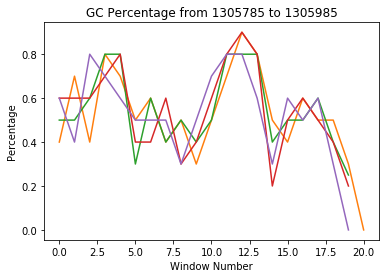

Motif locations for CG14564
GTGC: ['16', '29', '46', '177']
TGCC: ['30', '47', '82', '119', '131']
GCTG: ['36', '39', '117', '129']
CTGC: ['37', '81', '118', '130']
CGCT: ['52', '116', '122', '128']
GAAT: ['90', '181', '187', '193']
GCTGC: ['36', '117', '129']
CCGCT: ['51', '121', '127']
CTGCC: ['81', '118', '130']
TAACGG: ['20', '98']
AACGGT: ['21', '99']
GTGCCC: ['29', '46']
CCCGCT: ['50', '126']
CGTCGC: ['113', '134']
CGCTGC: ['116', '128']
GCTGCC: ['117', '129']
CTGCCG: ['118', '130']
CGAATC: ['180', '186']
TAACGGT: ['20', '98']
CGCTGCC: ['116', '128']
GCTGCCG: ['117', '129']
CGCTGCCG: ['116', '128']
(1305785, 1305985)


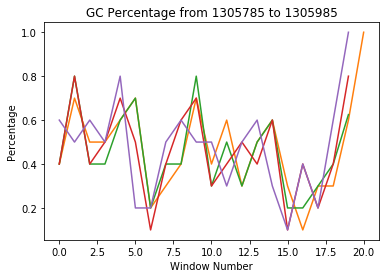

Motif locations for CG14572
TCGA: ['9', '80', '86', '127', '138']
GATT: ['23', '38', '140', '159']
TTTT: ['65', '165', '176', '177']
ATCGA: ['85', '126', '137']
GATTTA: ['23', '159']
TTTGTT: ['178', '182']
TTGTTT: ['179', '183']
TTTGTTT: ['178', '182']
(1305785, 1305985)


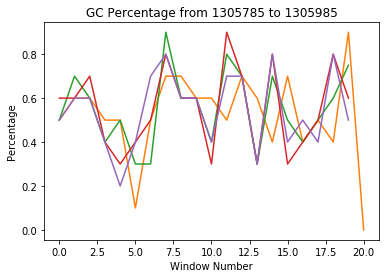

Motif locations for CG14573
GTGG: ['4', '16', '77', '100']
GTGC: ['19', '24', '133', '174']
CGCC: ['119', '129', '150', '192']
TGCTG: ['20', '25', '84']
CGCCG: ['129', '150', '192']
CAGTGG: ['14', '98']
AGTGGT: ['15', '99']
GTGCTG: ['19', '24']
TGCTGT: ['20', '25']
ACAACG: ['68', '125']
AAGCAG: ['142', '185']
GCGCCG: ['149', '191']
CGCCGC: ['150', '192']
CAGTGGT: ['14', '98']
GTGCTGT: ['19', '24']
GCGCCGC: ['149', '191']
(1305785, 1305985)


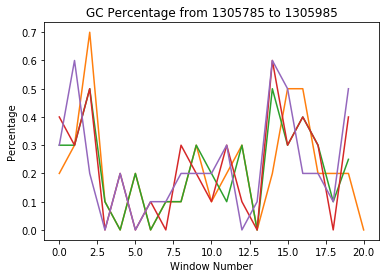

Motif locations for CG32441
TATT: ['2', '74', '112', '131', '134', '139', '191']
ATTT: ['3', '34', '75', '80', '88', '113', '135', '140', '184', '192']
AAAA: ['17', '59', '60', '61', '62', '63', '64']
TTTA: ['38', '76', '81', '89', '119', '137', '141', '169', '185', '193']
ATAT: ['41', '43', '45', '100', '106', '111', '190']
TATTT: ['2', '74', '112', '134', '139', '191']
AAAAA: ['59', '60', '61', '62', '63']
ATTTA: ['75', '80', '88', '140', '184', '192']
TATATA: ['40', '42', '44']
AAAAAA: ['59', '60', '61', '62']
TATTTA: ['74', '139', '191']
ATTTAA: ['75', '88', '140', '184']
TATTTCT: ['2', '112']
TATATAT: ['40', '42']
ATATATA: ['41', '43']
AAAAAAA: ['59', '60', '61']
TATTTAA: ['74', '139']
ATTTAAA: ['140', '184']
TATATATA: ['40', '42']
AAAAAAAA: ['59', '60']
(1305785, 1305985)


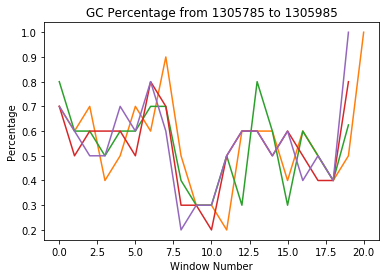

Motif locations for CG32444
TCTC: ['8', '14', '145', '190']
CAAA: ['31', '122', '152', '158']
AAGT: ['97', '124', '154', '182']
TCAAA: ['30', '151', '157']
AAGTC: ['124', '154', '182']
GTCTCG: ['7', '13']
CCCTCA: ['27', '148']
CCTCAA: ['28', '149']
CTCAAA: ['29', '150']
TCAAAC: ['30', '157']
TGTCAG: ['57', '176']
GTTTAC: ['88', '99']
TTTACT: ['89', '100']
TTACTA: ['90', '101']
TACTAC: ['91', '102']
CAAAGT: ['122', '152']
AAAGTC: ['123', '153']
AAGTCG: ['124', '182']
CCCTCAA: ['27', '148']
CCTCAAA: ['28', '149']
GTTTACT: ['88', '99']
TTTACTA: ['89', '100']
TTACTAC: ['90', '101']
CAAAGTC: ['122', '152']
CCCTCAAA: ['27', '148']
GTTTACTA: ['88', '99']
TTTACTAC: ['89', '100']
GTTTACTAC: ['88', '99']
(1305785, 1305985)


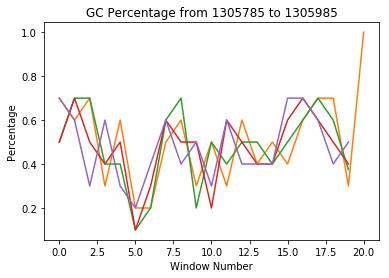

Motif locations for CG32445
TAGA: ['11', '50', '71']
GCTG: ['17', '20', '82']
CTGC: ['18', '75', '171', '180', '186']
TGCC: ['46', '181', '187']
GCCT: ['47', '182', '188']
AAAA: ['56', '112', '113']
GACT: ['73', '90', '144']
GTTG: ['79', '153', '156']
TCTG: ['100', '130', '179', '185']
CACA: ['118', '120', '135']
TGCCT: ['46', '181', '187']
CCTAGA: ['9', '48']
TCTGCC: ['179', '185']
CTGCCT: ['180', '186']
TCTGCCT: ['179', '185']
(1305785, 1305985)


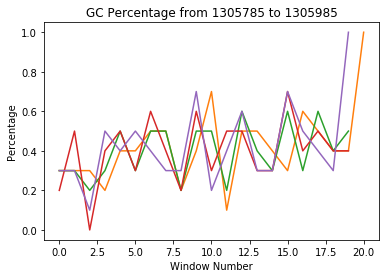

Motif locations for CG32450
AAAC: ['13', '21', '69', '189']
TTTT: ['27', '28', '86', '87']
AATG: ['34', '57', '126', '142']
GAAT: ['56', '83', '91', '125', '180']
AGAA: ['82', '139', '179', '187']
TAGAA: ['81', '138', '186']
CAAACG: ['12', '20']
AACGTA: ['14', '77']
ATTTTT: ['26', '85']
TGTGTG: ['36', '38']
GGAATG: ['55', '124']
CTAGAA: ['137', '185']
TAGAAA: ['138', '186']
CTAGAAA: ['137', '185']
(1305785, 1305985)


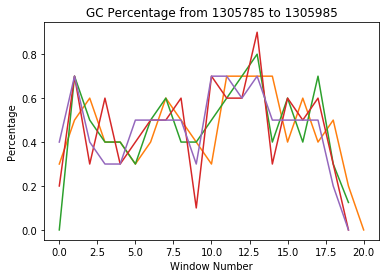

Motif locations for CG32452
TTTT: ['7', '8', '9', '10', '191']
TTTC: ['11', '46', '132', '192']
TGCC: ['92', '125', '174', '179']
GCCT: ['93', '122', '126', '140', '175']
TTTTT: ['7', '8', '9']
TGCCT: ['92', '125', '174']
GCCTG: ['122', '126', '140']
TTTTTT: ['7', '8']
CTGGAG: ['70', '142']
GGCCTG: ['121', '139']
GCCTGC: ['122', '126']
(1305785, 1305985)


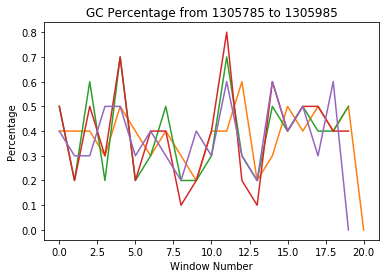

Motif locations for CG32453
TGTA: ['0', '74', '100']
GTGT: ['4', '6', '71', '73']
TGTG: ['5', '70', '72']
ATCT: ['13', '21', '43']
TAGA: ['16', '127', '187']
GAAA: ['18', '40', '129']
AAAT: ['19', '41', '110']
AATC: ['20', '42', '103']
TGGG: ['27', '46', '193']
GTTT: ['31', '67', '90']
CATG: ['64', '98', '178']
ATGT: ['65', '88', '99']
ATAT: ['86', '94', '140']
TCAG: ['148', '163', '174']
TGTGT: ['5', '70', '72']
GTGTGT: ['4', '71']
ATCTAG: ['13', '21']
TAGAAA: ['16', '127']
GAAATC: ['18', '40']
AAATCT: ['19', '41']
TTTATA: ['33', '91']
TCATGT: ['63', '97']
ATGTTT: ['65', '88']
GAAATCT: ['18', '40']
(1305785, 1305985)


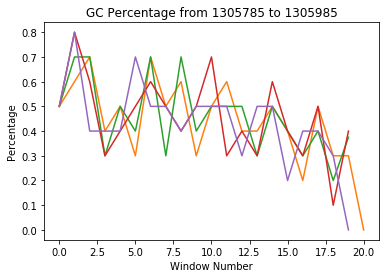

Motif locations for CG32454
GGAC: ['3', '67', '75', '110']
CAAA: ['8', '35', '78', '163']
AAAA: ['36', '37', '79', '134', '164']
AAAGG: ['9', '80', '124']
CAAAA: ['35', '78', '163']
TGGGAC: ['1', '65']
GACAAA: ['33', '76']
ACAAAA: ['34', '77']
ACCACT: ['99', '154']
GACAAAA: ['33', '76']
(1305785, 1305985)


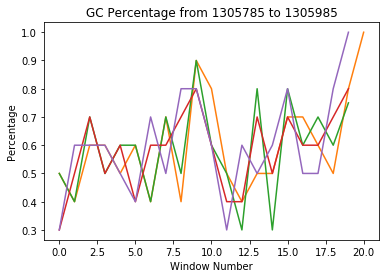

Motif locations for CG33169
GGCT: ['4', '104', '162', '166', '191']
CTGC: ['33', '97', '106', '156', '193']
GCTG: ['96', '101', '105', '155', '163', '192']
TGCGT: ['68', '74', '157']
GCGTG: ['69', '75', '158']
GCGCT: ['94', '99', '153']
CGCTG: ['95', '100', '154']
GCTGC: ['96', '105', '155', '192']
TGGCT: ['103', '161', '165']
GGCTG: ['104', '162', '191']
CAGGC: ['138', '175', '196']
TTGGGC: ['1', '132']
TCTTGA: ['13', '183']
CTGCTT: ['33', '106']
TGCTTC: ['34', '107']
CTGGTG: ['43', '112']
CGTGTG: ['50', '70']
GTGCGT: ['67', '73']
TGCGTG: ['68', '74', '157']
GCGTGG: ['75', '158']
CAACAA: ['83', '120']
GCGCTG: ['94', '99', '153']
CGCTGC: ['95', '154']
GCTGCG: ['96', '155']
GCTGGC: ['101', '163']
CTGGCT: ['102', '164']
TGGCTG: ['103', '161']
GGCTGC: ['104', '191']
CAGGCA: ['138', '175']
AAGAAG: ['143', '146']
AGAAGA: ['144', '147']
GCAGGC: ['174', '195']
CTGCTTC: ['33', '106']
GTGCGTG: ['67', '73']
TGCGTGG: ['74', '157']
GCGCTGC: ['94', '153']
CGCTGCG: ['95', '154']
GCTGGCT: ['101', '16

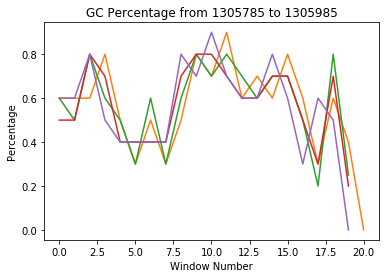

Motif locations for CG33170
GAGA: ['4', '45', '63', '94', '120', '126']
GCTG: ['9', '102', '141', '168', '188']
CTGA: ['10', '132', '142', '194']
GAGC: ['16', '96', '122', '128']
TGTG: ['42', '104', '106', '170']
AGAG: ['46', '95', '121', '127']
CGAGA: ['3', '93', '125']
GAGAG: ['45', '94', '120', '126']
AGAGC: ['95', '121', '127']
AGCTGA: ['8', '140']
GAGCCT: ['16', '128']
GTGAGA: ['43', '61']
GCAAAA: ['55', '71']
CAAAAG: ['56', '72']
GCGAGA: ['92', '124']
CGAGAG: ['93', '125']
GAGAGC: ['94', '120', '126']
AGAGCG: ['95', '121']
GCTGTG: ['102', '168']
TGCTCT: ['160', '190']
GCAAAAG: ['55', '71']
GCGAGAG: ['92', '124']
CGAGAGC: ['93', '125']
GAGAGCG: ['94', '120']
GCGAGAGC: ['92', '124']
(1305785, 1305985)


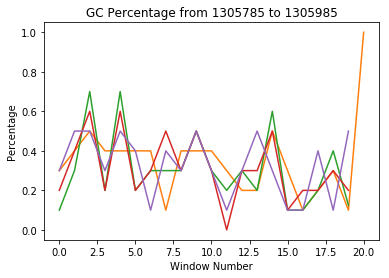

Motif locations for CG33766
ATTT: ['4', '69', '119', '153', '196']
TTTA: ['6', '39', '70', '107', '116', '120']
ATCA: ['54', '134', '166', '181', '190']
TCAA: ['55', '135', '167', '182', '191']
TGTAT: ['18', '178', '187']
GTATC: ['52', '179', '188']
TATCA: ['53', '180', '189']
ATCAA: ['54', '134', '166', '181', '190']
TCAAA: ['55', '167', '191']
CAAAA: ['56', '168', '192']
GTATCA: ['52', '179', '188']
TATCAA: ['53', '180', '189']
ATCAAA: ['54', '166', '190']
TCAAAA: ['55', '167', '191']
GTATCAA: ['52', '179', '188']
TATCAAA: ['53', '189']
ATCAAAA: ['54', '166', '190']
TAATCAA: ['132', '164']
TCAAAAT: ['167', '191']
TGTATCA: ['178', '187']
GTATCAAA: ['52', '188']
TATCAAAA: ['53', '189']
ATCAAAAT: ['166', '190']
TGTATCAA: ['178', '187']
GTATCAAAA: ['52', '188']
(1305785, 1305985)


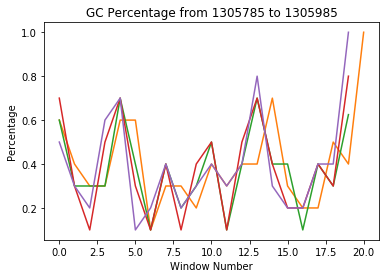

Motif locations for CG33767
TGAT: ['2', '19', '74', '156']
TAAA: ['26', '31', '59', '87']
AACT: ['28', '61', '81', '176', '191']
AAAT: ['32', '89', '98', '149']
AATT: ['33', '65', '71', '90']
ATTT: ['34', '66', '119', '169']
CCAC: ['46', '126', '141', '144']
TGATG: ['2', '19', '74']
AAACT: ['27', '60', '190']
ACTAA: ['29', '57', '62']
ATTTC: ['34', '119', '169']
CAGCC: ['43', '50', '137']
TAAACT: ['26', '59']
AAACTA: ['27', '60']
AACTAA: ['28', '61']
ACTAAA: ['29', '57']
CCAGCC: ['42', '49']
CAGCCA: ['43', '50']
CCACCA: ['46', '141']
GAAATC: ['97', '148']
TTATTT: ['117', '167']
TATTTC: ['118', '168']
TAAACTA: ['26', '59']
AAACTAA: ['27', '60']
CCAGCCA: ['42', '49']
TTATTTC: ['117', '167']
TAAACTAA: ['26', '59']
(1305785, 1305985)


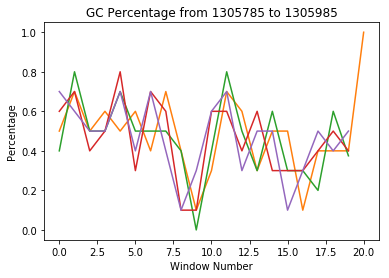

Motif locations for CG33768
TACT: ['3', '58', '101']
CAAT: ['26', '43', '128']
AATG: ['27', '44', '79', '109', '129']
TGGC: ['46', '111', '142']
AGCT: ['74', '190', '194']
ATTT: ['92', '147', '162']
AAAT: ['97', '108', '174']
TTTC: ['133', '153', '163']
GCTT: ['151', '157', '195']
CTTT: ['152', '158', '196']
CAATG: ['26', '43', '128']
GCTTT: ['151', '157', '195']
TACTTC: ['3', '101']
GCAATG: ['25', '127']
AATGGC: ['44', '109']
ATGGCG: ['45', '110']
TGGCGC: ['46', '111']
CTAGCT: ['188', '192']
AATGGCG: ['44', '109']
ATGGCGC: ['45', '110']
AATGGCGC: ['44', '109']
(1305785, 1305985)


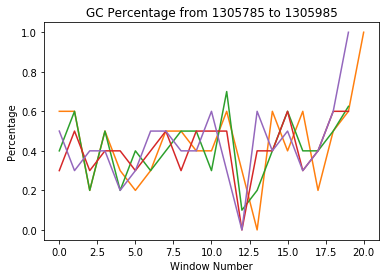

Motif locations for CG33769
GTGA: ['3', '96', '104', '175']
TGAT: ['4', '7', '105', '109']
TTTT: ['24', '41', '42', '43']
TTGT: ['75', '78', '173', '183']
TTGTT: ['75', '78', '183']
TTGTTG: ['75', '183']
GTGAAG: ['96', '175']
(1305785, 1305985)


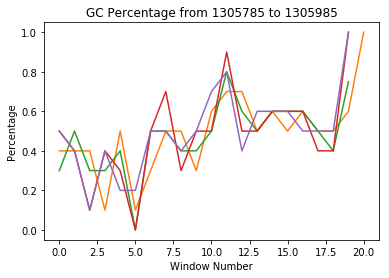

Motif locations for CG33770
AAAA: ['28', '29', '30', '31']
TCGT: ['40', '102', '108']
TCCA: ['65', '88', '152', '164', '179']
CAGC: ['67', '131', '142']
ATTG: ['73', '92', '175']
TTCA: ['111', '135', '140']
CGGC: ['121', '147', '197']
GCTT: ['133', '149', '186']
CTTC: ['134', '150', '187']
AAAAA: ['28', '29', '30']
GCTTC: ['133', '149', '186']
AAAAAA: ['28', '29']
TATCCA: ['63', '86']
CACGGC: ['119', '145']
(1305785, 1305985)


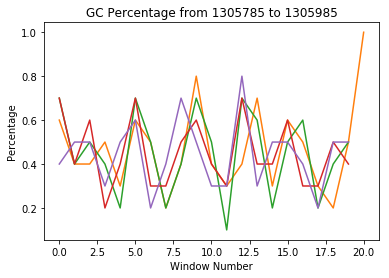

Motif locations for CG33771
TCAG: ['1', '101', '109']
GTGC: ['4', '104', '134']
CCAC: ['8', '21', '92']
ATGA: ['13', '65', '146']
TGAA: ['14', '25', '147']
AAAC: ['16', '37', '48', '82']
AACT: ['17', '49', '138']
TCCA: ['20', '79', '175', '194']
ATTA: ['43', '87', '143']
GCAT: ['63', '106', '125']
TTTC: ['77', '160', '173']
TTCC: ['78', '161', '174']
TGTA: ['116', '168', '186']
TTTCC: ['77', '160', '173']
TTCAGT: ['0', '100']
TCAGTG: ['1', '101']
CAGTGC: ['2', '102']
TTTCCA: ['77', '173']
CTTTCC: ['159', '172']
TTCAGTG: ['0', '100']
TCAGTGC: ['1', '101']
TTCAGTGC: ['0', '100']
(1305785, 1305985)


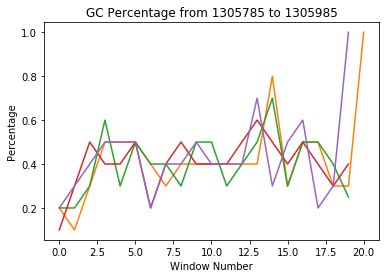

Motif locations for CG43312
AATT: ['14', '70', '90']
ATTC: ['15', '91', '128']
TCAA: ['17', '136', '160']
CAAC: ['18', '123', '161']
TGAA: ['23', '154', '182']
CAAA: ['49', '67', '137']
AAAC: ['50', '84', '138']
AAAA: ['68', '184', '195']
GAAT: ['89', '112', '155']
CATT: ['127', '151', '191']
(1305785, 1305985)


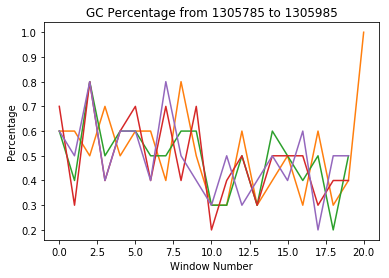

Motif locations for CG43980
GAAT: ['15', '153', '163']
TCTT: ['18', '42', '51']
GAGC: ['27', '125', '192']
AGCG: ['28', '81', '126', '169', '193']
GGCT: ['35', '84', '97']
CTTC: ['40', '43', '52']
TTCC: ['53', '77', '131']
CAGT: ['61', '74', '145', '173', '180']
AGTT: ['68', '75', '181']
TGCA: ['87', '102', '143']
CAAA: ['104', '116', '120']
GAGCG: ['27', '125', '192']
CGAGCG: ['26', '124']
GCGGCT: ['82', '95']
ACAAAC: ['115', '119']
(1305785, 1305985)


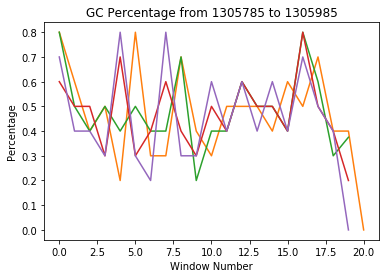

Motif locations for CG45116
GTGT: ['12', '56', '97', '116']
AAAC: ['29', '68', '160', '187']
TTTG: ['45', '94', '100', '120', '139']
TGTT: ['57', '91', '98', '117', '144']
GTTT: ['92', '99', '118', '138']
GTGTT: ['56', '97', '116']
TGTTT: ['91', '98', '117']
GTGCCT: ['14', '172']
TGCCTT: ['15', '173']
GGTGTT: ['55', '115']
TGTTTT: ['91', '117']
GTTTTG: ['92', '118']
GTGTTT: ['97', '116']
GTGCCTT: ['14', '172']
TGTTTTG: ['91', '117']
(1305785, 1305985)


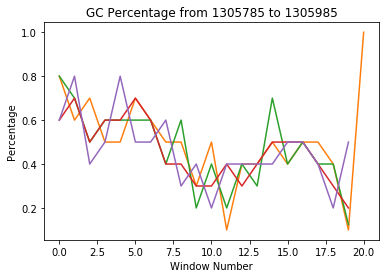

Motif locations for CG7369
CTGT: ['7', '83', '150', '187']
GAAA: ['74', '91', '127', '138']
AAAG: ['76', '99', '129', '197']
GAGG: ['88', '106', '145', '169']
AAAAG: ['75', '98', '128']
CTGGGC: ['0', '17']
GAAAAG: ['74', '127']
CTTCTG: ['80', '156']
TGGAGG: ['86', '104']
AGGAAA: ['89', '136']
GGAAAT: ['90', '137']
AGGAAAT: ['89', '136']
(1305785, 1305985)


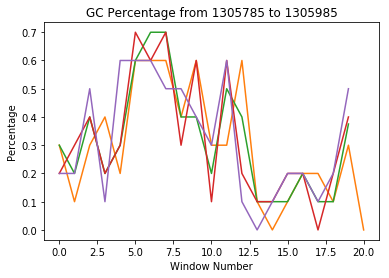

Motif locations for CG7407
TGTT: ['2', '17', '22', '43', '137', '164', '186']
TTTT: ['4', '10', '39', '40', '45', '51', '107', '108', '109', '166']
ATAT: ['132', '134', '141', '143', '145', '171', '177', '183']
TTTGT: ['0', '15', '41', '110']
TGTTT: ['2', '22', '43', '164']
TTTTG: ['40', '51', '109', '166']
TATAT: ['133', '140', '142', '144', '176', '182']
TTTGTT: ['0', '15', '41']
TGTTTT: ['2', '43', '164']
ATATAT: ['132', '141', '143']
ATATGT: ['134', '171', '183']
TTTGTTT: ['0', '41']
TTGTTTT: ['1', '42']
TGTTTTC: ['2', '43']
GTTTTCC: ['3', '44']
TTTTCCT: ['4', '45']
TTTCCTT: ['5', '46']
TTCCTTT: ['6', '47']
TCCTTTT: ['7', '48']
TTTTTGT: ['39', '108']
TATATGT: ['133', '182']
ATATGTT: ['134', '183']
TATGTTA: ['135', '184']
TATATAT: ['140', '142']
TTTGTTTT: ['0', '41']
TTGTTTTC: ['1', '42']
TGTTTTCC: ['2', '43']
GTTTTCCT: ['3', '44']
TTTTCCTT: ['4', '45']
TTTCCTTT: ['5', '46']
TTCCTTTT: ['6', '47']
TATATGTT: ['133', '182']
ATATGTTA: ['134', '183']
TTTGTTTTC: ['0', '41']
TTGTTTTCC: ['1

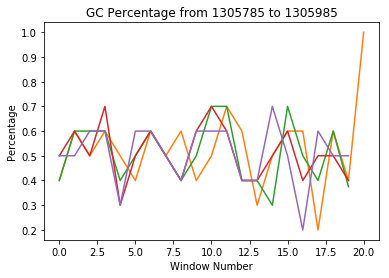

Motif locations for CG7414
CACA: ['13', '19', '21', '23', '25', '99', '101', '158']
ACAC: ['14', '20', '22', '24', '34', '100', '102']
GAAC: ['32', '132', '181', '186', '195']
GTTG: ['48', '51', '54', '78', '107']
CACAC: ['13', '19', '21', '23', '99', '101']
ACACA: ['20', '22', '24', '100']
TGTTG: ['47', '50', '53', '77']
CACACA: ['19', '21', '23', '99']
ACACAC: ['20', '22', '100']
TGTTGT: ['47', '50', '53']
ACACGCA: ['14', '34']
CACGCAC: ['15', '35']
CACACAC: ['19', '21', '99']
ACACACA: ['20', '22']
TGTTGTT: ['47', '50']
GTTGTTG: ['48', '51']
TTGTTGT: ['49', '52']
AACCGAA: ['177', '182']
ACCGAAC: ['178', '183']
ACACGCAC: ['14', '34']
CACACACA: ['19', '21']
TGTTGTTG: ['47', '50']
GTTGTTGT: ['48', '51']
AACCGAAC: ['177', '182']
TGTTGTTGT: ['47', '50']
(1305785, 1305985)


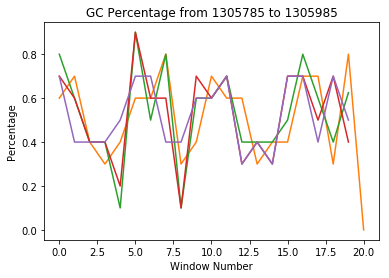

Motif locations for CG7458
CCGC: ['8', '60', '71']
CGCG: ['9', '55', '61']
GCGA: ['10', '62', '105']
TCGG: ['39', '76', '163', '189']
TTTA: ['46', '84', '88']
TTAT: ['47', '85', '89', '129']
CGGC: ['57', '77', '190']
CTTT: ['67', '83', '182']
CGCT: ['96', '170', '193']
GCTC: ['97', '171', '194']
GGAG: ['102', '116', '166']
GAGC: ['103', '117', '167']
TTTAT: ['46', '84', '88']
CGCTC: ['96', '170', '193']
GGAGC: ['102', '116', '166']
CCGCGA: ['8', '60']
TTTATA: ['46', '88']
CGCTCT: ['96', '170']
GCTCTG: ['97', '171']
GGAGCG: ['102', '166']
GGGAGC: ['115', '165']
TGATTC: ['137', '185']
GCGCTC: ['169', '192']
CGCTCTG: ['96', '170']
(1305785, 1305985)


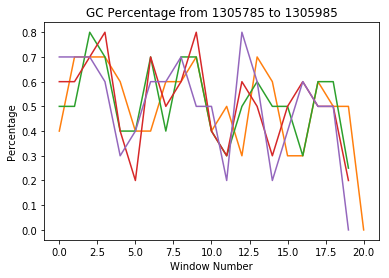

Motif locations for CG7458_alpha
CCGG: ['10', '97', '145', '158']
CGGC: ['11', '67', '171', '181']
ACGC: ['34', '41', '131', '189']
ACGCC: ['34', '41', '131']
ACGGC: ['66', '170', '180']
ACTGAA: ['3', '137']
GACGCC: ['33', '40']
ACGCCC: ['41', '131']
TTAATT: ['47', '151']
TAATTG: ['48', '152']
ACGGCG: ['66', '170']
CCGGAT: ['145', '158']
CGGATT: ['146', '159']
AACGGC: ['169', '179']
TTAATTG: ['47', '151']
CCGGATT: ['145', '158']
(1305785, 1305985)


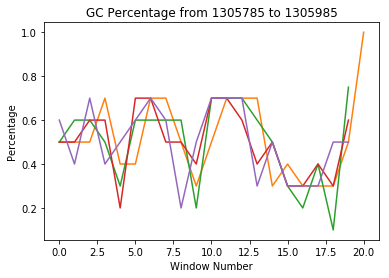

Motif locations for CG7470
GGAA: ['32', '57', '68', '151']
GAAC: ['33', '58', '69', '106']
ACGG: ['37', '55', '66', '112']
CGGA: ['38', '56', '67', '113']
ACCG: ['71', '76', '108', '120']
ATGTG: ['25', '145', '158']
GGAAC: ['32', '57', '68']
ACGGA: ['37', '55', '66', '112']
ATGTGG: ['25', '145']
TGTGGG: ['26', '146']
GTGGGG: ['27', '147']
GGGGAA: ['30', '149']
CACGGA: ['36', '54']
ACGGAA: ['55', '66']
CGGAAC: ['56', '67']
GAACCG: ['69', '106']
TGGTCG: ['127', '134']
ATGTGGG: ['25', '145']
TGTGGGG: ['26', '146']
ACGGAAC: ['55', '66']
ATGTGGGG: ['25', '145']
(1305785, 1305985)


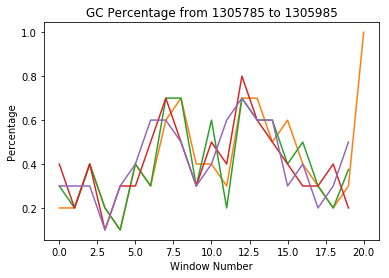

Motif locations for CG7519
TTTA: ['0', '97', '115', '195']
TTTT: ['4', '67', '68', '114']
TGCC: ['7', '71', '123', '142']
CCAA: ['9', '29', '157', '169']
CAAA: ['10', '15', '30', '170']
AAAA: ['11', '45', '46', '47', '171']
AAAT: ['16', '35', '48', '172']
CTGC: ['89', '122', '130', '141']
CCAAA: ['9', '29', '169']
TGCCG: ['71', '123', '142']
CACTG: ['87', '120', '139']
ACTGC: ['88', '121', '140']
TTTTGC: ['4', '68']
TTTGCC: ['5', '69']
CCAAAA: ['9', '169']
CTTCCA: ['26', '166']
TTCCAA: ['27', '167']
TCCAAA: ['28', '168']
AAAATC: ['47', '171']
TTCGTT: ['57', '191']
TGCCGA: ['71', '142']
CACACT: ['85', '137']
ACACTG: ['86', '138']
CACTGC: ['87', '120', '139']
ACTGCC: ['121', '140']
CTGCCG: ['122', '141']
GATAAG: ['177', '182']
ATAAGA: ['178', '183']
TTTTGCC: ['4', '68']
CTTCCAA: ['26', '166']
TTCCAAA: ['27', '167']
CACACTG: ['85', '137']
ACACTGC: ['86', '138']
CACTGCC: ['120', '139']
ACTGCCG: ['121', '140']
GATAAGA: ['177', '182']
CTTCCAAA: ['26', '166']
CACACTGC: ['85', '137']
CACTGCCG:

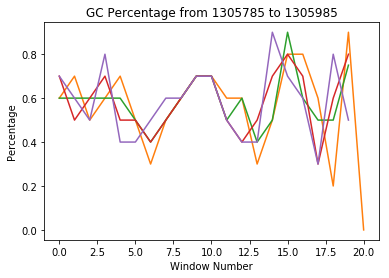

Motif locations for CG7611
TTGC: ['2', '22', '52', '188']
TGCT: ['3', '23', '26', '53', '104', '139', '148']
GCTG: ['24', '27', '54', '105', '140', '149']
GTGG: ['41', '82', '121', '166']
CTGT: ['55', '59', '113', '141']
GTTGC: ['1', '21', '51']
TTGCT: ['2', '22', '52']
TGCTG: ['23', '26', '53', '104', '139', '148']
GCTGG: ['27', '105', '149']
TGGTG: ['29', '80', '136']
CTGTC: ['55', '59', '113']
GTTGCT: ['1', '21', '51']
TGTTGC: ['20', '50']
TTGCTG: ['22', '52']
CTGCTG: ['25', '147']
TGCTGG: ['26', '104', '148']
TGCTGT: ['53', '139']
CTGTCG: ['59', '113']
TGTCGA: ['60', '114']
TTGGTG: ['79', '135']
GGATGC: ['93', '168']
GTGCTG: ['103', '138']
GCTGGG: ['105', '149']
TGTTGCT: ['20', '50']
GTTGCTG: ['21', '51']
CTGCTGG: ['25', '147']
CTGTCGA: ['59', '113']
TGCTGGG: ['104', '148']
TGTTGCTG: ['20', '50']
(1305785, 1305985)


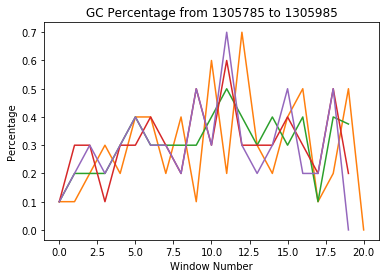

Motif locations for CG7634
ATTT: ['3', '39', '129', '141', '171']
TTTT: ['8', '9', '10', '11', '12', '17', '25', '26', '27', '130', '178', '197']
CAAA: ['47', '69', '78', '96', '146']
CTTTT: ['7', '177', '196']
TTTTT: ['8', '9', '10', '11', '25', '26']
TTTTG: ['12', '17', '130']
TTTGT: ['13', '18', '131']
TTGTT: ['14', '19', '22']
TTCAA: ['29', '73', '94']
CAAAT: ['69', '96', '146']
ATGGT: ['99', '149', '157']
ATATTT: ['1', '37']
TCTTTT: ['6', '176']
TTTTTT: ['8', '9', '10', '25']
TTTTGT: ['12', '17', '130']
TTTGTT: ['13', '18']
TTGTTT: ['14', '22']
TGTTTT: ['15', '23']
TTCAAC: ['29', '73']
AACAAA: ['45', '76']
ATTCAA: ['72', '93']
CAAATG: ['96', '146']
AAATGG: ['97', '147']
AATGGT: ['98', '148']
ATCCCA: ['118', '165']
TTTTTTT: ['8', '9']
TTTTGTT: ['12', '17']
TTGTTTT: ['14', '22']
CAAATGG: ['96', '146']
AAATGGT: ['97', '147']
CAAATGGT: ['96', '146']
(1305785, 1305985)


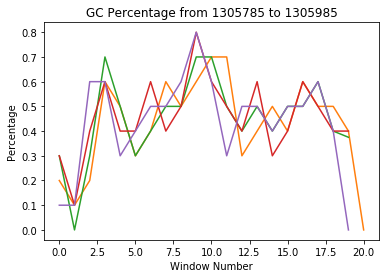

Motif locations for CG9300
AAAA: ['14', '19', '20', '137']
ACAC: ['32', '107', '128', '130', '132']
CGAT: ['50', '79', '110', '187']
TCGA: ['59', '69', '78', '153', '186']
ATCG: ['68', '77', '121', '152']
CACA: ['94', '106', '129', '131']
TATCG: ['67', '76', '120']
ATCGA: ['68', '77', '152']
CACAC: ['106', '129', '131']
TATCGA: ['67', '76']
ATCGAC: ['68', '152']
GCTATC: ['74', '118']
CTATCG: ['75', '119']
ACACAC: ['128', '130']
GCTATCG: ['74', '118']
(1305785, 1305985)


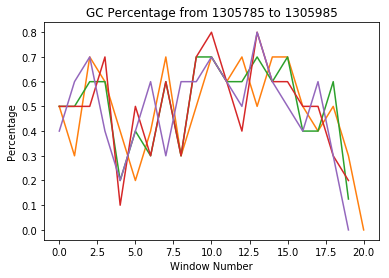

Motif locations for CG9330
GACC: ['3', '107', '159']
ATCG: ['10', '18', '119']
TCGG: ['19', '41', '120']
CTTT: ['24', '56', '65']
ACTT: ['55', '64', '168']
TTTT: ['57', '66', '175']
TTCC: ['59', '135', '170', '180']
ACCG: ['75', '108', '160']
CCGT: ['109', '161', '172']
(1305785, 1305985)


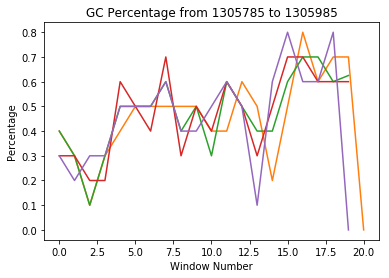

Motif locations for CG9368
TTTG: ['12', '35', '65', '71', '101', '110', '118']
CTTT: ['34', '64', '70', '109']
TGCG: ['78', '114', '179', '190']
TTTGT: ['12', '71', '110']
CTTTG: ['34', '64', '70', '109']
TGCGT: ['114', '179', '190']
TTTGTG: ['12', '110']
CCTTTG: ['33', '69']
TTTGCC: ['65', '118']
CTTTGT: ['70', '109']
TGCGTG: ['179', '190']
(1305785, 1305985)


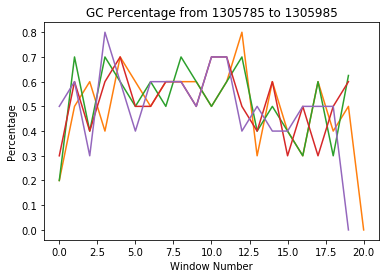

Motif locations for CG9372
TTTG: ['0', '138', '156', '183']
TTTT: ['9', '28', '155', '182', '189']
CACT: ['21', '77', '92', '149', '179']
ACTT: ['78', '130', '161', '180']
ACGA: ['87', '108', '111', '134']
GCACT: ['20', '76', '91']
CACTG: ['21', '92', '149']
CTGCT: ['67', '94', '151']
GACGA: ['86', '107', '110']
GTGCAC: ['18', '74']
TGCACT: ['19', '75']
GCACTG: ['20', '91']
TGGGTT: ['24', '185']
GGGTTT: ['25', '186']
GGTTTT: ['26', '187']
CGCTTC: ['41', '62']
AGCTGA: ['54', '114']
CTGCTC: ['67', '94']
CTCCGA: ['82', '97']
CGACGA: ['85', '109']
GACGAG: ['86', '110']
ACGAGC: ['87', '111']
CACTGC: ['92', '149']
ACTGCT: ['93', '150']
GACACT: ['147', '177']
CTTTTG: ['154', '181']
GTGCACT: ['18', '74']
TGGGTTT: ['24', '185']
GGGTTTT: ['25', '186']
CGACGAG: ['85', '109']
GACGAGC: ['86', '110']
CACTGCT: ['92', '149']
TGGGTTTT: ['24', '185']
CGACGAGC: ['85', '109']
(1305785, 1305985)


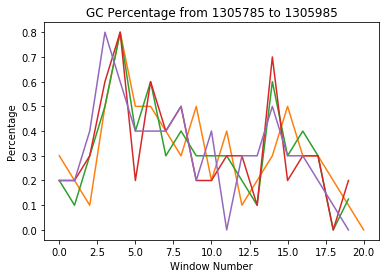

Motif locations for CG9376
TAAA: ['3', '13', '25', '99', '108', '123']
TTTT: ['20', '61', '62', '187', '192', '193']
AAAA: ['26', '100', '119', '124', '125']
GTTAA: ['1', '11', '97']
TTAAA: ['2', '12', '98']
AAATA: ['4', '14', '120']
TTTTC: ['20', '62', '193']
TAAAA: ['25', '99', '123']
TATTT: ['135', '185', '190']
GTTAAA: ['1', '11', '97']
TTAAAT: ['2', '12']
TAAATA: ['3', '13']
AAATAC: ['4', '14']
AGTTAA: ['10', '96']
TTTTTC: ['61', '192']
GATTAC: ['83', '166']
GAACTA: ['104', '131']
TTGGCA: ['114', '148']
TTATTT: ['184', '189']
TATTTT: ['185', '190']
GTTAAAT: ['1', '11']
TTAAATA: ['2', '12']
TAAATAC: ['3', '13']
AGTTAAA: ['10', '96']
TTATTTT: ['184', '189']
GTTAAATA: ['1', '11']
TTAAATAC: ['2', '12']
GTTAAATAC: ['1', '11']
(1305785, 1305985)


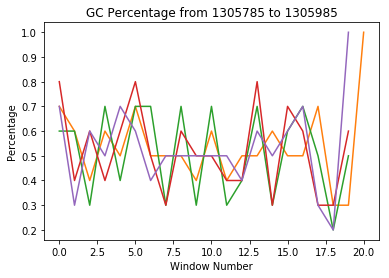

Motif locations for CS
GGCA: ['15', '33', '47', '63']
ATCG: ['19', '60', '68', '98', '123']
CGAT: ['58', '91', '100', '143']
(1305785, 1305985)


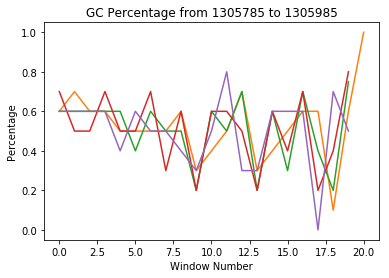

Motif locations for Cdk12
CTCG: ['8', '26', '103', '163']
GGTT: ['15', '63', '74']
ACTC: ['25', '49', '102']
TCGC: ['27', '91', '191']
TTTT: ['76', '97', '98', '135', '136', '137', '158']
TTTC: ['77', '138', '159']
TATT: ['95', '180', '183']
ATTT: ['96', '157', '184']
TTAC: ['100', '142', '186']
TTTTC: ['76', '137', '158']
TTTTT: ['97', '135', '136']
ATCGCT: ['90', '190']
(1305785, 1305985)


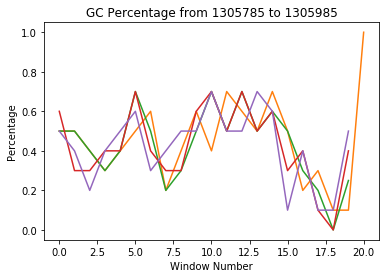

Motif locations for Cpr76Bb
TCGA: ['1', '26', '102']
CACT: ['6', '64', '172']
TGTT: ['16', '160', '195']
GTTT: ['17', '72', '196']
ATCG: ['25', '101', '108']
ACTT: ['31', '65', '157']
TGAT: ['35', '38', '45']
GATG: ['36', '39', '46']
TCAC: ['63', '138', '171']
CTTG: ['66', '84', '158']
TTAT: ['74', '185', '188', '191']
ACCA: ['105', '133', '140']
ATTC: ['119', '136', '177']
CACC: ['132', '139', '142']
TAAT: ['163', '175', '182']
AATT: ['164', '176', '183']
ATTA: ['165', '184', '187', '190']
TATT: ['186', '189', '192']
TGATG: ['35', '38', '45']
TAATT: ['163', '175', '182']
ATTAT: ['184', '187', '190']
TTATT: ['185', '188', '191']
CACTAA: ['6', '172']
CAATCG: ['23', '99']
AATCGA: ['24', '100']
CTCACT: ['62', '170']
TAATTA: ['163', '182']
ATTATT: ['184', '187', '190']
TTATTA: ['185', '188']
TATTAT: ['186', '189']
CAATCGA: ['23', '99']
ATTATTA: ['184', '187']
TTATTAT: ['185', '188']
TATTATT: ['186', '189']
ATTATTAT: ['184', '187']
TTATTATT: ['185', '188']
ATTATTATT: ['184', '187']
(1305785

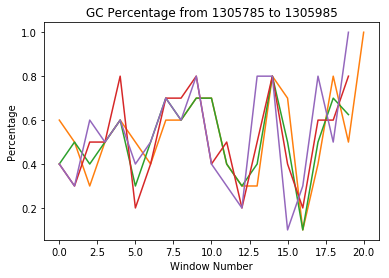

Motif locations for Cpr76Bc
CGCT: ['2', '64', '77', '86', '98']
GCTG: ['3', '65', '78', '81', '99', '195']
AAAA: ['59', '60', '71', '125', '126']
CGCTG: ['2', '64', '77', '98']
AAAAC: ['60', '71', '126']
AAACG: ['61', '72', '127']
ACAAA: ['69', '123', '190']
GCTGC: ['78', '99', '195']
GCGCTG: ['1', '76']
AAAAAC: ['59', '125']
AAAACG: ['60', '71', '126']
AAACGC: ['61', '72']
GACAAA: ['68', '122']
ACAAAA: ['69', '123']
CGCTGC: ['77', '98']
AAAAACG: ['59', '125']
AAAACGC: ['60', '71']
GACAAAA: ['68', '122']
(1305785, 1305985)


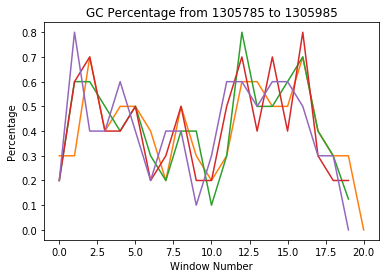

Motif locations for Cpr76Bd
TCAC: ['4', '53', '113']
ACTT: ['6', '96', '197']
CTTT: ['7', '71', '97', '192']
TTTA: ['8', '72', '193']
AAAA: ['11', '103', '104', '105', '176']
AACT: ['13', '58', '196']
TTGG: ['32', '38', '163']
TGTA: ['44', '63', '142']
TTAT: ['73', '157', '186']
TTCA: ['76', '100', '112']
CACA: ['84', '114', '181']
CTTTA: ['7', '71', '192']
CACTTT: ['5', '95']
CTTTAA: ['7', '192']
(1305785, 1305985)


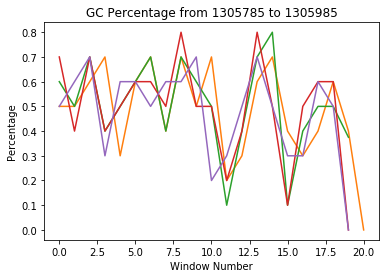

Motif locations for Csp
CCTG: ['7', '27', '69', '101']
CTGT: ['8', '58', '78', '102']
TGCC: ['11', '85', '141', '147']
TGTC: ['17', '59', '75', '81', '103']
CGAT: ['52', '144', '151', '194']
(1305785, 1305985)


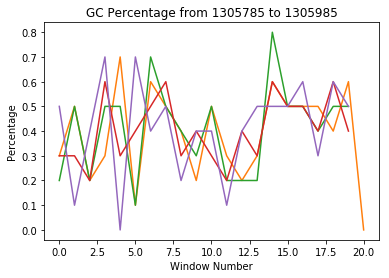

Motif locations for CycH
TTCG: ['0', '11', '166']
CATA: ['4', '68', '105']
TATT: ['6', '9', '138']
TTAT: ['8', '25', '54']
AATT: ['18', '51', '125']
TTTA: ['24', '53', '121']
TAAA: ['49', '112', '123']
AAAT: ['50', '95', '113', '124']
ATAG: ['56', '69', '106']
CTCA: ['83', '103', '133']
TAAAT: ['49', '112', '123']
ATATTA: ['5', '137']
TTCTTT: ['21', '118']
TCTTTA: ['22', '119']
CGTAAA: ['47', '110']
GTAAAT: ['48', '111']
TAAATT: ['49', '123']
TCCTCA: ['101', '131']
TTCTTTA: ['21', '118']
CGTAAAT: ['47', '110']
(1305785, 1305985)


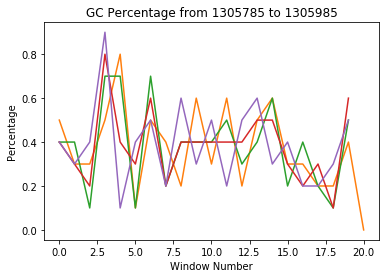

Motif locations for Ddx1
CGAG: ['2', '38', '63', '196']
CTGA: ['13', '48', '72', '131']
TGAA: ['14', '73', '106', '132', '170']
TTTA: ['27', '52', '56', '98']
TATT: ['54', '155', '174', '191']
CTGAA: ['13', '72', '131']
AAATCC: ['16', '125']
ATTCAA: ['81', '175']
GAACTA: ['119', '133']
AATATT: ['172', '189']
(1305785, 1305985)


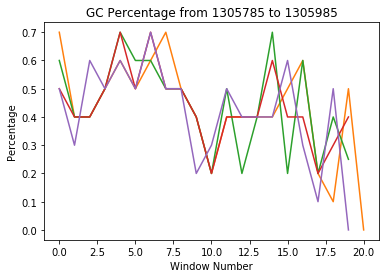

Motif locations for Est
AATT: ['41', '129', '170', '186']
ATTG: ['42', '130', '171', '187']
CAAT: ['122', '128', '159', '169', '185']
AATTG: ['41', '129', '170', '186']
CAATT: ['128', '169', '185']
GACTGA: ['7', '29']
AATTGC: ['41', '129']
CAATTG: ['128', '169', '185']
(1305785, 1305985)


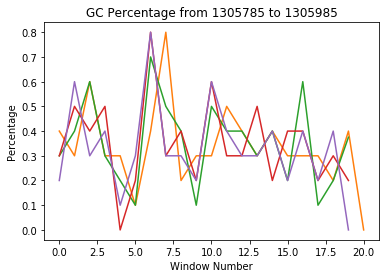

Motif locations for Gbeta76C
TAAA: ['9', '14', '60', '82', '94', '174']
AAAC: ['10', '61', '83', '95']
CAAT: ['30', '79', '98', '150', '190']
AATA: ['31', '46', '80', '176']
TAAAC: ['9', '60', '82', '94']
TTAAA: ['59', '93', '173']
ACAAT: ['78', '97', '189']
ATAAAC: ['8', '81']
TAAACT: ['9', '82']
AATATT: ['31', '46']
ATATTT: ['32', '47']
TTAAAC: ['59', '93']
TAAACA: ['60', '94']
GTTAAA: ['92', '172']
ATTAGC: ['152', '165']
ATAAACT: ['8', '81']
AATATTT: ['31', '46']
TTAAACA: ['59', '93']
(1305785, 1305985)


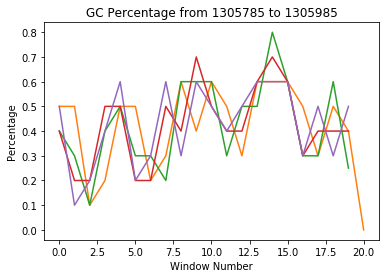

Motif locations for IleRS
AAAC: ['31', '68', '73', '195']
ACAA: ['37', '70', '104', '191']
TTTT: ['57', '89', '90', '91']
(1305785, 1305985)


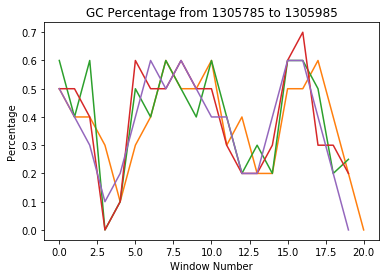

Motif locations for M6
CAGT: ['23', '82', '90', '95']
AGTT: ['24', '83', '96', '195']
GTTC: ['25', '76', '84', '97']
TTCT: ['26', '77', '85', '98', '118']
AAAC: ['66', '154', '183', '190']
CAGTT: ['23', '82', '95']
AGTTC: ['24', '83', '96']
GTTCT: ['25', '76', '84', '97']
TTCTG: ['77', '85', '118']
TGCAG: ['80', '88', '93']
GCAGT: ['81', '89', '94']
CAGTTC: ['23', '82', '95']
AGTTCT: ['24', '83', '96']
TGCAGT: ['80', '88', '93']
CAGTTCT: ['23', '82', '95']
ACAAACG: ['64', '152']
CAAACGC: ['65', '153']
AAACGCA: ['66', '154']
GTTCTGC: ['76', '84']
TTCTGCA: ['77', '85']
TCTGCAG: ['78', '86']
CTGCAGT: ['79', '87']
TGCAGTT: ['80', '93']
GCAGTTC: ['81', '94']
ACAAACGC: ['64', '152']
CAAACGCA: ['65', '153']
GTTCTGCA: ['76', '84']
TTCTGCAG: ['77', '85']
TCTGCAGT: ['78', '86']
TGCAGTTC: ['80', '93']
GCAGTTCT: ['81', '94']
ACAAACGCA: ['64', '152']
GTTCTGCAG: ['76', '84']
TTCTGCAGT: ['77', '85']
TGCAGTTCT: ['80', '93']
GTTCTGCAGT: ['76', '84']
(1305785, 1305985)


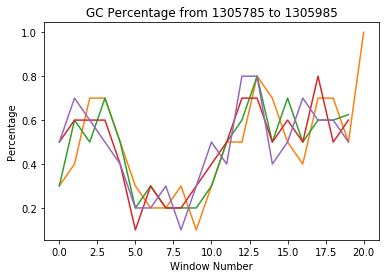

Motif locations for Mes2
AGCT: ['7', '13', '187']
GCTT: ['8', '14', '147']
CAGC: ['12', '113', '178']
GGAA: ['43', '52', '162', '184']
GAAG: ['44', '49', '185']
AACT: ['54', '70', '164']
CTTT: ['56', '148', '166']
AAGA: ['74', '78', '106']
TTTT: ['90', '91', '92', '149']
GTGG: ['135', '155', '160']
(1305785, 1305985)


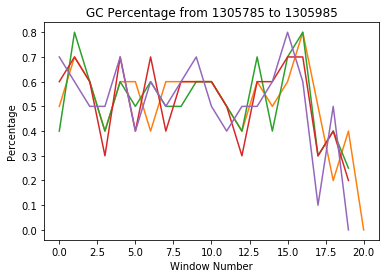

Motif locations for ND
CAAT: ['3', '178', '183', '193']
GACT: ['56', '118', '123', '174']
TCAA: ['126', '141', '177', '182', '192']
TGACT: ['55', '122', '173']
TCAAT: ['177', '182', '192']
CAATTC: ['3', '178']
TGACTC: ['122', '173']
GACTCA: ['123', '174']
ACTCAA: ['124', '175']
GCGTCA: ['138', '189']
CGTCAA: ['139', '190']
TGACTCA: ['122', '173']
GACTCAA: ['123', '174']
GCGTCAA: ['138', '189']
TGACTCAA: ['122', '173']
(1305785, 1305985)


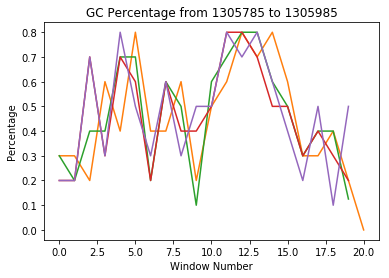

Motif locations for Nopp140
TTTT: ['24', '92', '99', '169', '170']
GCAC: ['34', '51', '79', '116', '185']
CACA: ['62', '64', '80', '82', '84', '117', '177', '186']
ACAC: ['63', '81', '83', '85', '118', '176']
TTTTC: ['24', '99', '170']
CGCAC: ['33', '50', '78']
CACAC: ['62', '80', '82', '84', '117']
ACACA: ['63', '81', '83', '176']
GCACA: ['79', '116', '185']
GTTTT: ['91', '98', '168']
GGCAG: ['104', '112', '125']
GCAGC: ['113', '126', '129']
TTCTCT: ['15', '150']
CCGCAC: ['32', '49']
CACACA: ['62', '80', '82']
GCACAC: ['79', '116']
ACACAC: ['81', '83']
CACACG: ['84', '117']
CGGCAG: ['103', '124']
GGCAGC: ['112', '125']
GCAGCA: ['113', '126']
AGCACA: ['115', '184']
CACACAC: ['80', '82']
GGCAGCA: ['112', '125']
(1305785, 1305985)


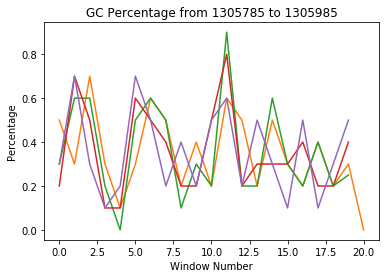

Motif locations for ORMDL
ATTA: ['8', '82', '137', '148', '177']
TTAA: ['35', '83', '178', '184', '192']
AAAA: ['43', '44', '45', '85', '99', '100', '126', '127', '128', '129', '130']
CATT: ['54', '81', '152', '160', '176']
GTTTA: ['33', '182', '190']
TTTAA: ['34', '183', '191']
AAAAA: ['43', '44', '99', '126', '127', '128', '129']
AAAAT: ['45', '85', '100']
TTAAA: ['83', '184', '192']
GTGGCA: ['0', '22']
TGGCAG: ['1', '23']
GGCAGA: ['2', '24']
GAATTA: ['6', '135']
AATTAT: ['7', '136']
TTATTC: ['9', '164']
AGTTTA: ['32', '181']
GTTTAA: ['33', '182', '190']
CAAAAA: ['42', '125']
AAAAAA: ['43', '126', '127', '128']
AAAAAT: ['44', '99']
AAAATA: ['45', '100']
CATTAA: ['81', '176']
ACATTT: ['151', '159']
TTTAAA: ['183', '191']
TTAAAC: ['184', '192']
GTGGCAG: ['0', '22']
TGGCAGA: ['1', '23']
GAATTAT: ['6', '135']
AGTTTAA: ['32', '181']
CAAAAAA: ['42', '125']
AAAAATA: ['44', '99']
AAAAAAA: ['126', '127']
GTTTAAA: ['182', '190']
TTTAAAC: ['183', '191']
GTGGCAGA: ['0', '22']
GTTTAAAC: ['182', '

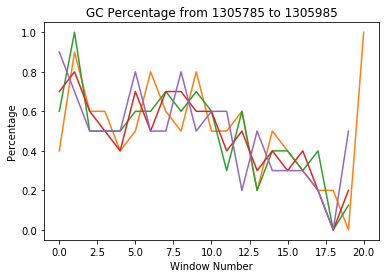

Motif locations for Oct
TGGA: ['38', '122', '157', '167']
GATT: ['40', '46', '133', '169']
ATTA: ['47', '134', '148', '191']
TGCG: ['59', '88', '93', '108']
GCGG: ['60', '76', '89', '109']
AATG: ['72', '84', '118', '137']
ATGT: ['85', '119', '138', '151']
TTAT: ['149', '175', '186', '192']
TATA: ['176', '187', '193', '195']
TTGGA: ['37', '156', '166']
GGATT: ['39', '132', '168']
TGCGG: ['59', '88', '108']
AATGT: ['84', '118', '137']
TTATA: ['175', '186', '192']
TATAA: ['176', '187', '195']
TTGGAT: ['37', '166']
TGGATT: ['38', '167']
AATGTG: ['84', '118']
TTATAA: ['175', '186']
TTGGATT: ['37', '166']
(1305785, 1305985)


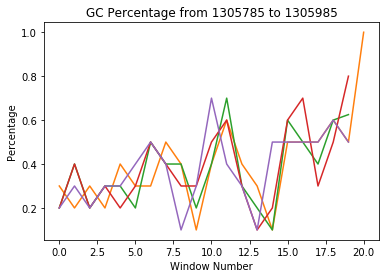

Motif locations for Rcd7
CTTT: ['1', '105', '135']
TAAA: ['9', '52', '88']
GAAA: ['16', '24', '34']
AAAA: ['25', '26', '27', '28', '35', '36']
AAAC: ['37', '53', '89']
TACA: ['47', '149', '192']
AACA: ['54', '57', '90']
TGTT: ['77', '139', '179']
CTAC: ['83', '132', '162']
TTTG: ['97', '137', '181']
TGCC: ['110', '119', '183']
AAAAA: ['25', '26', '27', '35']
AGAAAA: ['23', '33']
GAAAAA: ['24', '34']
AAAAAA: ['25', '26']
TAAACA: ['52', '88']
AAGCTA: ['64', '159']
AGAAAAA: ['23', '33']
(1305785, 1305985)


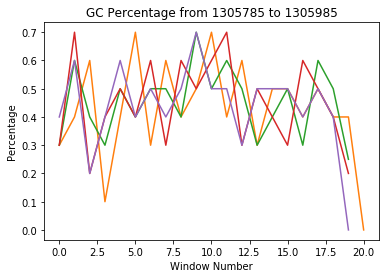

Motif locations for RpLP0
TTGA: ['1', '27', '110']
GATT: ['3', '59', '131']
TTAG: ['12', '61', '136']
TCGG: ['23', '128', '165']
CGGT: ['24', '121', '166']
AAGA: ['35', '46', '188']
GAAC: ['37', '76', '181']
AAAG: ['45', '151', '187']
AGAG: ['47', '189', '191']
TTTC: ['126', '163', '170']
TTCG: ['127', '164', '171']
TTTT: ['133', '134', '162', '169']
AGCA: ['138', '141', '153']
TTTCG: ['126', '163', '170']
TCGGTT: ['23', '165']
AAAGAG: ['45', '187']
TTACCA: ['68', '146']
TTTCGG: ['126', '163']
CACAGA: ['155', '177']
TTTTCG: ['162', '169']
(1305785, 1305985)


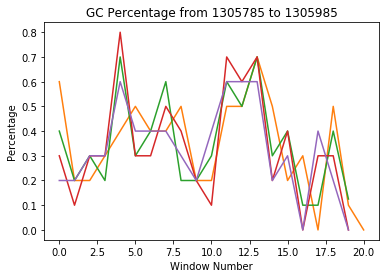

Motif locations for Rpb8
GGAA: ['7', '36', '53', '63', '88']
AATT: ['9', '38', '90', '107', '149', '154']
TTAT: ['23', '83', '166', '171', '174']
TGGT: ['26', '93', '102', '132', '138']
GGAAT: ['7', '36', '88']
GAATT: ['8', '37', '89']
AAAAA: ['55', '56', '57']
AATTC: ['107', '149', '154']
TTCAA: ['146', '151', '156']
GGAATT: ['7', '36', '88']
GAATTG: ['8', '89']
TTTTAT: ['21', '169']
TATGGT: ['24', '100']
TAGGAA: ['34', '86']
AGGAAT: ['35', '87']
AAAAAA: ['55', '56']
TGGTAA: ['93', '102']
GGTAAA: ['94', '103']
GTAAAT: ['95', '104']
TTCAAT: ['146', '151']
TCAATT: ['147', '152']
CAATTC: ['148', '153']
AATTCA: ['149', '154']
ATTCAA: ['150', '155']
GGAATTG: ['7', '88']
TAGGAAT: ['34', '86']
AGGAATT: ['35', '87']
TGGTAAA: ['93', '102']
GGTAAAT: ['94', '103']
TTCAATT: ['146', '151']
TCAATTC: ['147', '152']
CAATTCA: ['148', '153']
AATTCAA: ['149', '154']
TAGGAATT: ['34', '86']
TGGTAAAT: ['93', '102']
TTCAATTC: ['146', '151']
TCAATTCA: ['147', '152']
CAATTCAA: ['148', '153']
TTCAATTCA: ['146'

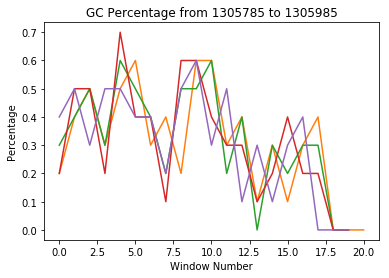

Motif locations for Rpn10
ATTT: ['6', '38', '134', '181', '187']
TTTT: ['7', '8', '112', '113', '114', '115', '135', '136', '182']
AAAT: ['78', '83', '141', '179', '196']
ATTTT: ['6', '134', '181']
TTTTT: ['7', '112', '113', '114', '135']
AATTT: ['37', '180', '186']
AAAAT: ['77', '82', '140']
TTTAA: ['137', '166', '183']
TATTTT: ['5', '133']
ATTTTT: ['6', '134']
TTTTTG: ['7', '114']
GCTTGT: ['12', '91']
TAATTT: ['36', '185']
TAAAAT: ['81', '139']
TTTTTT: ['112', '113']
TTCCAT: ['120', '125']
TTTTAA: ['136', '182']
ATATAT: ['149', '151']
TATTTTT: ['5', '133']
(1305785, 1305985)


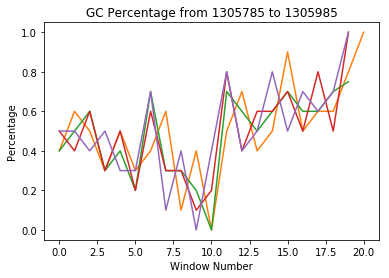

Motif locations for SLC22A
TATT: ['21', '57', '79', '102', '106']
TTTT: ['48', '81', '108', '109', '131']
TTTA: ['55', '59', '87', '104', '110']
ATTT: ['58', '80', '86', '103', '107']
TTTAT: ['55', '59', '104']
TTATT: ['56', '78', '105']
TATTT: ['57', '79', '102', '106']
ATTTA: ['58', '86', '103']
TGCGA: ['134', '168', '182']
ACACAC: ['39', '41']
TTTATT: ['55', '104']
TTATTT: ['56', '78', '105']
TATTTA: ['57', '102']
ATTTAT: ['58', '103']
TATTTT: ['79', '106']
TGCGAT: ['134', '182']
CTGCGA: ['167', '181']
TTTATTT: ['55', '104']
TATTTAT: ['57', '102']
TTATTTT: ['78', '105']
(1305785, 1305985)


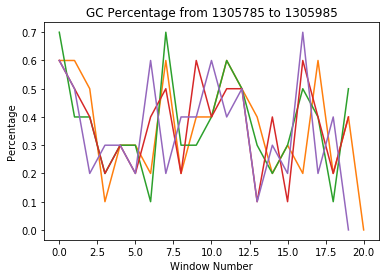

Motif locations for SMC5
ACAA: ['1', '45', '52', '67', '158', '173']
GTTT: ['34', '58', '85', '92', '136']
AATT: ['38', '54', '160', '186']
TTTC: ['59', '79', '87', '93']
ACAAT: ['45', '52', '158']
GTTTAA: ['34', '136']
AACAAT: ['44', '51']
ACAATT: ['52', '158']
TTGTTT: ['56', '83']
ATACAA: ['65', '156']
TCGATA: ['128', '153']
(1305785, 1305985)


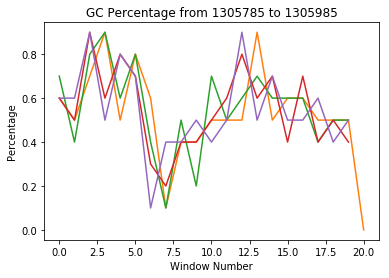

Motif locations for SPoCk
GGCC: ['25', '31', '58', '130']
CCGC: ['33', '60', '104', '117']
CAAC: ['63', '123', '126', '188']
AACA: ['70', '88', '124', '189']
CACG: ['84', '172', '182', '191']
GGCCG: ['25', '31', '58']
CACGT: ['172', '182', '191']
GAGGCC: ['29', '56']
AGGCCG: ['30', '57']
GGCCGC: ['31', '58']
TCGATT: ['95', '109']
GAGGCCG: ['29', '56']
AGGCCGC: ['30', '57']
GAGGCCGC: ['29', '56']
(1305785, 1305985)


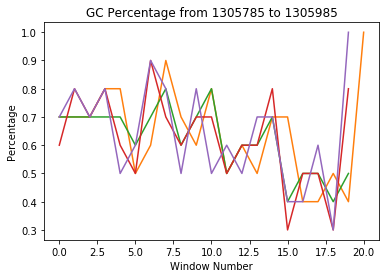

Motif locations for Srpk79D
CCGC: ['1', '34', '43', '84', '139']
CTGG: ['7', '37', '47', '76', '94', '104', '147']
TCCT: ['57', '80', '92', '124', '157', '165']
TCCGC: ['33', '42', '83', '138']
GCTGG: ['36', '75', '103', '146']
TTCCT: ['56', '123', '156', '164']
CTGGGC: ['7', '104']
TGGGCA: ['8', '105']
GGGCAG: ['9', '106']
CCTCCG: ['31', '81']
CTCCGC: ['32', '41', '82']
CGCTGG: ['35', '145']
GCTGGC: ['36', '146']
TCCGCC: ['42', '83']
CCGCCT: ['43', '84']
GTTCCT: ['55', '163']
TTCCTC: ['56', '123']
TCCTCG: ['57', '124']
TGTGCG: ['64', '195']
CGGCTG: ['73', '101']
GGCTGG: ['74', '102']
GCAGCT: ['108', '118']
GCTTCC: ['121', '154']
CTTCCT: ['122', '155']
CCTGCT: ['151', '166']
CTGCTT: ['152', '167']
CTTTTG: ['170', '191']
CTGGGCA: ['7', '104']
TGGGCAG: ['8', '105']
CCTCCGC: ['31', '81']
CGCTGGC: ['35', '145']
CTCCGCC: ['41', '82']
TCCGCCT: ['42', '83']
TTCCTCG: ['56', '123']
CGGCTGG: ['73', '101']
GCTTCCT: ['121', '154']
CCTGCTT: ['151', '166']
CTGGGCAG: ['7', '104']
CTCCGCCT: ['41', '82

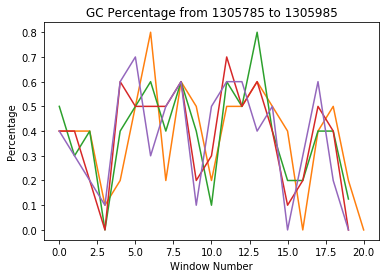

Motif locations for Ssl1
AAAT: ['31', '39', '70', '104', '158', '195']
AATA: ['32', '101', '105', '159']
AATT: ['35', '40', '110', '162', '196']
TAAA: ['38', '43', '103', '157']
AACA: ['45', '55', '76', '168']
ACAA: ['56', '96', '108', '171']
CAAA: ['57', '69', '172', '194']
CACA: ['85', '87', '125', '170']
AAATA: ['31', '104', '158']
AATAA: ['32', '101', '159']
TAAAT: ['38', '103', '157']
AAATAA: ['31', '158']
AATAAT: ['32', '159']
ATAATT: ['33', '160']
AATTAA: ['35', '40']
ATTAAA: ['36', '41']
AAACAG: ['44', '75']
ACAAAG: ['56', '171']
TAAATA: ['103', '157']
AAATAAT: ['31', '158']
AATAATT: ['32', '159']
AATTAAA: ['35', '40']
AAATAATT: ['31', '158']
(1305785, 1305985)


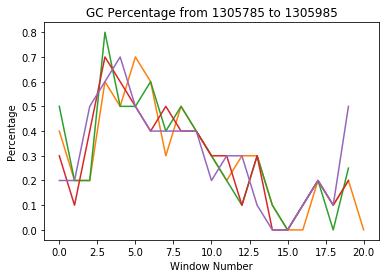

Motif locations for Taf6
AAAT: ['15', '23', '155', '159', '163', '184', '194']
TATT: ['112', '126', '131', '147', '167', '173', '187']
TTTT: ['114', '115', '116', '138', '139', '149', '150', '175']
AAATA: ['15', '23', '155', '159', '184', '194']
ATAAA: ['17', '157', '161', '182']
TTTTT: ['114', '115', '138', '149']
ATATT: ['125', '130', '146', '186']
ACAAAT: ['13', '21', '192']
CAAATA: ['14', '22', '193']
AAATAA: ['15', '155', '159']
AATAAA: ['16', '156', '160']
TATTTT: ['112', '147', '173']
ATAAAT: ['157', '161', '182']
AGATTTC: ['6', '91']
GATTTCA: ['7', '92']
ACAAATA: ['13', '21', '192']
AAATAAA: ['15', '155', '159']
AACAAAT: ['20', '191']
TATTTTT: ['112', '147']
TGTCATA: ['121', '178']
AATAAAT: ['156', '160']
ATAAATA: ['157', '182']
AGATTTCA: ['6', '91']
AACAAATA: ['20', '191']
AAATAAAT: ['155', '159']
(1305785, 1305985)


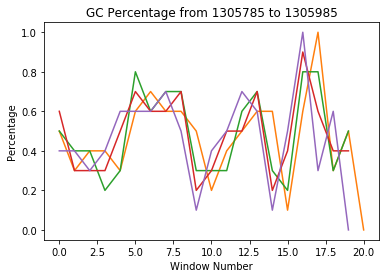

Motif locations for TfAP
AAAT: ['15', '105', '148']
AGTT: ['27', '94', '131']
GTTG: ['28', '69', '95', '132']
TTGG: ['29', '51', '133']
AATT: ['40', '48', '149']
ATTT: ['41', '49', '150']
TGGC: ['52', '61', '134']
AGCT: ['65', '122', '193']
TGTT: ['68', '97', '155']
TTGT: ['70', '96', '100']
CCGA: ['74', '78', '140']
ATGA: ['114', '117', '180']
TCGC: ['127', '161', '167']
AGTTG: ['27', '94', '131']
AATTT: ['40', '48', '149']
AAGTTG: ['26', '93']
AGTTGG: ['27', '131']
CAATTT: ['39', '47']
TTGGCC: ['51', '133']
CCGACC: ['74', '78']
(1305785, 1305985)


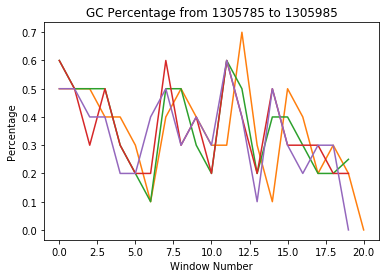

Motif locations for Trxr
AAAA: ['43', '55', '109', '144', '173', '174', '175', '191']
TAAA: ['54', '108', '139', '143', '172', '190']
TGTA: ['61', '91', '95', '156', '170', '188']
TAAAA: ['54', '108', '143', '172', '190']
AAAAC: ['55', '109', '144', '191']
TGTAA: ['61', '156', '170', '188']
TGAGTT: ['29', '103']
TTGAGT: ['34', '102']
AATAAA: ['52', '141']
ATAAAA: ['53', '142']
TAAAAC: ['54', '108', '143', '190']
AACTTG: ['57', '85']
ACTTGT: ['58', '86']
AATACA: ['71', '132']
TATGTA: ['93', '186']
AAAACA: ['109', '144', '191']
AAACAG: ['145', '192']
ATGTAA: ['155', '187']
TGTAAA: ['170', '188']
GTAAAA: ['171', '189']
AATAAAA: ['52', '141']
ATAAAAC: ['53', '142']
AACTTGT: ['57', '85']
TAAAACA: ['108', '143', '190']
AAAACAG: ['144', '191']
TGTAAAA: ['170', '188']
AATAAAAC: ['52', '141']
TAAAACAG: ['143', '190']
(1305785, 1305985)


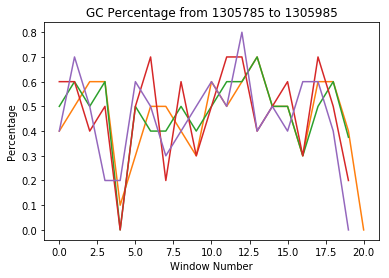

Motif locations for VhaM9.7
CTCG: ['17', '22', '84', '138', '149']
TTTT: ['31', '79', '80', '188']
AAAA: ['45', '46', '51', '52', '166']
(1305785, 1305985)


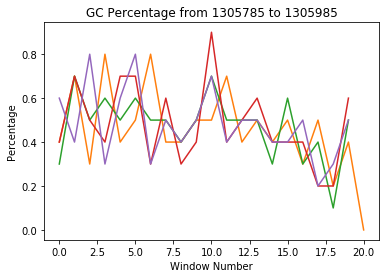

Motif locations for asf1
TTTT: ['41', '42', '68', '69', '70', '87']
TTTC: ['43', '71', '156', '185']
TGAT: ['161', '176', '180', '193']
TTTTT: ['41', '68', '69']
TTTTTC: ['41', '69']
GCTTTT: ['66', '85']
GTTCTG: ['80', '91']
TGCAGA: ['97', '130']
GCAGAA: ['98', '131']
TGCAGAA: ['97', '130']
(1305785, 1305985)


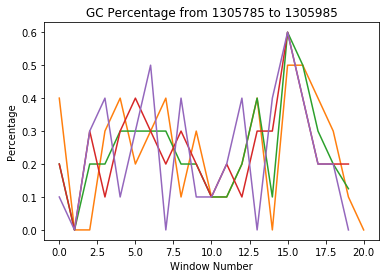

Motif locations for eg
AAAA: ['3', '4', '25', '26', '71', '140', '141', '147', '148']
TTTT: ['16', '37', '38', '49', '50', '51']
AATT: ['20', '83', '99', '105', '111', '125', '143', '177', '182', '192']
AAAAA: ['3', '25', '140', '147']
AATTA: ['83', '105', '143', '182', '192']
TGAAT: ['97', '114', '165', '175']
AAAAGG: ['4', '71']
AAGGAA: ['6', '67']
GAATAT: ['9', '115']
AATATA: ['10', '116']
ATATAT: ['11', '117']
TTTTAA: ['16', '51']
AATTTA: ['20', '125']
TTAAAA: ['23', '145']
TAAAAA: ['24', '139', '146']
AAAAAC: ['25', '147']
ATAATT: ['81', '109']
AATTAT: ['83', '105']
TTGAAT: ['96', '113']
TGAATT: ['97', '175']
TTCAAT: ['102', '179']
TCAATT: ['103', '180']
CAATTA: ['104', '181']
AAATTA: ['142', '191']
AATTAA: ['143', '192']
CTGAAT: ['164', '174']
GAATATA: ['9', '115']
AATATAT: ['10', '116']
TTAAAAA: ['23', '145']
TAAAAAC: ['24', '146']
TTCAATT: ['102', '179']
TCAATTA: ['103', '180']
AAATTAA: ['142', '191']
GAATATAT: ['9', '115']
TTAAAAAC: ['23', '145']
TTCAATTA: ['102', '179']
(1305

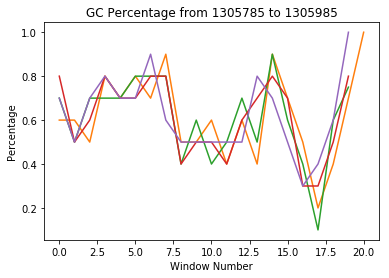

Motif locations for mael
GGCG: ['8', '69', '76', '145', '148']
GGCA: ['13', '43', '72', '94']
GCGG: ['30', '70', '77', '146']
CGGC: ['42', '68', '71', '144', '147']
GAGCG: ['28', '56', '60']
GCGAG: ['54', '58', '62']
CGGCG: ['68', '144', '147']
GGCGG: ['69', '76', '145']
GCGGTC: ['30', '77']
TGCGCG: ['51', '124']
GCGAGC: ['54', '58']
CGAGCG: ['55', '59']
GAGCGA: ['56', '60']
AGCGAG: ['57', '61']
CGGCGG: ['68', '144']
GGCGGC: ['69', '145']
GCGAGCG: ['54', '58']
CGAGCGA: ['55', '59']
GAGCGAG: ['56', '60']
CGGCGGC: ['68', '144']
GCGAGCGA: ['54', '58']
CGAGCGAG: ['55', '59']
GCGAGCGAG: ['54', '58']
(1305785, 1305985)


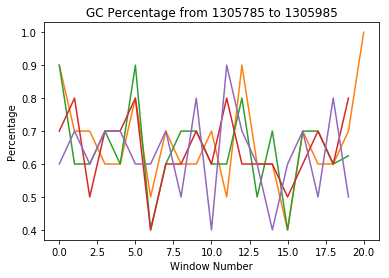

Motif locations for ms(3)76Ca
GGCG: ['0', '59', '127', '189']
CCGG: ['4', '84', '99', '119']
GTGC: ['8', '34', '50', '142', '166']
GCTC: ['18', '36', '87', '96']
CCTG: ['47', '54', '90', '124']
CTGT: ['48', '91', '131', '148']
CGGC: ['58', '85', '120', '180']
TCCC: ['117', '135', '160', '175']
GTGCC: ['8', '50', '142']
CTCGG: ['19', '40', '178']
GCTCC: ['36', '87', '96']
TGCTCC: ['35', '95']
GCTCCT: ['36', '87']
CCTCGG: ['39', '177']
TCCTGT: ['46', '89']
GCCCTG: ['52', '122']
CGCTGT: ['129', '146']
GTTCCC: ['133', '158']
(1305785, 1305985)


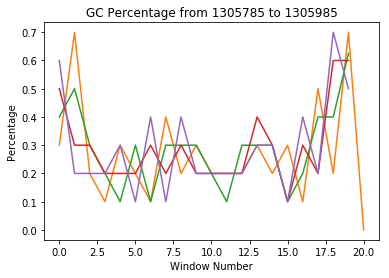

Motif locations for ms(3)76Cc
AATT: ['20', '34', '66', '94', '132', '158']
ATTT: ['21', '35', '67', '79', '133', '159', '181']
TTTT: ['22', '23', '36', '42', '43', '44', '50', '51', '80', '103', '182']
TTGT: ['53', '105', '128', '135', '148', '161']
AATTT: ['20', '34', '66', '132', '158']
ATTTT: ['21', '35', '79', '181']
TTTTT: ['22', '42', '43', '50']
TTTGT: ['52', '104', '134', '160']
AATTTT: ['20', '34']
ACAACA: ['28', '122']
AACAAA: ['30', '116']
AAATTT: ['33', '65', '157']
TTTTAG: ['44', '80']
TTTTGT: ['51', '103']
TTAAAA: ['62', '154']
TAAAAT: ['63', '155']
AAAATT: ['64', '156']
TATTTT: ['78', '180']
TTTGTA: ['104', '160']
TTGTAA: ['105', '128']
TGTAAT: ['106', '129']
AAAACA: ['114', '119']
AAACAA: ['115', '120']
AATTTG: ['132', '158']
ATTTGT: ['133', '159']
TTGTGG: ['135', '148']
TGTGGT: ['136', '149']
TTAAAAT: ['62', '154']
TAAAATT: ['63', '155']
AAAATTT: ['64', '156']
TTGTAAT: ['105', '128']
AAAACAA: ['114', '119']
AATTTGT: ['132', '158']
TTGTGGT: ['135', '148']
TTAAAATT: ['62

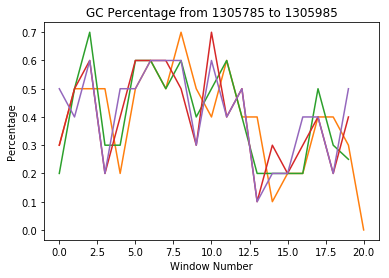

Motif locations for mub
TATC: ['2', '47', '77', '158']
TTTT: ['8', '101', '102', '134']
TTTG: ['9', '18', '135', '149']
TCTG: ['49', '55', '73', '105']
ATAT: ['142', '155', '157', '192']
TATA: ['143', '154', '156', '187', '193']
GTATC: ['1', '46', '76']
ATATA: ['142', '155', '192']
GTATCT: ['1', '46']
TTTGCT: ['9', '149']
TGTATC: ['45', '75']
TGACCG: ['57', '171']
CGTACT: ['61', '182']
(1305785, 1305985)


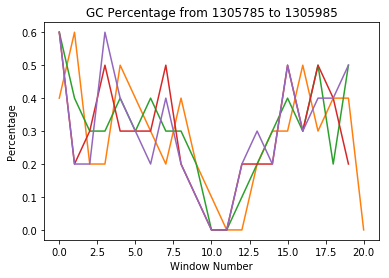

Motif locations for nrm
TTTT: ['20', '21', '34', '35', '110', '111', '120', '121', '122', '123', '124', '185']
TTTA: ['22', '61', '97', '106', '112', '116', '125']
TTAT: ['31', '98', '103', '107', '113', '117', '126']
TATT: ['32', '104', '108', '114', '118', '131', '138']
ATTT: ['33', '60', '96', '105', '109', '115', '119', '153']
TTTTT: ['20', '34', '110', '120', '121', '122', '123']
TTATT: ['31', '103', '107', '113', '117']
TATTT: ['32', '104', '108', '114', '118']
TTTAT: ['97', '106', '112', '116', '125']
TTTTTA: ['20', '110', '123']
TTATTT: ['31', '103', '107', '113', '117']
TATTTT: ['32', '108', '118']
ATTTTT: ['33', '109', '119']
ATTTAT: ['96', '105', '115']
TTTATT: ['106', '112', '116']
TTTTTT: ['120', '121', '122']
TTCATT: ['146', '150', '167']
TTATTTT: ['31', '107', '117']
TATTTTT: ['32', '108', '118']
TTTATTT: ['106', '112', '116']
TTATTTTT: ['31', '107', '117']
TGAATTTA: ['57', '93']
TTATTTAT: ['103', '113']
TATTTATT: ['104', '114']
ATTTATTT: ['105', '115']
TTTATTTT: ['106',

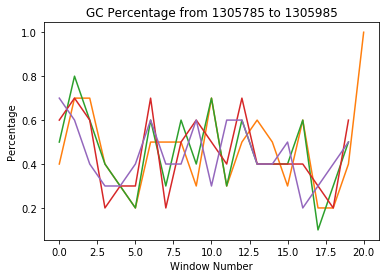

Motif locations for olf413
ATTT: ['8', '78', '174', '187']
TTGC: ['10', '19', '65', '83']
GCTT: ['17', '28', '134', '145']
GCAA: ['39', '89', '120', '184']
(1305785, 1305985)


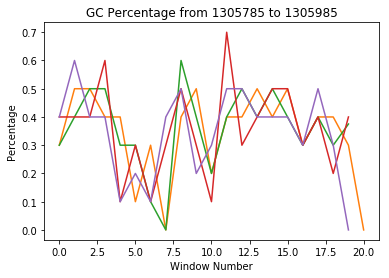

Motif locations for ppk5
GTTT: ['6', '103', '138', '154', '165']
TTTT: ['7', '20', '29', '30', '31', '50', '51', '52', '63', '64', '65', '74', '75', '108']
TTTG: ['8', '32', '109', '139', '155', '161']
CCTT: ['18', '27', '147', '159', '173']
CTTT: ['19', '28', '62', '160', '174']
CCTTT: ['18', '27', '159', '173']
TTTTT: ['29', '30', '50', '51', '63', '64', '74']
TATTT: ['48', '72', '78', '106']
TTTTTT: ['29', '50', '63']
TATTTT: ['48', '72', '106']
TTATTT: ['71', '77', '105']
CTTTTTT: ['28', '62']
TATTTTT: ['48', '72']
TTTTTTC: ['50', '63']
TTTTTCA: ['51', '64']
TTATTTT: ['71', '105']
TTTATTT: ['76', '104']
TTTTTTCA: ['50', '63']
(1305785, 1305985)


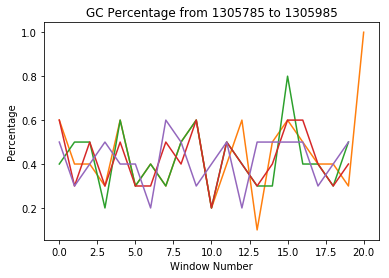

Motif locations for slif
TCAA: ['32', '48', '56', '134']
ACTA: ['62', '89', '110', '117']
TAGC: ['64', '119', '123', '165', '172']
TATC: ['74', '81', '112', '132']
GTCAA: ['31', '47', '55']
CTAGC: ['63', '118', '122']
GGTCAA: ['30', '46']
CAACTA: ['60', '87']
ACTAGC: ['62', '117']
AGCATT: ['65', '160']
(1305785, 1305985)


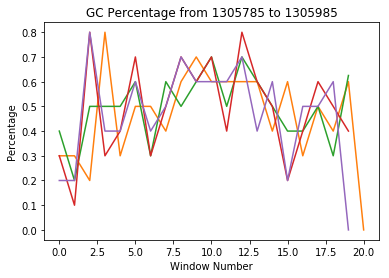

Motif locations for Als2
AAAA: ['0', '11', '40', '41', '162']
AAAC: ['1', '12', '42', '163']
CCAA: ['4', '38', '51', '81', '182']
CAAT: ['52', '82', '145', '186']
AAAAC: ['0', '11', '41', '162']
CAATT: ['52', '145', '186']
CGCGGC: ['30', '57']
(1305785, 1305985)


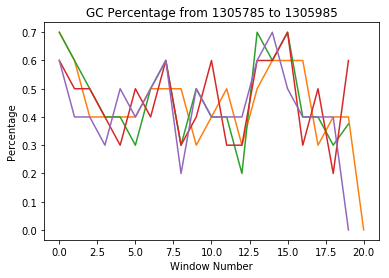

Motif locations for Arf79F
ATTC: ['32', '53', '91', '131']
TCCA: ['34', '63', '133', '168']
TTTT: ['44', '45', '102', '172', '173']
TTTG: ['46', '84', '103', '116']
CCAG: ['134', '138', '157', '161']
CAGC: ['135', '139', '146', '158']
GCCA: ['137', '156', '160', '196']
TTTGC: ['46', '84', '103']
TTGCA: ['47', '85', '104']
CCAGC: ['134', '138', '157']
AGCCA: ['136', '159', '195']
GCCAG: ['137', '156', '160']
CAACTC: ['23', '107']
ATTCCA: ['32', '131']
TCCATT: ['34', '168']
TTTTGC: ['45', '102']
TTTGCA: ['46', '84', '103']
CCAGCC: ['134', '157']
CAGCCA: ['135', '158']
AGCCAG: ['136', '159']
GCCAGC: ['137', '156']
TTTTGCA: ['45', '102']
CCAGCCA: ['134', '157']
CAGCCAG: ['135', '158']
CCAGCCAG: ['134', '157']
(1305785, 1305985)


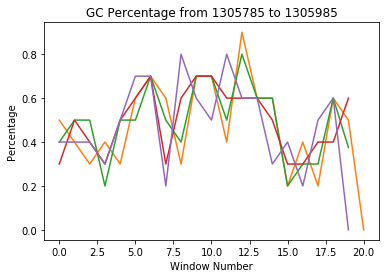

Motif locations for ArfGAP3
AAAG: ['11', '27', '117', '167']
GTCG: ['14', '127', '137', '147']
CGAG: ['16', '93', '106', '139']
AATT: ['21', '84', '153', '176']
GCAA: ['25', '76', '97', '142']
TTTT: ['33', '34', '155', '156']
AGCG: ['91', '104', '119', '134']
GTCGA: ['14', '137', '147']
CGTCG: ['126', '136', '146']
GAAAAG: ['9', '115']
GTCGAG: ['14', '137']
ATCTAG: ['45', '53']
TCTAGG: ['46', '54']
CGCAGC: ['88', '101']
GCAGCG: ['89', '102']
CAGCGA: ['90', '103']
AGCGAG: ['91', '104']
GCAACG: ['97', '142']
GCGTCG: ['125', '135']
CGTCGA: ['136', '146']
ATCTAGG: ['45', '53']
CGCAGCG: ['88', '101']
GCAGCGA: ['89', '102']
CAGCGAG: ['90', '103']
CGCAGCGA: ['88', '101']
GCAGCGAG: ['89', '102']
CGCAGCGAG: ['88', '101']
(1305785, 1305985)


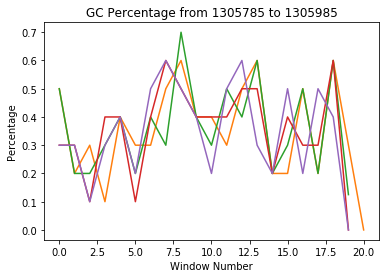

Motif locations for Arv1
AATT: ['11', '18', '27', '56', '108']
CAAA: ['16', '54', '61', '145', '172']
AAAT: ['17', '55', '146', '174', '197']
AAAA: ['62', '63', '141', '173', '196']
ACAAA: ['15', '53', '144']
CAAAT: ['16', '54', '145']
AATTT: ['27', '56', '108']
TGTTT: ['90', '149', '153']
ACAAAT: ['15', '53', '144']
CAAATT: ['16', '54']
GTTTCC: ['37', '91']
AAAACA: ['63', '141']
AACGGT: ['75', '117']
ACAAATT: ['15', '53']
(1305785, 1305985)


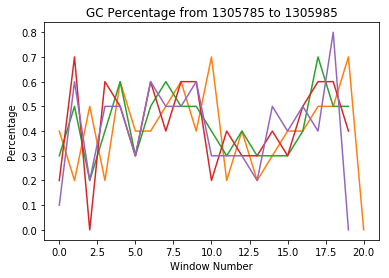

Motif locations for CG11109
TTTA: ['10', '14', '28', '110']
TTTT: ['26', '27', '144', '145']
TGCT: ['35', '73', '91', '174']
TGCTT: ['35', '73', '91']
TTTAAA: ['28', '110']
TGCTTC: ['35', '91']
GCTTCA: ['36', '92']
TGCTTCA: ['35', '91']
(1305785, 1305985)


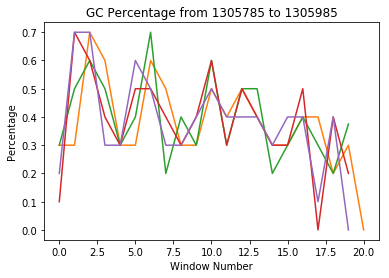

Motif locations for CG11137
AAAA: ['11', '12', '144', '145', '167']
AATT: ['14', '79', '135', '147', '158']
ATTG: ['51', '80', '94', '136', '148']
AAATT: ['13', '78', '146']
ATTGT: ['51', '136', '148']
TTGTC: ['52', '137', '149']
AATTG: ['79', '135', '147']
AAAAAT: ['11', '144']
AAAATT: ['12', '145']
CTATCG: ['38', '72']
ATTGTC: ['51', '136', '148']
TTGTCA: ['52', '149']
AAATTG: ['78', '146']
AATTGT: ['135', '147']
AAAAATT: ['11', '144']
ATTGTCA: ['51', '148']
AATTGTC: ['135', '147']
(1305785, 1305985)


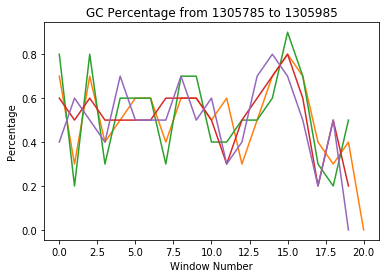

Motif locations for CG11241
CTCC: ['3', '69', '87', '111']
CTGA: ['27', '76', '116', '187']
GAAA: ['34', '118', '180', '189', '196']
(1305785, 1305985)


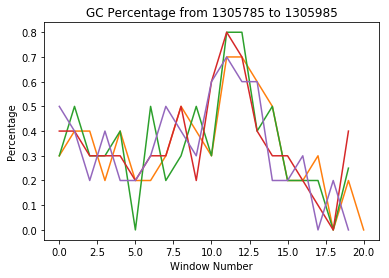

Motif locations for CG11247
TAAA: ['5', '57', '73', '102', '166', '179', '186']
AATA: ['36', '55', '66', '164', '168', '181', '184']
AAAA: ['52', '53', '58', '187', '188', '189', '190', '191', '192', '193']
CCAAA: ['9', '45', '50', '146']
AAATA: ['35', '54', '167', '180']
AAAAA: ['52', '187', '188', '189', '190', '191', '192']
AATAA: ['55', '164', '181', '184']
AAACCA: ['6', '47', '194']
AATAAA: ['55', '164', '184']
AAAAAA: ['187', '188', '189', '190', '191']
AAACCAA: ['6', '47']
AACCAAA: ['7', '48']
AATAAAA: ['55', '184']
AAGTAAA: ['99', '176']
TACATCA: ['158', '170']
ACATCAA: ['159', '171']
AAAAAAA: ['187', '188', '189', '190']
AAACCAAA: ['6', '47']
TACATCAA: ['158', '170']
AAAAAAAA: ['187', '188', '189']
AAAAAAAAA: ['187', '188']
(1305785, 1305985)


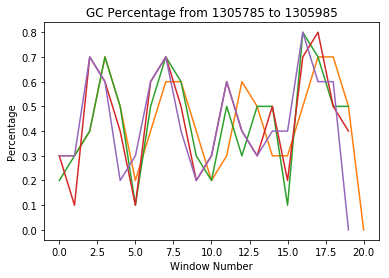

Motif locations for CG11523
CGAA: ['0', '134', '138', '171']
AATA: ['7', '21', '57', '104']
GAAA: ['15', '102', '108', '139']
AAAA: ['16', '54', '55', '128', '129', '160']
GCTT: ['38', '43', '68', '90']
AGAC: ['75', '82', '111', '186']
GACA: ['83', '95', '112', '193']
(1305785, 1305985)


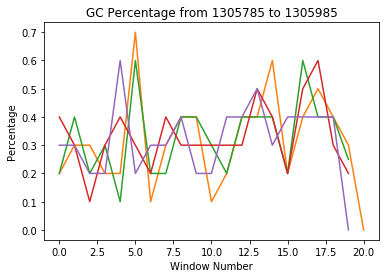

Motif locations for CG12546
TAAA: ['27', '63', '78', '90', '100', '113', '160']
AAAA: ['28', '43', '64', '79', '80', '114', '161']
AATA: ['33', '45', '61', '102', '116']
ATATC: ['16', '34', '103']
TATCA: ['17', '35', '104']
ATAAA: ['26', '62', '159']
TAAAA: ['27', '63', '78', '113', '160']
AAAAG: ['28', '80', '161']
AATAT: ['33', '45', '102']
AAATA: ['44', '60', '101', '115']
AAACA: ['65', '91', '186']
ACATT: ['67', '171', '190']
ATATCA: ['16', '34', '103']
ATAAAA: ['26', '62', '159']
TAAAAG: ['27', '160']
AATATC: ['33', '102']
AAAATA: ['43', '114']
AAATAT: ['44', '101']
AAAAGC: ['80', '161']
AAGCTG: ['82', '180']
AGCTGA: ['83', '181']
CACATT: ['170', '189']
ATAAAAG: ['26', '159']
AATATCA: ['33', '102']
AAGCTGA: ['82', '180']
(1305785, 1305985)


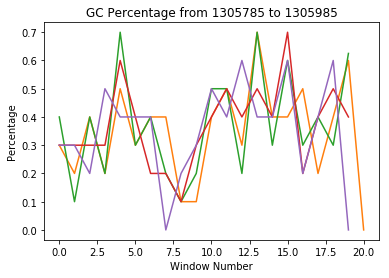

Motif locations for CG14100
AATA: ['0', '57', '83', '123', '167']
CAAA: ['10', '89', '104', '173']
AAAC: ['20', '73', '105', '174']
TTTC: ['93', '101', '113', '151']
TTCA: ['102', '152', '171', '183', '189']
TTCAA: ['102', '171', '183']
AATAAG: ['0', '123']
ATAAGT: ['1', '124']
ACCGGT: ['60', '107']
TTCAAA: ['102', '171']
TCAAAC: ['103', '172']
CCCTGA: ['118', '162']
CCTGAA: ['119', '163']
CTGAAT: ['120', '164']
TGAATA: ['121', '165']
TTCACC: ['152', '189']
AATAAGT: ['0', '123']
TTCAAAC: ['102', '171']
CCCTGAA: ['118', '162']
CCTGAAT: ['119', '163']
CTGAATA: ['120', '164']
CCCTGAAT: ['118', '162']
CCTGAATA: ['119', '163']
CCCTGAATA: ['118', '162']
(1305785, 1305985)


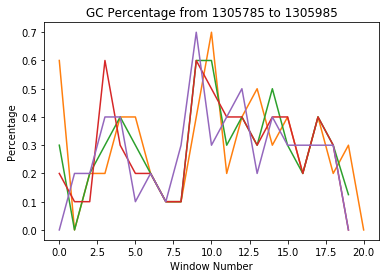

Motif locations for CG14450
TTAA: ['9', '20', '32', '79', '90', '167']
ATTT: ['12', '16', '28', '60', '74', '87']
TTTA: ['13', '19', '31', '78', '89', '113']
TTTT: ['17', '18', '29', '30', '75', '76', '77', '88', '112']
ATAT: ['46', '58', '65', '85', '164', '197']
ATTTT: ['16', '28', '74', '87']
TTTTT: ['17', '29', '75', '76']
TTTTA: ['18', '30', '77', '88', '112']
TTTAA: ['19', '31', '78', '89']
ATATT: ['46', '58', '85', '164']
ATTTTT: ['16', '28', '74']
TTTTTA: ['17', '29', '76']
TTTTAA: ['18', '30', '77', '88']
ATTTTTA: ['16', '28']
TTTTTAA: ['17', '29', '76']
TTAAGTA: ['79', '167']
ATTTTTAA: ['16', '28']
(1305785, 1305985)


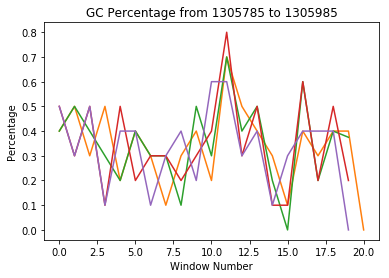

Motif locations for CG14453
GTTA: ['18', '26', '67', '74']
TGAT: ['36', '58', '100', '173']
GATA: ['37', '59', '101', '183']
ATAT: ['38', '87', '89', '154']
ATAA: ['60', '77', '102', '128', '156']
TATA: ['76', '88', '153', '155']
TGATA: ['36', '58', '100']
TTGTTA: ['16', '24']
TGTTAG: ['17', '25']
ATGATA: ['57', '99']
TGATAA: ['58', '100']
TTGTTAG: ['16', '24']
ATGATAA: ['57', '99']
(1305785, 1305985)


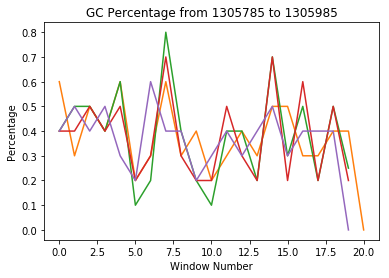

Motif locations for CG14454
CCCA: ['2', '149', '168']
TCTA: ['8', '68', '179']
CATG: ['17', '97', '131']
CTGA: ['21', '32', '47']
ATAT: ['55', '101', '109']
TTTC: ['66', '155', '177']
ATTT: ['85', '154', '176']
GATT: ['92', '153', '175']
TACA: ['95', '121', '195']
ACAT: ['96', '107', '130']
AAAC: ['105', '128', '164']
ACAC: ['122', '124', '189', '191']
CACA: ['123', '125', '190']
AGAT: ['152', '174', '182']
ACACA: ['122', '124', '189']
TTTCTA: ['66', '177']
ACATGA: ['96', '130']
TATAAA: ['102', '160']
AAACAT: ['105', '128']
ACACAC: ['122', '189']
AGATTT: ['152', '174']
GATTTC: ['153', '175']
CTAGAT: ['172', '180']
AGATTTC: ['152', '174']
(1305785, 1305985)


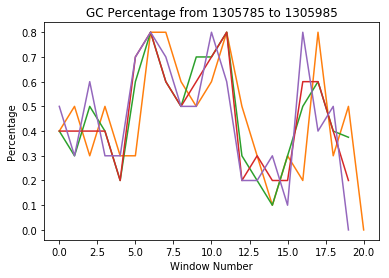

Motif locations for CG14455
ATTG: ['2', '135', '160', '188']
TAAT: ['49', '89', '127', '133', '158', '186']
AATT: ['50', '134', '159', '187']
TGACT: ['44', '123', '154']
TAATT: ['49', '133', '158', '186']
CTAAT: ['88', '126', '157']
AATTG: ['134', '159', '187']
ATTGAA: ['2', '160']
TTGAAA: ['3', '161']
CTTAAT: ['47', '131']
TTAATT: ['48', '132']
GGAGCA: ['97', '191']
TGACTA: ['123', '154']
GACTAA: ['124', '155']
ACTAAT: ['125', '156']
TAATTG: ['133', '158', '186']
ATTGAAA: ['2', '160']
CTTAATT: ['47', '131']
TGACTAA: ['123', '154']
GACTAAT: ['124', '155']
TGACTAAT: ['123', '154']
(1305785, 1305985)


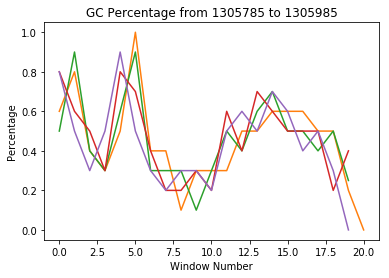

Motif locations for CG14459
GGCT: ['18', '59', '143', '151', '162']
CTCT: ['26', '31', '61', '123', '153', '164']
TCAT: ['91', '95', '107', '112', '167', '175']
TTTGC: ['3', '146', '193']
GGCTC: ['59', '151', '162']
GCTCT: ['60', '152', '163']
TCATT: ['91', '107', '112', '167']
CTGAAT: ['20', '155']
TGAATC: ['21', '156']
GGCTCT: ['59', '151', '162']
CTCTTT: ['61', '123']
TCATTC: ['91', '167']
TCATTT: ['107', '112']
CATTTC: ['108', '113']
TCCCTC: ['120', '171']
CGGCTC: ['150', '161']
CTGAATC: ['20', '155']
TCATTTC: ['107', '112']
CGGCTCT: ['150', '161']
(1305785, 1305985)


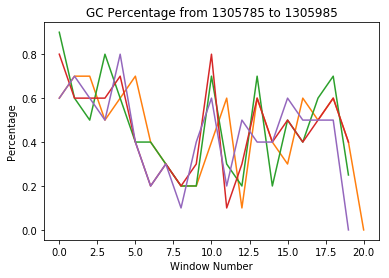

Motif locations for CG14563
CAAA: ['29', '99', '180', '192']
AAAC: ['30', '100', '125', '181']
AAAA: ['71', '72', '73', '91', '92', '123', '124']
ACGCC: ['2', '174', '185']
GCAAA: ['28', '98', '191']
CAAAC: ['29', '99', '180']
TAAAA: ['70', '90', '122']
AAAAA: ['71', '72', '91', '123']
AAACA: ['100', '125', '181']
ACCGAG: ['23', '32']
CCGAGC: ['24', '33']
CGAGCA: ['25', '34']
AGCAAA: ['27', '190']
GCAAAC: ['28', '98']
TCCATT: ['65', '147']
TTAAAA: ['69', '89']
TAAAAA: ['70', '90', '122']
CAAACA: ['99', '180']
ACACGC: ['172', '183']
CACGCC: ['173', '184']
ACGCCA: ['174', '185']
ACCGAGC: ['23', '32']
CCGAGCA: ['24', '33']
TTAAAAA: ['69', '89']
ACACGCC: ['172', '183']
CACGCCA: ['173', '184']
ACCGAGCA: ['23', '32']
ACACGCCA: ['172', '183']
(1305785, 1305985)


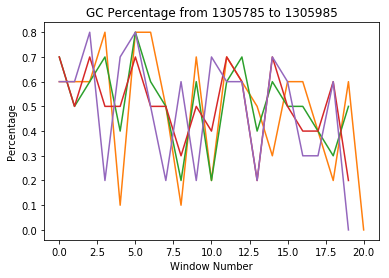

Motif locations for CG14565
GGAA: ['38', '68', '128', '156']
AATT: ['40', '83', '103', '184']
AAAT: ['82', '87', '102', '142', '172', '183']
AATTA: ['40', '83', '103']
CAAAT: ['81', '171', '182']
AAATT: ['82', '102', '183']
ACACCC: ['2', '22']
ACAGAC: ['12', '28']
TCAAAT: ['80', '170']
CAAATT: ['81', '182']
AAATTA: ['82', '102']
GAATGG: ['119', '157']
(1305785, 1305985)


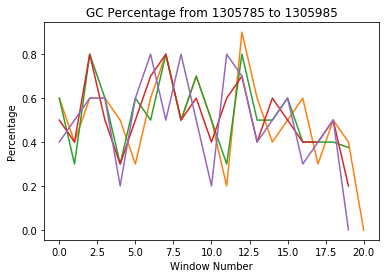

Motif locations for CG14566
CCAA: ['12', '47', '101', '137']
AGTC: ['44', '104', '140', '147']
TCCA: ['46', '70', '100', '136', '179', '193']
AAAA: ['49', '50', '51', '116']
CATC: ['98', '143', '181', '186']
CCAAG: ['12', '101', '137']
AAGTC: ['43', '103', '139']
TCCAA: ['46', '100', '136']
CATCA: ['143', '181', '186']
AAGTCC: ['43', '103']
TCCAAG: ['100', '136']
CCAAGT: ['101', '137']
CAAGTC: ['102', '138']
TCCAAGT: ['100', '136']
CCAAGTC: ['101', '137']
TCCAAGTC: ['100', '136']
(1305785, 1305985)


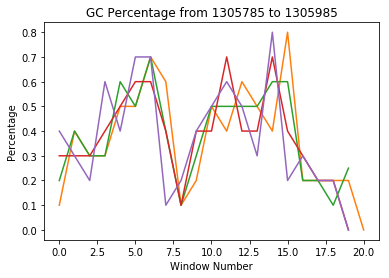

Motif locations for CG14567
TTAA: ['21', '88', '141', '187']
GAAA: ['54', '161', '175', '183']
AAAA: ['79', '162', '163', '176', '177', '195', '196']
AAAT: ['90', '164', '184', '197']
AAAAA: ['162', '176', '195']
AGTTAA: ['19', '139']
GTTAAC: ['20', '140']
TGTCTG: ['49', '106']
AAGCTG: ['56', '102']
AGAAAA: ['160', '174']
GAAAAA: ['161', '175']
AAAAAT: ['162', '195']
AGTTAAC: ['19', '139']
AGAAAAA: ['160', '174']
(1305785, 1305985)


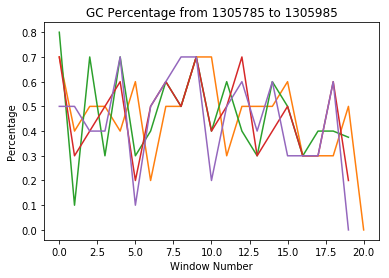

Motif locations for CG14568
GGGT: ['10', '90', '133', '157']
GGCC: ['24', '49', '79', '119']
GCCA: ['25', '80', '106', '120']
GGCCA: ['24', '79', '119']
GCCAA: ['25', '106', '120']
GGCCAA: ['24', '119']
AAATAT: ['60', '109']
GCCAAA: ['106', '120']
GGGTAT: ['133', '157']
CAACAT: ['166', '195']
(1305785, 1305985)


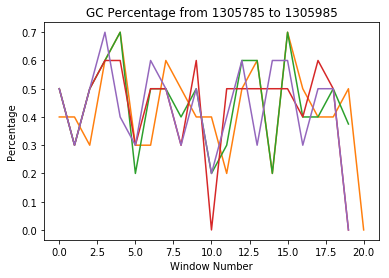

Motif locations for CG14569
AAAA: ['0', '87', '118', '196']
TCAG: ['31', '38', '45', '171']
GAAA: ['86', '93', '167', '195']
AAAT: ['108', '146', '168', '197']
CTGAA: ['25', '84', '91']
TCAGC: ['31', '38', '45']
CAGCG: ['32', '39', '46']
GTCAGC: ['30', '44']
TCAGCG: ['31', '38', '45']
CTGAAA: ['84', '91']
AAAACT: ['87', '118']
ATAAAT: ['106', '144']
GTCAGCG: ['30', '44']
(1305785, 1305985)


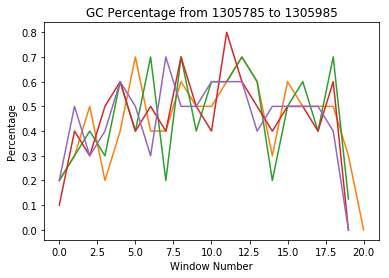

Motif locations for CG14570
CATC: ['38', '81', '131', '192']
TGGG: ['49', '101', '114', '140']
GGGC: ['50', '102', '115', '128']
GGCA: ['51', '116', '129', '188']
TGGGC: ['49', '101', '114']
GGGCA: ['50', '115', '128']
CACCAT: ['17', '167']
AGTCAT: ['35', '78']
GTCATC: ['36', '79']
CATCAA: ['38', '192']
CAATGG: ['46', '106']
TGGGCA: ['49', '114']
TTGGGC: ['100', '113']
AGTCATC: ['35', '78']
(1305785, 1305985)


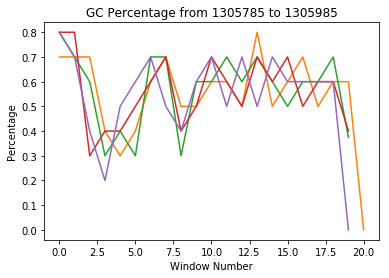

Motif locations for CG32447
GCGA: ['5', '23', '76', '93', '108', '130', '138']
CGAG: ['6', '24', '37', '67', '77', '94', '131', '139']
GAGA: ['25', '38', '68', '95', '140', '142']
GCGAG: ['5', '23', '76', '93', '130', '138']
CGCGA: ['22', '107', '137']
CGAGA: ['24', '37', '67', '94', '139']
AGAAT: ['26', '55', '87']
AACGA: ['35', '101', '178']
GAAGA: ['40', '53', '85']
AAGAA: ['41', '54', '86']
GATCG: ['104', '110', '158']
AGCGAG: ['4', '75']
GCGCGA: ['21', '136']
CGCGAG: ['22', '137']
GCGAGA: ['23', '93', '138']
CGAGAA: ['24', '37']
ACGAGA: ['36', '66']
GAAGAA: ['40', '53', '85']
AAGAAT: ['54', '86']
AGAATT: ['55', '87']
GAATTG: ['56', '88']
TGAGGG: ['60', '119']
CGAGAG: ['67', '139']
TGCGAG: ['92', '129']
CGATCG: ['103', '109']
GATCGC: ['104', '110']
ATCGCG: ['105', '111']
CCGCAT: ['150', '190']
CGCATC: ['151', '191']
GGGCAA: ['162', '174']
GCGCGAG: ['21', '136']
CGCGAGA: ['22', '137']
GAAGAAT: ['53', '85']
AAGAATT: ['54', '86']
AGAATTG: ['55', '87']
CGATCGC: ['103', '109']
GATCGCG: 

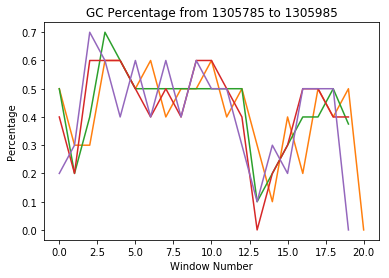

Motif locations for CG32448
TTCC: ['26', '95', '118', '166']
CACT: ['60', '72', '113', '121']
TTCA: ['70', '102', '128', '150']
TCAC: ['71', '110', '129', '194']
AATTC: ['20', '148', '164']
CACTG: ['60', '72', '113']
AGCTGA: ['46', '78']
GCTTCA: ['68', '100']
CACTGT: ['72', '113']
AAATTC: ['147', '163']
(1305785, 1305985)


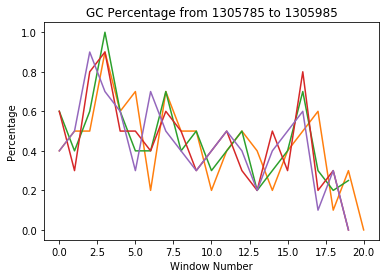

Motif locations for CG32459
TCAG: ['18', '25', '94', '107', '121', '145']
AAAA: ['65', '66', '67', '196']
AAAT: ['101', '139', '185', '197']
AATTT: ['140', '178', '186']
ATCTCA: ['22', '118']
TCTCAG: ['23', '119']
CTCAGC: ['24', '120']
AAATTT: ['139', '185']
AATTTT: ['140', '186']
ATTTTC: ['141', '187']
ATCTCAG: ['22', '118']
TCTCAGC: ['23', '119']
AAATTTT: ['139', '185']
AATTTTC: ['140', '186']
ATCTCAGC: ['22', '118']
AAATTTTC: ['139', '185']
(1305785, 1305985)


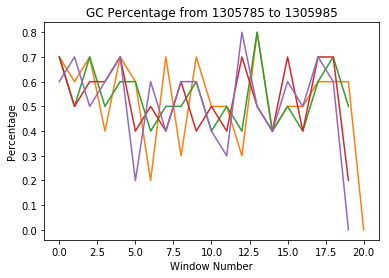

Motif locations for CG33772
CTGA: ['1', '13', '112']
CCAC: ['9', '72', '187']
GAGT: ['15', '148', '163']
TCCG: ['24', '97', '131']
ATCA: ['33', '82', '154', '170']
TCAG: ['34', '155', '171']
CAGC: ['35', '136', '190']
AGCA: ['36', '77', '137']
CAAG: ['38', '75', '84']
TTCC: ['51', '68', '96']
TTTT: ['65', '66', '121']
TGCG: ['89', '160', '176']
GGTG: ['92', '158', '174']
ATGG: ['104', '115', '126']
TGGG: ['105', '116', '127']
GGGT: ['118', '128', '183']
ATCAG: ['33', '154', '170']
ATGGG: ['104', '115', '126']
TTCCCC: ['51', '68']
AATGGG: ['103', '125']
GGGTCC: ['128', '183']
ATCAGG: ['154', '170']
TCAGGT: ['155', '171']
CAGGTG: ['156', '172']
AGGTGC: ['157', '173']
GGTGCG: ['158', '174']
ATCAGGT: ['154', '170']
TCAGGTG: ['155', '171']
CAGGTGC: ['156', '172']
AGGTGCG: ['157', '173']
ATCAGGTG: ['154', '170']
TCAGGTGC: ['155', '171']
CAGGTGCG: ['156', '172']
ATCAGGTGC: ['154', '170']
TCAGGTGCG: ['155', '171']
ATCAGGTGCG: ['154', '170']
(1305785, 1305985)


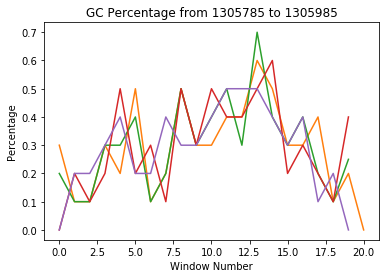

Motif locations for CG43329
TTTT: ['5', '24', '25', '26', '27', '42', '60', '94']
TTTA: ['6', '10', '28', '61', '156', '190']
TTAT: ['7', '75', '78', '127', '191']
TTTTA: ['5', '27', '60']
TTATT: ['7', '75', '191']
TTTAA: ['10', '28', '61']
AATTT: ['14', '40', '188']
GAAAC: ['19', '48', '166']
TTTTT: ['24', '25', '26']
AATGG: ['55', '70', '82']
TAATG: ['69', '81', '142']
TTTATT: ['6', '190']
TTTAAA: ['10', '28']
TTAAAT: ['11', '29']
AAATTT: ['13', '187']
TGAAAC: ['18', '47']
TTTTTT: ['24', '25']
TTTTAA: ['27', '60']
GAAACC: ['48', '166']
AATGGT: ['55', '70']
ATGGTT: ['56', '71']
CTAATG: ['68', '141']
TAATGG: ['69', '81']
TTTAAAT: ['10', '28']
AATGGTT: ['55', '70']
(1305785, 1305985)


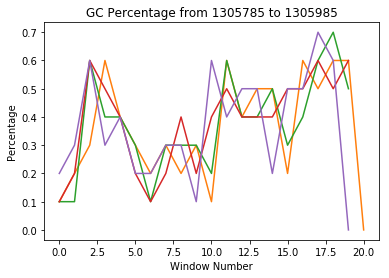

Motif locations for CG43330
TTAT: ['2', '13', '57', '154']
GATT: ['18', '93', '131', '151']
ATTT: ['19', '69', '107', '152']
TACC: ['25', '51', '171', '180']
TTTC: ['46', '70', '99', '108']
AATT: ['55', '68', '81', '106']
TCAG: ['143', '157', '189', '193']
GTACC: ['24', '50', '179']
TTGTAC: ['22', '177']
TGTACC: ['23', '178']
GTACCA: ['24', '50']
TTTCGT: ['46', '108']
AATTTC: ['68', '106']
GTCAGC: ['142', '192']
TCAGCC: ['143', '193']
CAGCCA: ['144', '194']
AGCCAT: ['145', '195']
TCAGTC: ['157', '189']
TTGTACC: ['22', '177']
GTCAGCC: ['142', '192']
TCAGCCA: ['143', '193']
CAGCCAT: ['144', '194']
GTCAGCCA: ['142', '192']
TCAGCCAT: ['143', '193']
GTCAGCCAT: ['142', '192']
(1305785, 1305985)


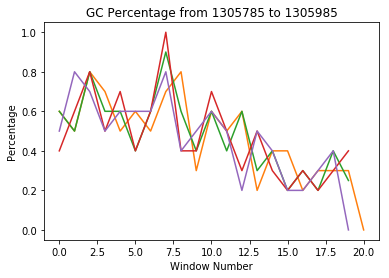

Motif locations for CG43331
CGAG: ['9', '23', '33', '88']
GAGA: ['10', '89', '91', '111']
TTTT: ['131', '132', '160', '161']
(1305785, 1305985)


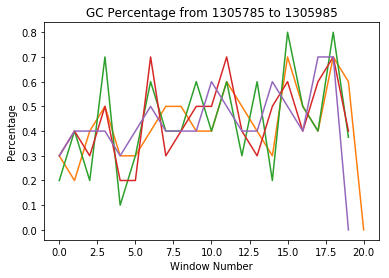

Motif locations for CG43392
GAAT: ['3', '25', '45', '135']
ACCA: ['13', '167', '170', '178']
CCGT: ['71', '85', '99', '121', '158']
GAAA: ['89', '141', '146', '163']
CCGTG: ['85', '121', '158']
CCACC: ['118', '168', '179']
ACCATT: ['13', '170']
TTTAAC: ['28', '102']
ACCGTG: ['84', '120']
GAAATG: ['89', '141']
CAGCCG: ['96', '155']
AGCCGT: ['97', '156']
ACCACC: ['167', '178']
CAGCCGT: ['96', '155']
(1305785, 1305985)


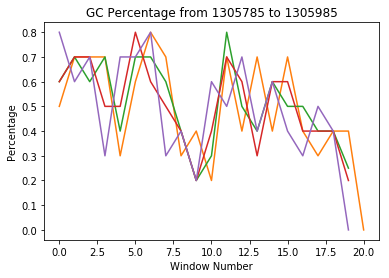

Motif locations for CG45428
GCTG: ['11', '26', '36']
GGCT: ['25', '35', '51']
GAAA: ['44', '96', '173']
AAAA: ['45', '97', '174']
CGAG: ['72', '119', '179']
GTGT: ['78', '85', '134', '136', '182']
TGTT: ['79', '86', '137']
GTTT: ['80', '87', '138']
TTTT: ['81', '139', '140']
TTTG: ['82', '88', '141']
TTGC: ['89', '154', '166']
CTTG: ['92', '153', '170']
GAAAA: ['44', '96', '173']
GTGTT: ['78', '85', '136']
TGTTT: ['79', '86', '137']
CGGCTG: ['24', '34']
GTGTTT: ['78', '85', '136']
TGTTTT: ['79', '137']
TGTGTT: ['84', '135']
TGCTTG: ['90', '151']
GAAAAT: ['96', '173']
ACACAA: ['189', '194']
GTGTTTT: ['78', '136']
TGTGTTT: ['84', '135']
(1305785, 1305985)


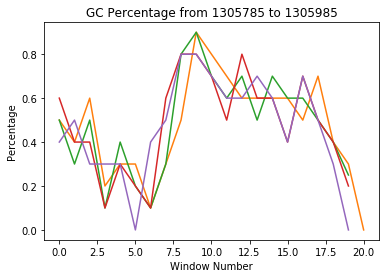

Motif locations for CG7130
ATAC: ['3', '49', '66', '80', '163']
AATA: ['40', '48', '62', '65', '71', '79']
ACCC: ['75', '82', '89', '96', '103']
TAATA: ['39', '64', '70']
AATAA: ['40', '62', '71']
AATAC: ['48', '65', '79']
CCGCA: ['92', '99', '142']
CGCAC: ['93', '100', '114']
GCACC: ['94', '101', '108', '115']
ACCAG: ['117', '156', '165']
ATTTCA: ['16', '188']
CAGCTG: ['20', '145']
TAATAA: ['39', '70']
ACCCCG: ['89', '96']
CCCCGC: ['90', '97']
CCCGCA: ['91', '98']
CCGCAC: ['92', '99']
CGCACC: ['93', '100', '114']
GCACCC: ['94', '101']
GCACCA: ['108', '115']
ACCCCGC: ['89', '96']
CCCCGCA: ['90', '97']
CCCGCAC: ['91', '98']
CCGCACC: ['92', '99']
CGCACCC: ['93', '100']
ACCCCGCA: ['89', '96']
CCCCGCAC: ['90', '97']
CCCGCACC: ['91', '98']
CCGCACCC: ['92', '99']
ACCCCGCAC: ['89', '96']
CCCCGCACC: ['90', '97']
CCCGCACCC: ['91', '98']
ACCCCGCACC: ['89', '96']
CCCCGCACCC: ['90', '97']
(1305785, 1305985)


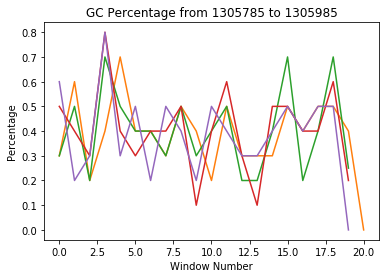

Motif locations for CG7133
ATAT: ['8', '28', '100', '139', '163']
TCCA: ['34', '117', '144', '182']
ATCG: ['37', '50', '57', '77']
CATAT: ['7', '27', '162']
AAGTA: ['22', '46', '62']
ATCGA: ['50', '57', '77']
CATATG: ['7', '162']
ATATGT: ['8', '163']
TATCGA: ['49', '76']
ATCGAA: ['57', '77']
TTTCCA: ['142', '180']
TTCCAG: ['143', '181']
CATATGT: ['7', '162']
TTTCCAG: ['142', '180']
(1305785, 1305985)


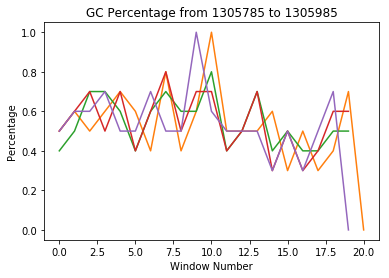

Motif locations for CG7139
TCCG: ['22', '30', '45', '82']
GGGA: ['33', '41', '72', '107']
GATC: ['35', '43', '80', '155']
GGGG: ['71', '90', '91', '99', '100', '105', '106']
ATCCG: ['21', '44', '81']
GGATC: ['34', '42', '79']
GGGGG: ['90', '99', '105']
CGGGAT: ['32', '40']
GGGATC: ['33', '41']
GGATCC: ['42', '79']
GATCCG: ['43', '80']
ATCCGA: ['44', '81']
TTGGGG: ['69', '97']
CGGGATC: ['32', '40']
GGATCCG: ['42', '79']
GATCCGA: ['43', '80']
GGATCCGA: ['42', '79']
(1305785, 1305985)


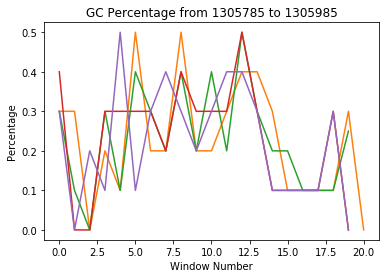

Motif locations for CG7140
AAAT: ['17', '22', '43', '171', '176', '187', '197']
AATT: ['18', '59', '157', '172', '183', '188']
ATTA: ['19', '26', '60', '149', '173', '184']
TAAA: ['21', '42', '46', '117', '175', '186']
ATAT: ['24', '29', '76', '78', '135', '147', '165']
TATA: ['28', '75', '77', '105', '146', '166']
AATTA: ['18', '59', '172', '183']
TTAAA: ['20', '116', '174', '185']
TAAAT: ['21', '42', '175', '186']
ATATT: ['24', '29', '135', '147']
TATAT: ['28', '75', '77', '146']
AATTAA: ['18', '172', '183']
ATTAAA: ['19', '173', '184']
TTAAAT: ['20', '174', '185']
TAAATA: ['21', '42', '175']
AAATTAA: ['17', '171']
AATTAAA: ['18', '172', '183']
ATTAAAT: ['19', '173', '184']
TTAAATA: ['20', '174']
ATATTAT: ['24', '147']
ATATTTT: ['29', '135']
ATTATGT: ['60', '149']
CACTTTT: ['111', '124']
AAATTAAA: ['17', '171']
AATTAAAT: ['18', '172', '183']
ATTAAATA: ['19', '173']
AAATTAAAT: ['17', '171']
AATTAAATA: ['18', '172']
AAATTAAATA: ['17', '171']
(1305785, 1305985)


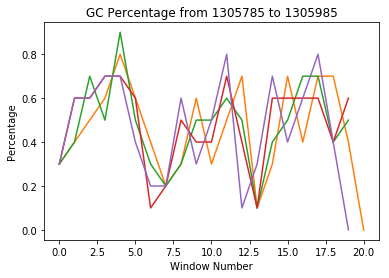

Motif locations for CG7148
GTTT: ['0', '12', '72']
TAAG: ['3', '139', '175']
TGTT: ['11', '71', '75']
GAAG: ['53', '57', '167']
AAGG: ['54', '103', '168', '193']
CGTA: ['64', '127', '173']
TTGT: ['70', '74', '90']
AAAA: ['101', '112', '159', '190', '191']
AGGC: ['124', '169', '194']
(1305785, 1305985)


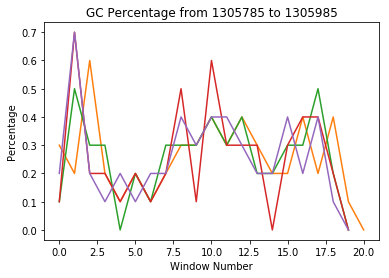

Motif locations for CG7166
TAAA: ['3', '48', '78', '96', '102', '153', '195']
AAAT: ['4', '51', '61', '103', '131', '139', '169', '197']
AAAA: ['49', '50', '59', '60', '97', '137', '138', '161', '162', '196']
ATAAA: ['2', '47', '77']
ATACA: ['6', '183', '187']
ACAAT: ['8', '39', '81']
TAAAA: ['48', '96', '195']
AAAAA: ['49', '59', '137', '161']
AAAAT: ['50', '60', '138', '196']
AAATC: ['51', '103', '131']
TACAT: ['175', '184', '188']
GATAAA: ['1', '76']
ACAATT: ['8', '39']
TTAATT: ['29', '146']
TCTAGA: ['34', '54']
AATTTT: ['41', '148']
ATTTTA: ['42', '149']
AAAAAT: ['49', '59', '137']
AGAAAA: ['57', '159']
GAAAAA: ['58', '160']
AGTAAA: ['94', '100']
TGGTTA: ['113', '143']
GGTTAA: ['114', '144']
CATACA: ['182', '186']
ATACAT: ['183', '187']
TACATA: ['184', '188']
AATTTTA: ['41', '148']
AGAAAAA: ['57', '159']
TGGTTAA: ['113', '143']
CATACAT: ['182', '186']
ATACATA: ['183', '187']
CATACATA: ['182', '186']
(1305785, 1305985)


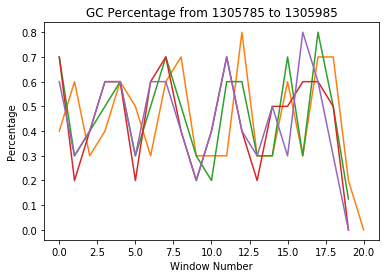

Motif locations for CG7173
AAAG: ['20', '24', '55', '61', '94']
AAGA: ['21', '56', '62', '95', '167']
GAAA: ['23', '54', '58', '93', '97', '162', '195']
AAAGA: ['20', '55', '61', '94']
AAGAA: ['21', '56', '62', '95']
AGAAA: ['22', '57', '96']
GAAAG: ['23', '54', '93']
CGTGG: ['48', '81', '158']
AAAGAA: ['20', '55', '61', '94']
AAGAAA: ['21', '56', '95']
GAGATC: ['29', '43']
TCGTGG: ['47', '157']
CGAAAG: ['53', '92']
GAAAGA: ['54', '93']
GGAACT: ['114', '125']
GAACTG: ['115', '126']
AAAGAAA: ['20', '55', '94']
CGAAAGA: ['53', '92']
GAAAGAA: ['54', '93']
GGAACTG: ['114', '125']
CGAAAGAA: ['53', '92']
GAAAGAAA: ['54', '93']
CGAAAGAAA: ['53', '92']
(1305785, 1305985)


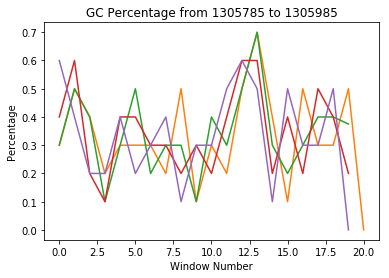

Motif locations for CG7202
AAAC: ['4', '12', '19', '43', '124']
TTTT: ['90', '95', '113', '114', '151', '152']
CACA: ['118', '161', '163', '176', '178', '183']
CTGCT: ['7', '128', '137']
ACTTT: ['88', '104', '111']
TTTCA: ['96', '106', '115']
CACAC: ['118', '161', '176']
ACACA: ['162', '177', '182']
AAACTG: ['4', '43']
TCAACT: ['85', '108']
CAACTT: ['86', '109']
AACTTT: ['87', '110']
ACTTTT: ['88', '111']
TTTTAT: ['90', '152']
TTTTCA: ['95', '114']
ACCTGC: ['126', '135']
CCTGCT: ['127', '136']
CTGCTC: ['128', '137']
TGCTCG: ['129', '138']
GCTCGA: ['130', '139']
CACACA: ['161', '176']
ACACAA: ['177', '182']
TCAACTT: ['85', '108']
CAACTTT: ['86', '109']
AACTTTT: ['87', '110']
ACCTGCT: ['126', '135']
CCTGCTC: ['127', '136']
CTGCTCG: ['128', '137']
TGCTCGA: ['129', '138']
TCAACTTT: ['85', '108']
CAACTTTT: ['86', '109']
ACCTGCTC: ['126', '135']
CCTGCTCG: ['127', '136']
CTGCTCGA: ['128', '137']
TCAACTTTT: ['85', '108']
ACCTGCTCG: ['126', '135']
CCTGCTCGA: ['127', '136']
ACCTGCTCGA: ['126', '

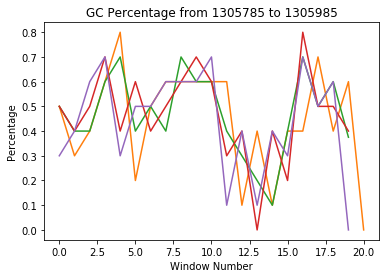

Motif locations for CG8765
ACAA: ['0', '14', '51', '147']
AACA: ['16', '146', '162', '193']
ACAC: ['17', '163', '165', '194']
CCAG: ['37', '78', '100', '171']
TTTT: ['120', '121', '126', '127', '136']
AACAC: ['16', '162', '193']
(1305785, 1305985)


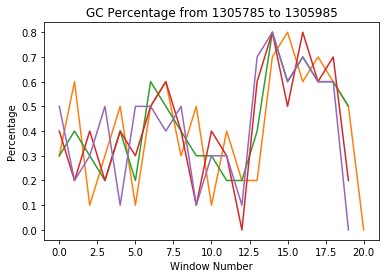

Motif locations for CG8786
AACA: ['8', '51', '95', '135', '196']
ATTT: ['57', '99', '114', '129', '161']
ACGA: ['69', '138', '141', '144', '158', '177']
TTTT: ['100', '101', '102', '103', '115']
TTAAA: ['5', '20', '131']
TTTTT: ['100', '101', '102']
TTTGT: ['104', '116', '120']
ACGAC: ['138', '141', '144']
CGACG: ['139', '142', '145']
GACGA: ['140', '143', '176']
TTTAAA: ['4', '130']
GGTCAC: ['12', '78']
GTCACA: ['13', '79']
TCACAC: ['14', '80']
CACACT: ['15', '81']
ACACTT: ['16', '82']
CACTTA: ['17', '83']
ACGAGA: ['69', '177']
GCAGCA: ['90', '153']
TTTTTT: ['100', '101']
TTTTGT: ['103', '115']
TTTGTT: ['104', '116']
TTGTTT: ['105', '117']
ACGACG: ['138', '141', '144']
CGACGA: ['139', '142']
GACGAC: ['140', '143']
GGTCACA: ['12', '78']
GTCACAC: ['13', '79']
TCACACT: ['14', '80']
CACACTT: ['15', '81']
ACACTTA: ['16', '82']
TTTTGTT: ['103', '115']
TTTGTTT: ['104', '116']
ACGACGA: ['138', '141']
CGACGAC: ['139', '142']
GACGACG: ['140', '143']
GGTCACAC: ['12', '78']
GTCACACT: ['13', '79']

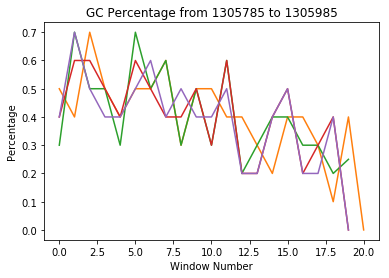

Motif locations for CG9231
CTGT: ['1', '6', '107', '124']
TGTT: ['2', '7', '125', '170']
TTAA: ['9', '49', '127', '172', '185']
GATT: ['46', '151', '164', '182']
TAAA: ['128', '141', '173', '186']
AAAA: ['129', '142', '174', '196']
CTGTT: ['1', '6', '124']
TGTTA: ['7', '125', '170']
GTTAA: ['8', '126', '171']
GATTT: ['46', '151', '182']
TTAAA: ['127', '172', '185']
TAAAA: ['128', '141', '173']
CTGTTA: ['6', '124']
TGTTAA: ['7', '125', '170']
GGATTT: ['45', '150']
GATTTA: ['46', '182']
ATTTAA: ['47', '183']
GTTAAA: ['126', '171']
TTAAAA: ['127', '172']
TAAAAG: ['128', '173']
CTGTTAA: ['6', '124']
GATTTAA: ['46', '182']
TGTTAAA: ['125', '170']
GTTAAAA: ['126', '171']
TTAAAAG: ['127', '172']
TGTTAAAA: ['125', '170']
GTTAAAAG: ['126', '171']
TGTTAAAAG: ['125', '170']
(1305785, 1305985)


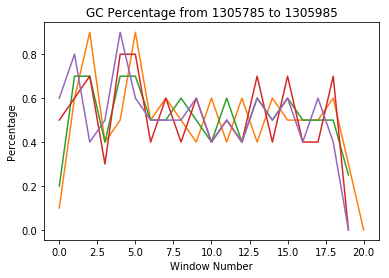

Motif locations for CG9279
TTGC: ['18', '93', '111']
TGAC: ['40', '72', '178']
GACT: ['41', '73', '145']
CTGG: ['47', '125', '156']
TGGG: ['48', '53', '126', '157']
CACA: ['65', '134', '171']
ATGA: ['68', '71', '177']
CATC: ['85', '141', '149']
TGCT: ['94', '101', '119']
CAAG: ['114', '165', '173']
CCAA: ['152', '164', '188']
CTGGG: ['47', '125', '156']
GATGAC: ['70', '176']
GTTTTG: ['90', '108']
TTTTGC: ['91', '109']
AACTGG: ['123', '154']
ACTGGG: ['124', '155']
GTTTTGC: ['90', '108']
AACTGGG: ['123', '154']
(1305785, 1305985)


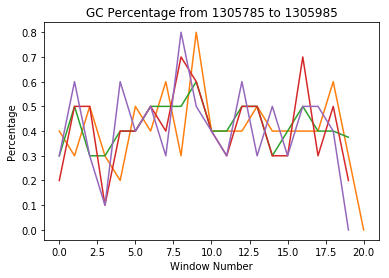

Motif locations for COX8
TTTT: ['5', '163', '177']
AATG: ['12', '61', '118']
AAGC: ['17', '138', '184']
AGCA: ['18', '48', '139', '155', '185']
GTGA: ['26', '72', '193']
ATTT: ['39', '162', '176']
TGAC: ['73', '120', '194']
GACA: ['74', '79', '121', '195']
ACAA: ['80', '122', '196']
TCGC: ['87', '127', '166']
GAAG: ['131', '137', '183']
AAGCA: ['17', '138', '184']
TGACA: ['73', '120', '194']
GACAA: ['79', '121', '195']
AGCAGA: ['48', '185']
GTGACA: ['72', '193']
GACAAA: ['79', '121']
AAATCG: ['84', '124']
AATCGC: ['85', '125']
ATCGCG: ['86', '126']
TGACAA: ['120', '194']
GAAGCA: ['137', '183']
AGCATT: ['139', '155']
ATTTTC: ['162', '176']
AAATCGC: ['84', '124']
AATCGCG: ['85', '125']
AAATCGCG: ['84', '124']
(1305785, 1305985)


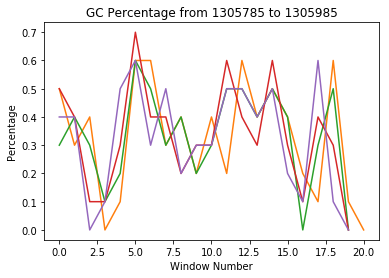

Motif locations for CRIF
ATTG: ['10', '15', '94', '132', '158']
AAAT: ['28', '45', '163', '167', '197']
TAAA: ['41', '75', '166', '170', '195']
AAAA: ['42', '43', '44', '125', '196']
AAATA: ['45', '163', '167']
GATAGC: ['2', '116']
ATTGGA: ['10', '158']
CGTTCT: ['65', '79']
AAATAA: ['163', '167']
AATAAA: ['164', '168']
AAATAAA: ['163', '167']
(1305785, 1305985)


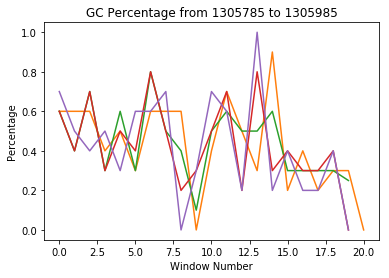

Motif locations for CapaR
GCGG: ['11', '25', '139', '142']
GTGT: ['51', '73', '113', '191']
TAAA: ['90', '98', '150', '171']
AAAA: ['91', '92', '93', '151', '152', '196']
AAAT: ['94', '105', '168', '197']
AAAC: ['99', '153', '172', '177']
AAAAA: ['91', '92', '151']
CTGCGG: ['9', '23']
TGTTTC: ['74', '157']
TAAAAA: ['90', '150']
(1305785, 1305985)


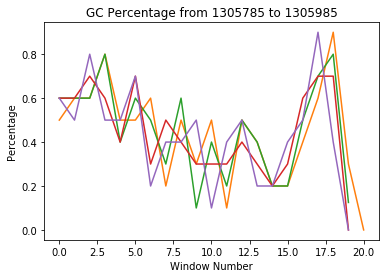

Motif locations for Chro
ACAC: ['0', '2', '53', '55', '135', '169']
CACA: ['1', '54', '168', '170']
TTTT: ['72', '73', '74', '94']
TAAA: ['97', '116', '143', '157']
ACACA: ['0', '53', '169']
CACAC: ['1', '54', '168']
ACACAC: ['0', '53']
CACACC: ['1', '54']
TTAAAA: ['96', '142']
TAAAAG: ['97', '143']
GAATAA: ['108', '194']
ACACACC: ['0', '53']
TTAAAAG: ['96', '142']
(1305785, 1305985)


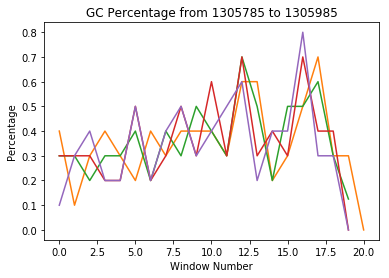

Motif locations for Cpr76Ba
AAAA: ['8', '14', '25', '26', '118', '196']
ATTT: ['17', '38', '51', '82', '163']
TTTT: ['39', '40', '52', '53', '54', '69', '70', '71']
AAAAT: ['8', '14', '26', '196']
TATTT: ['37', '50', '81']
TTTTT: ['39', '52', '53', '69', '70']
GAAAAT: ['7', '13']
AAAATT: ['14', '26']
GAGGTA: ['33', '111']
AGGTAT: ['34', '112']
TATTTT: ['37', '50']
ATTTTT: ['38', '51']
TTTTTC: ['39', '70']
CCTATT: ['48', '79']
CTATTT: ['49', '80']
TTTTTT: ['52', '69']
ATTTAG: ['82', '163']
CCAACT: ['135', '190']
GAGGTAT: ['33', '111']
TATTTTT: ['37', '50']
CCTATTT: ['48', '79']
(1305785, 1305985)


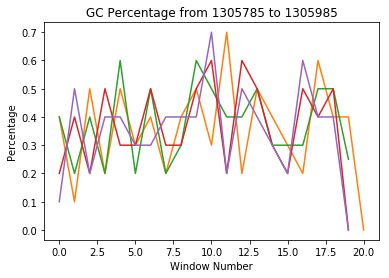

Motif locations for Cpr76Ba_alpha
AAAA: ['10', '11', '17', '122', '196']
CATT: ['38', '86', '127', '160']
TTTT: ['60', '61', '76', '77', '78', '156']
TTTTT: ['60', '76', '77']
GGCTGA: ['43', '111']
TGGGCT: ['109', '130']
(1305785, 1305985)


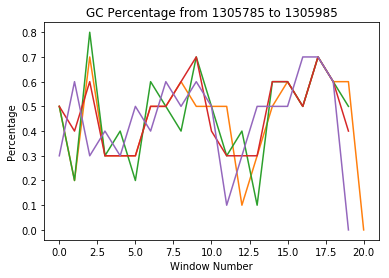

Motif locations for Cpr78E
GTAA: ['16', '56', '60', '89']
AGCA: ['92', '104', '193', '196']
CAGC: ['103', '172', '176', '192', '195']
GTAAG: ['56', '60', '89']
CAGCA: ['103', '192', '195']
AAGTAA: ['14', '58']
GTAAGT: ['56', '60']
(1305785, 1305985)


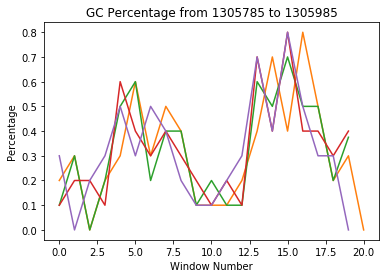

Motif locations for DNApol
ATTT: ['5', '39', '81', '98', '105', '125', '171']
AATA: ['20', '24', '28', '91', '180', '183']
ATAT: ['29', '35', '37', '62', '92', '113', '118']
TTTT: ['40', '41', '99', '106', '107', '126']
AATTT: ['4', '80', '170']
AAATA: ['19', '23', '27', '90']
AATAA: ['20', '24', '180']
TATAT: ['36', '112', '117']
ATATT: ['37', '62', '113']
TATTT: ['38', '104', '124']
ATTTT: ['39', '98', '105', '125']
GAATTT: ['3', '79']
TTTAAA: ['6', '127']
TTAAAA: ['7', '128']
TAAAAA: ['8', '129']
AAATAA: ['19', '23']
AATAAA: ['20', '24']
ATAAAT: ['21', '25']
TAAATA: ['22', '26']
AAATAT: ['27', '90']
ATATGG: ['29', '118']
GGATAT: ['33', '60']
TATATT: ['36', '112']
TATTTT: ['38', '104', '124']
ATTTTT: ['39', '105']
TTTTTC: ['40', '106']
TTTCGC: ['42', '172']
ATATTA: ['62', '113']
TATTAT: ['63', '114']
GTATTT: ['103', '123']
TTTAAAA: ['6', '127']
TTAAAAA: ['7', '128']
AAATAAA: ['19', '23']
AATAAAT: ['20', '24']
ATAAATA: ['21', '25']
TATTTTT: ['38', '104']
ATTTTTC: ['39', '105']
ATATTAT

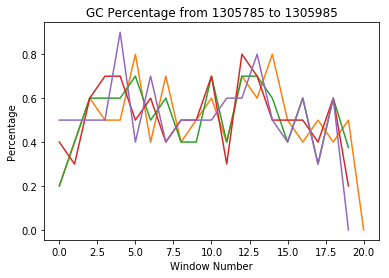

Motif locations for Glg1
TGTT: ['19', '22', '114']
GCCA: ['28', '129', '169']
CAAA: ['30', '97', '194']
AGCA: ['34', '95', '192']
CAGC: ['36', '72', '167', '191']
CGCA: ['39', '91', '145']
ATCG: ['42', '47', '153']
TCGA: ['43', '56', '119']
AAAC: ['67', '99', '195']
ACCC: ['69', '103', '188']
CCAG: ['71', '170', '190']
GCAA: ['92', '96', '193']
AGAC: ['136', '164', '175', '182']
CAGA: ['147', '163', '171']
(1305785, 1305985)


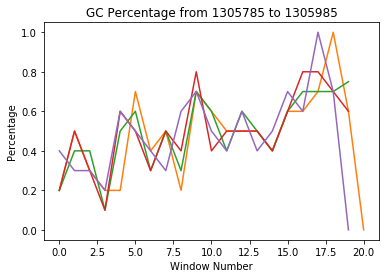

Motif locations for Gyc76C
GTTT: ['0', '13', '63', '85']
TTTT: ['1', '35', '36', '86']
TTTG: ['8', '14', '20', '87']
TGCA: ['31', '44', '71', '136']
TCCT: ['54', '75', '98', '128']
CTCC: ['93', '97', '122', '130']
(1305785, 1305985)


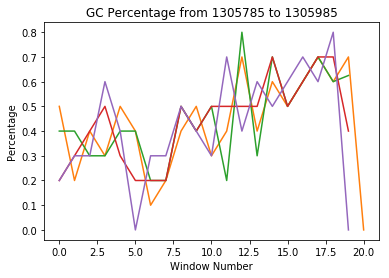

Motif locations for Hem
AAAA: ['7', '72', '113', '114', '115', '155']
AAGA: ['12', '15', '18', '74']
TTTT: ['35', '48', '49', '50']
GTCG: ['41', '159', '176', '179']
TCGC: ['42', '121', '160', '180']
GCCA: ['55', '110', '123', '169', '189']
CAGC: ['125', '167', '187', '191']
GAAAA: ['6', '71', '154']
AATAA: ['9', '63', '77']
AAGAA: ['12', '15', '74']
TGTGT: ['26', '38', '136']
GTCGC: ['41', '159', '179']
AAAAG: ['72', '115', '155']
CCGAAA: ['4', '152']
CGAAAA: ['5', '153']
AATAAG: ['9', '77']
AAGAAG: ['12', '15']
AGAAGA: ['13', '16']
TTTGTG: ['36', '134']
TTGTGT: ['37', '135']
GAAAAG: ['71', '154']
AGGGCT: ['86', '96']
AAAAGT: ['115', '155']
GCCAGC: ['123', '189']
CCAGCG: ['124', '190']
CAGCCA: ['167', '187']
TCGTCG: ['174', '177']
CCGAAAA: ['4', '152']
AAGAAGA: ['12', '15']
TTTGTGT: ['36', '134']
GCCAGCG: ['123', '189']
(1305785, 1305985)


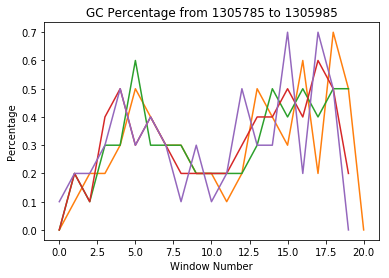

Motif locations for Hr78
TTTA: ['5', '9', '63', '81', '115', '123']
AAAA: ['23', '28', '29', '102', '103', '104', '126']
AAAC: ['24', '34', '118', '127', '132']
TTTAA: ['9', '115', '123']
TTAAA: ['10', '116', '124']
AAAAA: ['28', '102', '103']
AAACC: ['34', '118', '127', '132']
TTTGC: ['140', '156', '177']
ATTTTA: ['3', '113']
TTTAAA: ['9', '115', '123']
CAAAAA: ['27', '101']
TAAACC: ['33', '117']
AAACCA: ['34', '127']
AACCAA: ['35', '128']
CTACTG: ['48', '55']
TTAGTT: ['77', '82']
TTCATT: ['86', '90']
TTTTGC: ['155', '176']
AAACCAA: ['34', '127']
(1305785, 1305985)


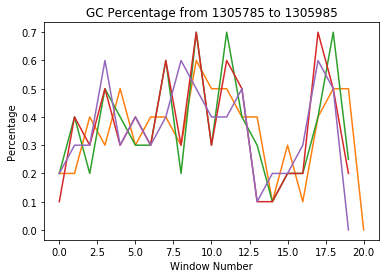

Motif locations for Lon
ATAC: ['0', '58', '74', '147']
TATT: ['10', '85', '151', '161']
ATTT: ['11', '86', '125', '152', '162']
TTTT: ['12', '87', '142', '143']
CTAT: ['48', '61', '84', '150']
TATTT: ['10', '85', '151', '161']
ACTAT: ['47', '60', '149']
TATTTT: ['10', '85']
TAGTTA: ['31', '157']
ACTATC: ['47', '60']
ATACTA: ['58', '147']
TACTAT: ['59', '148']
CTATTT: ['84', '150']
AAATTG: ['136', '172']
TATTTC: ['151', '161']
ATTTCT: ['152', '162']
TTTCTA: ['153', '163']
ATACTAT: ['58', '147']
TATTTCT: ['151', '161']
ATTTCTA: ['152', '162']
TATTTCTA: ['151', '161']
(1305785, 1305985)


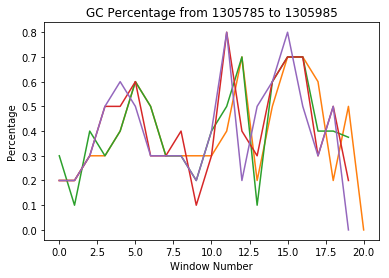

Motif locations for Ltn1
ATAC: ['0', '49', '102', '139']
TTAA: ['11', '74', '96', '132']
TAAA: ['12', '87', '97', '133']
AACA: ['14', '30', '89', '107']
AAGA: ['27', '182', '185', '188']
AGAA: ['28', '110', '183', '186', '195']
AATA: ['33', '48', '101', '138']
AAAA: ['98', '99', '112', '113', '134', '135', '136']
TTAAA: ['11', '96', '132']
GAAGA: ['26', '184', '187']
AAGAA: ['27', '182', '185']
AATAC: ['48', '101', '138']
CTTAA: ['73', '95', '131']
AAAAA: ['98', '112', '134', '135']
TAAACA: ['12', '87']
AAACAT: ['13', '88']
GAAGAA: ['26', '184']
AATACC: ['48', '101']
ACCCCA: ['51', '62']
CCACGT: ['54', '167']
CACGTG: ['55', '168']
GCTTAA: ['94', '130']
CTTAAA: ['95', '131']
TTAAAA: ['96', '132']
TAAAAA: ['97', '133']
AAAAAT: ['98', '135']
AAAATA: ['99', '136']
AAATAC: ['100', '137']
CAGAAA: ['109', '194']
TGCCGG: ['121', '156']
GCCGGA: ['122', '157']
CCGGAC: ['123', '158']
AAGAAG: ['182', '185']
AGAAGA: ['183', '186']
TAAACAT: ['12', '87']
CCACGTG: ['54', '167']
GCTTAAA: ['94', '130']


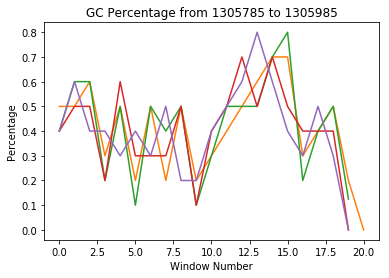

Motif locations for MED1
GTTT: ['7', '41', '76', '92']
TTTT: ['8', '34', '42', '57', '58', '59', '93', '94']
AAGT: ['74', '98', '166', '187']
GTTTT: ['7', '41', '92']
TTTTT: ['57', '58', '93']
AGAAGT: ['72', '185']
TTAAGT: ['96', '164']
TGCCGG: ['142', '151']
(1305785, 1305985)


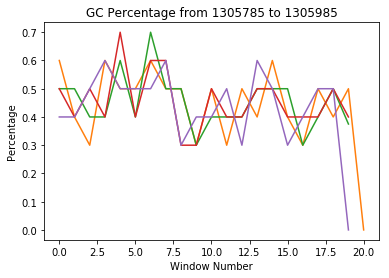

Motif locations for Mkrn1
TTGT: ['25', '34', '154', '164']
TTTC: ['88', '122', '129', '134']
CCTT: ['91', '101', '132', '179']
CTTT: ['92', '127', '133', '180']
CCTTT: ['91', '132', '179']
TTTCCT: ['88', '129']
TTCCTT: ['89', '130']
TCCTTT: ['90', '131']
ACTAAC: ['96', '115']
TTTCCTT: ['88', '129']
TTCCTTT: ['89', '130']
TTTCCTTT: ['88', '129']
(1305785, 1305985)


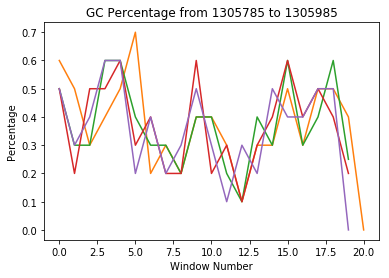

Motif locations for Neu2
TGTT: ['13', '132', '141', '174']
TTTC: ['23', '64', '78', '144']
TTTT: ['63', '111', '112', '143']
TTTG: ['113', '134', '167', '176']
TGTTT: ['132', '141', '174']
TTTCAG: ['23', '144']
AGGACC: ['46', '95']
TCTTAA: ['80', '86']
TATGTT: ['130', '139']
ATGTTT: ['131', '140']
TGTTTG: ['132', '174']
TATGTTT: ['130', '139']
(1305785, 1305985)


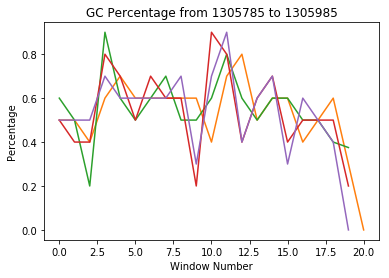

Motif locations for Oat
AAGC: ['0', '57', '104', '145']
AGAA: ['15', '27', '160', '183']
CCAT: ['21', '63', '172', '188']
CAGAA: ['14', '26', '182']
GCAAGC: ['55', '143']
GGGTTC: ['67', '74']
GTTCTC: ['76', '86']
TCTCCG: ['78', '90']
ACCCAT: ['170', '186']
(1305785, 1305985)


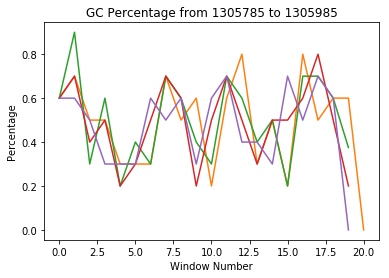

Motif locations for P5CDh1
CGAC: ['5', '122', '125', '128', '192']
ACTC: ['7', '137', '159']
CCCC: ['19', '20', '181', '182']
CCCA: ['21', '91', '183']
CCAA: ['22', '33', '184']
AATG: ['24', '48', '52']
AAAT: ['47', '102', '186']
CAAA: ['100', '131', '185']
ACGA: ['116', '124', '127']
GACA: ['129', '175', '193']
AAGA: ['133', '144', '196']
(1305785, 1305985)


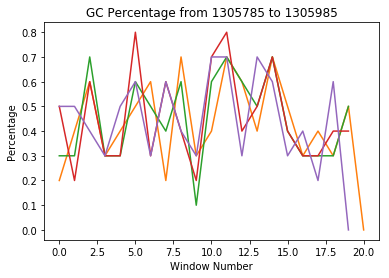

Motif locations for Rich
GTAA: ['0', '41', '72', '84', '98', '180']
TAAA: ['1', '42', '73', '99']
TTTT: ['16', '17', '134', '135', '165', '166', '185']
AATG: ['33', '95', '101', '158']
ATGT: ['34', '70', '96', '102']
GTTT: ['36', '133', '164', '171']
GTAAA: ['0', '41', '72', '98']
TAAAA: ['1', '42', '73']
TTTTT: ['16', '134', '165']
AATGT: ['33', '95', '101']
ATGTA: ['70', '96', '102']
TTTTC: ['135', '166', '185']
GTAAAA: ['0', '41', '72']
ACTTTT: ['14', '183']
TTTGTT: ['18', '172']
TGCTAA: ['48', '154']
GCTAAT: ['49', '155']
TGGGCG: ['55', '79']
ATGTAA: ['70', '96']
TGTAAA: ['71', '97']
AATGTA: ['95', '101']
GTTTTT: ['133', '164']
TTTTTC: ['134', '165']
TGCTAAT: ['48', '154']
ATGTAAA: ['70', '96']
GTTTTTC: ['133', '164']
(1305785, 1305985)


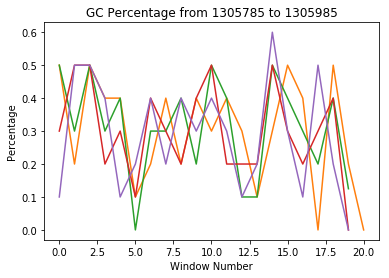

Motif locations for S1P
TTTT: ['8', '54', '55', '60', '61', '78', '79', '87', '135', '136', '164']
ATTT: ['25', '38', '53', '59', '86', '130']
TATT: ['37', '52', '58', '85', '129', '139']
TTTTC: ['8', '61', '87', '164']
TATTT: ['37', '52', '58', '85', '129']
TTTTT: ['54', '60', '78', '135']
AACAGC: ['0', '108']
CTTTTC: ['7', '163']
TTTTCA: ['8', '61']
TATTTG: ['37', '129']
ATTTGT: ['38', '130']
GTATTT: ['51', '84']
TATTTT: ['52', '58', '85']
ATTTTT: ['53', '59']
TTTTTA: ['54', '135']
TTTTAT: ['55', '136']
TTTATT: ['56', '127', '137']
TTATTT: ['57', '128']
TTTGGT: ['71', '80']
TGTTTT: ['76', '133']
GTTTTT: ['77', '134']
TTTGTT: ['123', '131']
TTGTTT: ['124', '132']
TCAGAA: ['142', '187']
CAGAAA: ['143', '188']
ATTAAA: ['170', '175']
TTAAAT: ['171', '195']
TATTTGT: ['37', '129']
GTATTTT: ['51', '84']
TATTTTT: ['52', '58']
TTTTTAT: ['54', '135']
TTTTATT: ['55', '136']
TTTATTT: ['56', '127']
TGTTTTT: ['76', '133']
TTTGTTT: ['123', '131']
TCAGAAA: ['142', '187']
TTTTTATT: ['54', '135']
(130

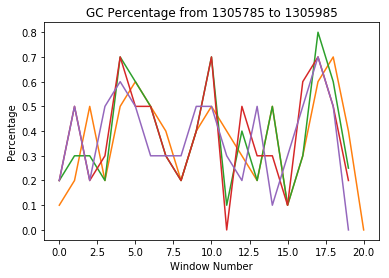

Motif locations for SAK
AAAT: ['0', '12', '37', '116', '162']
TTTT: ['29', '119', '120', '121', '122', '155']
TTTA: ['30', '84', '91', '136', '156']
ATTTT: ['28', '118', '154']
TGGTT: ['81', '142', '146']
GTTTA: ['83', '90', '135']
TTTTT: ['119', '120', '121']
TCAAAT: ['10', '114']
ATTTTA: ['28', '154']
AAATTT: ['37', '116']
TTGGCT: ['49', '124']
GTTGGT: ['79', '144']
TTGGTT: ['80', '145']
GTTTAC: ['90', '135']
TTTTTT: ['119', '120']
TTGTTT: ['129', '133']
TGGTTG: ['142', '146']
GTTGGTT: ['79', '144']
(1305785, 1305985)


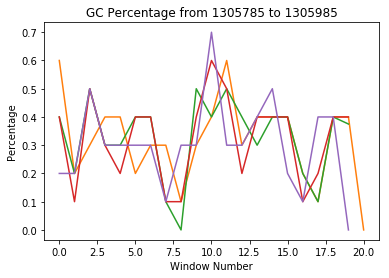

Motif locations for Sfp78E
AAAA: ['15', '16', '51', '83', '125']
AAAT: ['17', '52', '84', '126', '173']
TCTA: ['33', '42', '48', '66', '80', '151']
AAAAT: ['16', '51', '83', '125']
TCTAC: ['33', '42', '151']
TTCTA: ['47', '79', '150']
GGAAAA: ['13', '123']
TCTACA: ['33', '151']
TTCTAA: ['47', '79']
TCTAAA: ['48', '80']
CTAAAA: ['49', '81']
TAAAAT: ['50', '82']
TATTTT: ['75', '176']
TCAGGA: ['120', '183']
CAGGAA: ['121', '184']
AGAATC: ['142', '189']
TTCTAAA: ['47', '79']
TCTAAAA: ['48', '80']
CTAAAAT: ['49', '81']
TCAGGAA: ['120', '183']
TTCTAAAA: ['47', '79']
TCTAAAAT: ['48', '80']
TTCTAAAAT: ['47', '79']
(1305785, 1305985)


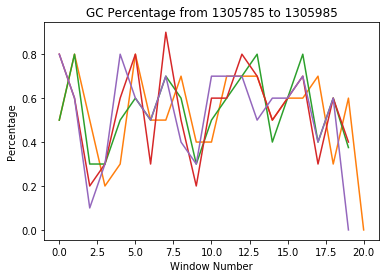

Motif locations for Shal
ATAG: ['4', '35', '97', '194']
GGAC: ['8', '19', '51', '172']
CAGC: ['15', '110', '135', '167']
GGAG: ['38', '77', '141', '154']
CCCC: ['56', '81', '82', '190']
CCCA: ['57', '83', '133', '191']
AGCC: ['79', '111', '116', '168']
AATAG: ['3', '34', '96']
CGGAC: ['18', '50', '171']
CCCCA: ['56', '82', '190']
AATAGG: ['3', '34']
AAATAG: ['33', '95']
CCGGAC: ['49', '170']
CCCCAT: ['56', '190']
(1305785, 1305985)


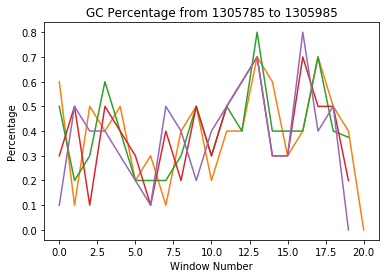

Motif locations for Syn1
TTTT: ['13', '29', '57', '75']
ATCA: ['50', '148', '165', '196']
CAAT: ['52', '65', '80', '177']
AATC: ['53', '66', '81', '178', '195']
ATTTT: ['12', '28', '74']
CAATC: ['52', '65', '80', '177']
ATTTTA: ['12', '28']
TAATTT: ['26', '72']
AATTTT: ['27', '73']
CAATCT: ['52', '65']
AATCTT: ['53', '66']
ATCTTT: ['54', '67']
TAATTTT: ['26', '72']
CAATCTT: ['52', '65']
AATCTTT: ['53', '66']
CAATCTTT: ['52', '65']
(1305785, 1305985)


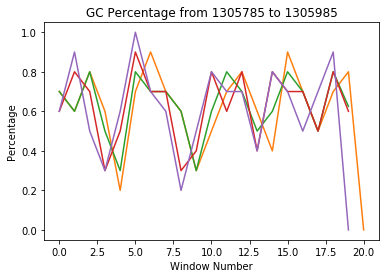

Motif locations for Ten
CCGC: ['4', '23', '59', '83', '126', '181', '194']
CGCC: ['60', '84', '111', '127', '195']
CACG: ['109', '118', '132', '156', '162']
CCGCC: ['59', '83', '126', '194']
CGCCA: ['84', '127', '195']
CACGG: ['132', '156', '162']
ACGGA: ['133', '157', '163']
CGGAC: ['134', '158', '164']
ACGAC: ['146', '167', '170']
CGACG: ['147', '168', '171']
GACGA: ['166', '169', '172']
CCGCCA: ['83', '126', '194']
CACGGA: ['132', '156', '162']
ACGGAC: ['133', '157', '163']
ACGACG: ['146', '167', '170']
GCCAAGA: ['66', '85']
ACCGCCA: ['125', '193']
ACACGGA: ['131', '161']
CACGGAC: ['132', '156', '162']
ACGGACA: ['133', '157']
GACGACG: ['166', '169']
ACGACGA: ['167', '170']
ACACGGAC: ['131', '161']
CACGGACA: ['132', '156']
GACGACGA: ['166', '169']
(1305785, 1305985)


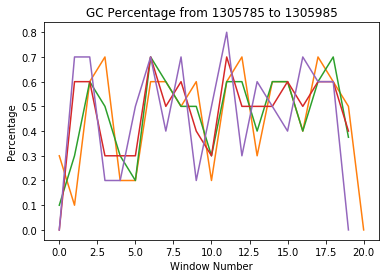

Motif locations for Trpml
ATTT: ['5', '10', '15', '165']
AATT: ['9', '14', '40', '51']
CCTC: ['64', '69', '72', '171']
TTAAT: ['7', '12', '38']
TAATT: ['8', '13', '39']
CCTCC: ['64', '69', '72']
ATTTAA: ['5', '10']
TTTAAT: ['6', '11']
TTAATT: ['7', '12', '38']
TAATTT: ['8', '13']
ATTTAAT: ['5', '10']
TTTAATT: ['6', '11']
TTAATTT: ['7', '12']
ATTTAATT: ['5', '10']
TTTAATTT: ['6', '11']
ATTTAATTT: ['5', '10']
(1305785, 1305985)


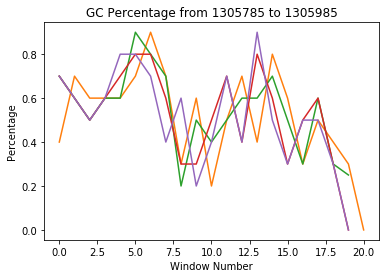

Motif locations for Wnk
CCCC: ['47', '61', '67', '77', '118', '139']
CCCT: ['48', '62', '68', '78', '119']
CTGC: ['64', '70', '92', '121', '177', '180']
TCCCC: ['46', '76', '138']
CCCCT: ['47', '61', '67', '77', '118']
CCCTG: ['62', '68', '119']
CCTGC: ['63', '69', '120']
CTGCC: ['64', '70', '92', '121']
CCCCTG: ['61', '67', '118']
CCCTGC: ['62', '68', '119']
CCTGCC: ['63', '69', '120']
GCCCCTG: ['60', '66']
CCCCTGC: ['61', '67', '118']
CCCTGCC: ['62', '68', '119']
CATCCCC: ['74', '136']
GCCCCTGC: ['60', '66']
CCCCTGCC: ['61', '67', '118']
GCCCCTGCC: ['60', '66']
(1305785, 1305985)


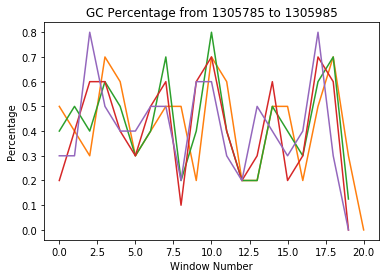

Motif locations for ash1
TAAA: ['6', '25', '126', '136']
AAAA: ['7', '8', '54', '137', '160', '161', '194']
TTTT: ['88', '89', '90', '91', '92', '93']
AAAAC: ['8', '54', '161']
TTAAA: ['24', '125', '135']
TTTTT: ['88', '89', '90', '91', '92']
CGTCG: ['100', '103', '106']
AAAAAC: ['7', '160']
AACTCA: ['10', '15']
TCACCA: ['18', '144']
ATTAAA: ['23', '134']
AAGAGT: ['83', '139']
TTTTTT: ['88', '89', '90', '91']
CGTCGT: ['100', '103']
GTCGTC: ['101', '104']
TCGTCG: ['102', '105']
TTTTTTT: ['88', '89', '90']
CGTCGTC: ['100', '103']
GTCGTCG: ['101', '104']
TTTTTTTT: ['88', '89']
CGTCGTCG: ['100', '103']
(1305785, 1305985)


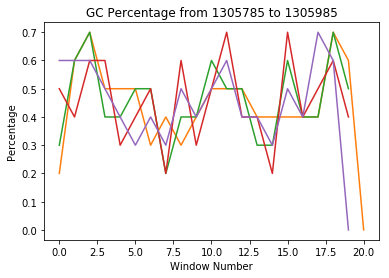

Motif locations for jim
GAAA: ['0', '17', '103', '147']
AAAC: ['1', '18', '52', '99']
CAAA: ['4', '47', '59', '126']
ATAA: ['7', '32', '73', '81', '151']
AACC: ['9', '19', '53', '172']
CAGC: ['24', '155', '191', '194']
AAAA: ['48', '49', '50', '51', '60', '61', '148']
GCAA: ['58', '125', '170', '196']
AAAG: ['83', '104', '127', '167']
AATAA: ['6', '80', '150']
AAAAA: ['48', '49', '50', '60']
AAATAA: ['5', '149']
AATAAC: ['6', '150']
AACCGG: ['9', '53']
ACCGGC: ['10', '54']
CCGGCA: ['11', '55']
CCACAG: ['21', '119']
GAGCCA: ['43', '116']
CAAAAA: ['47', '59']
AAAAAA: ['48', '49']
GGCAAA: ['57', '124']
AAGTCA: ['75', '128']
AGTCAA: ['76', '129']
AAATAAC: ['5', '149']
AACCGGC: ['9', '53']
ACCGGCA: ['10', '54']
AAGTCAA: ['75', '128']
AACCGGCA: ['9', '53']
(1305785, 1305985)


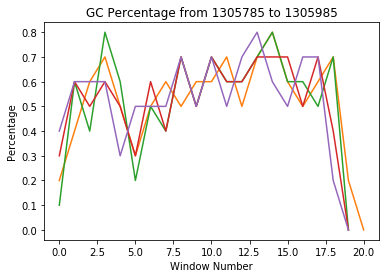

Motif locations for l(3)04053
GCAG: ['34', '92', '103', '116', '159']
CAGG: ['35', '86', '93', '113', '160']
AGCA: ['102', '141', '158', '175']
GCAGG: ['34', '92', '159']
CCGCGT: ['20', '183']
GCAGGG: ['34', '92']
CCACAG: ['83', '110']
CACAGG: ['84', '111']
AGGCAG: ['90', '114']
AGGACA: ['121', '161']
GACACT: ['123', '150']
CCACAGG: ['83', '110']
(1305785, 1305985)


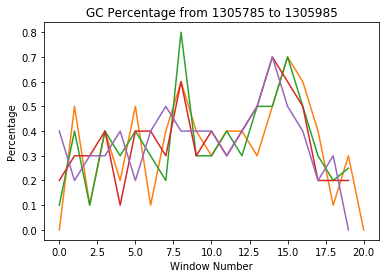

Motif locations for l(3)76BDm
TTAA: ['3', '20', '79', '121']
TAAA: ['4', '21', '46', '61', '184']
AAAA: ['5', '6', '7', '22', '23', '47', '48', '62', '101', '102']
GTAA: ['28', '39', '183', '196']
CGAT: ['58', '70', '107', '116']
TCGA: ['69', '106', '115', '160']
TAAAA: ['4', '21', '46', '61']
AAAAA: ['5', '6', '22', '47', '101']
TGTAA: ['27', '38', '182']
ATCGA: ['68', '105', '114']
TCGAT: ['69', '106', '115']
TTAAAA: ['3', '20']
TAAAAA: ['4', '21', '46']
AGCTCT: ['15', '139']
AAAAAT: ['22', '101']
ATAAAA: ['45', '60']
AAAACA: ['48', '62']
AAACAA: ['49', '63']
AATCGA: ['67', '104']
ATCGAT: ['68', '105', '114']
ATAGTT: ['131', '187']
GTGTCT: ['146', '165']
TTAAAAA: ['3', '20']
AAAACAA: ['48', '62']
AATCGAT: ['67', '104']
(1305785, 1305985)


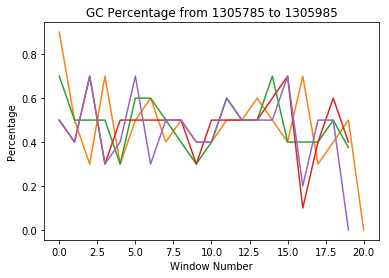

Motif locations for laza
GCCA: ['3', '66', '119', '186']
GCGA: ['7', '59', '131', '150']
AAGT: ['13', '40', '44', '122', '194']
AGTG: ['14', '45', '54', '116', '123']
GAAA: ['37', '48', '167', '182']
AGCGA: ['6', '58', '130']
AAGTG: ['13', '44', '122']
TAAGTG: ['12', '43']
GCCACT: ['66', '186']
AACCCA: ['143', '175']
(1305785, 1305985)


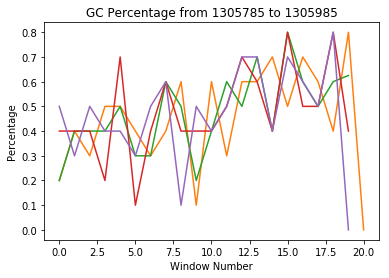

Motif locations for lush
ATTA: ['3', '62', '96']
TATT: ['5', '61', '181']
TTCC: ['21', '183', '188']
TAGT: ['40', '57', '172']
AGTT: ['41', '54', '58']
CGTT: ['87', '165', '186']
AGCC: ['119', '131', '144']
GCCT: ['145', '155', '161']
TCGT: ['164', '175', '178']
(1305785, 1305985)


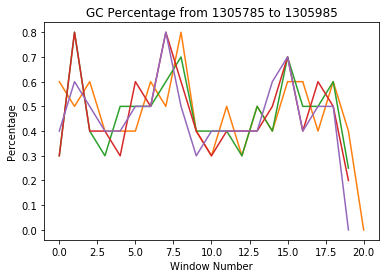

Motif locations for serp
CAAA: ['30', '94', '113', '126']
AAAC: ['31', '95', '129', '144']
GTGT: ['36', '101', '103', '117', '119']
ACTC: ['71', '90', '138', '146']
CTCT: ['72', '77', '139', '147']
TCTG: ['73', '78', '140', '148']
CCAA: ['93', '112', '125', '135', '183']
AAACA: ['31', '95', '129']
AGTGT: ['35', '100', '116']
AACTC: ['70', '137', '145']
ACTCT: ['71', '138', '146']
CTCTG: ['72', '77', '139', '147']
CCAAA: ['93', '112', '125']
CAAACA: ['30', '94']
AAACAG: ['31', '129']
CAACTC: ['69', '136']
AACTCT: ['70', '137', '145']
ACTCTG: ['71', '138', '146']
CTCTGC: ['72', '77']
AAGTGT: ['99', '115']
AGTGTG: ['100', '116']
GTGTGT: ['101', '117']
TGTGTT: ['102', '118']
CTCTGA: ['139', '147']
TCTGAA: ['140', '148']
CAACTCT: ['69', '136']
AACTCTG: ['70', '137', '145']
AAGTGTG: ['99', '115']
AGTGTGT: ['100', '116']
GTGTGTT: ['101', '117']
ACTCTGA: ['138', '146']
CTCTGAA: ['139', '147']
CAACTCTG: ['69', '136']
AAGTGTGT: ['99', '115']
AGTGTGTT: ['100', '116']
AACTCTGA: ['137', '145']
ACTC

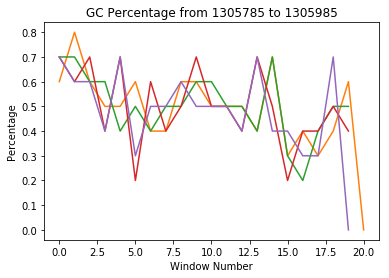

Motif locations for tey
CGAG: ['3', '28', '33', '86', '189']
CAAA: ['56', '153', '168', '174', '178', '185']
CCAA: ['68', '105', '152', '167', '173']
AAAC: ['114', '164', '170', '175', '186']
CCGAG: ['27', '32', '85']
TACCG: ['38', '46', '83']
GTGCC: ['102', '139', '149']
CCAAA: ['152', '167', '173']
CCGAGT: ['32', '85']
TTACCG: ['37', '45']
TACCGA: ['46', '83']
CCAACC: ['68', '105']
GTGCCA: ['102', '149']
TGCCAA: ['103', '150']
AGTGCC: ['138', '148']
AAACCA: ['164', '170']
AACCAA: ['165', '171']
ACCAAA: ['166', '172']
GTGCCAA: ['102', '149']
AAACCAA: ['164', '170']
AACCAAA: ['165', '171']
AAACCAAA: ['164', '170']
(1305785, 1305985)


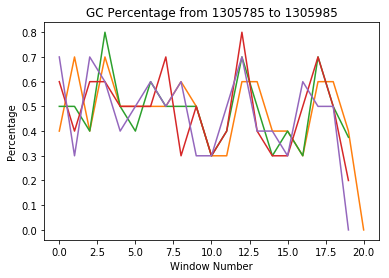

Motif locations for verm
GTGT: ['4', '18', '151']
AAGC: ['8', '61', '191']
TGTG: ['17', '143', '150']
AGAG: ['28', '75', '179', '181']
TCCA: ['40', '49', '58', '101', '139']
TTCC: ['48', '66', '100']
ATTC: ['52', '65', '169']
TTCG: ['53', '164', '170']
TCTG: ['79', '124', '186']
TTTC: ['99', '108', '163']
(1305785, 1305985)


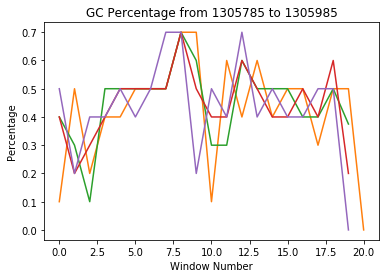

Motif locations for wnd
ATTG: ['1', '18', '138']
TTGA: ['2', '19', '139']
TGAT: ['3', '20', '113']
CATT: ['13', '17', '137']
GTGT: ['36', '42', '44', '46', '48', '50', '52', '54', '56', '58', '60', '62']
ATGT: ['40', '115', '148']
TGTG: ['41', '43', '45', '47', '49', '51', '53', '55', '57', '59', '61', '63']
GAAC: ['66', '92', '169']
CGAA: ['91', '161', '180']
AACC: ['93', '173', '183']
ACCC: ['94', '130', '184']
ATTGA: ['1', '18', '138']
TGTGT: ['41', '43', '45', '47', '49', '51', '53', '55', '57', '59', '61']
GTGTG: ['42', '44', '46', '48', '50', '52', '54', '56', '58', '60', '62']
ATTGAT: ['1', '18']
CATTGA: ['17', '137']
TGTGTG: ['41', '43', '45', '47', '49', '51', '53', '55', '57', '59', '61']
GTGTGT: ['42', '44', '46', '48', '50', '52', '54', '56', '58', '60']
AGGGAA: ['78', '166']
TGTGTGT: ['41', '43', '45', '47', '49', '51', '53', '55', '57', '59']
GTGTGTG: ['42', '44', '46', '48', '50', '52', '54', '56', '58', '60']
TGTGTGTG: ['41', '43', '45', '47', '49', '51', '53', '55', '5

In [10]:
# This is the display UI code which calls event handler code
# get all the file names in the data folder and display for our users
files = [f for f in os.listdir('data') if os.path.isfile(os.path.join("data", f))]

gtf_dropdown = widgets.Dropdown(options= files, description= "GFT:")
fasta_dropdown = widgets.Dropdown(options= files, description= "FASTA:")
num_mismatches = widgets.BoundedIntText(
    value = 0,
    min = 0,
    max = 10,
    step=1,
    description='Mismatches : ',
    disabled=False
)

def is_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        return change['new']
    return None

def fasta_selection(dd):
    if is_change(dd):
        return handle_fasta(is_change(dd))
    return None

def gft_selection(dd):
    if is_change(dd):
        global summary
        summary = handle_gft(is_change(dd))

    return None

def mismatch_selection(dd):
    if is_change(dd):
        global NUMBER_MISMATCHES
        NUMBER_MISMATCHES = is_change(dd)

    return None


o = gtf_dropdown.observe(gft_selection)
o = fasta_dropdown.observe(fasta_selection)
num_mismatches.observe(mismatch_selection)

display(gtf_dropdown)
display(fasta_dropdown)
display(num_mismatches)